# DQN for continuous action space


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.339260107412202 -2.8400300900230797
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float64, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float64, [None], name='targetQs')
    return states, actions, targetQs

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [20]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # nextQs
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob_actions * targetQs) # DPG
    gloss += tf.reduce_mean(neg_log_prob_actions * Qs) # DPG
    dloss = tf.reduce_mean(tf.square(Qs - targetQs)) # DQN
    # dloss = tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs,
    #                                                 labels=tf.nn.sigmoid(targetQs))
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    gloss += tf.reduce_mean(neg_log_prob_actions * dQs) # DPG
    dloss += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    # dloss += tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
    #                                                  labels=tf.nn.sigmoid(targetQs))
    gloss1 = tf.reduce_mean(neg_log_prob_actions)
    gloss2 = tf.reduce_mean(Qs)
    gloss3 = tf.reduce_mean(dQs)
    gloss4 = tf.reduce_mean(targetQs)
    return actions_logits, Qs, gloss, dloss, gloss1, gloss2, gloss3, gloss4

In [21]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [22]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_loss1, self.g_loss2, self.g_loss3, self.g_loss4 = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [23]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [24]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [29]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 50000            # memory capacity
batch_size = 500                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [30]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [31]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [28]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        gloss1_batch, gloss2_batch, gloss3_batch, gloss4_batch = [], [], [], []
        state = env.reset()

        # Training steps/batches
        for num_steps in range(1111111111):
            # Explore (Env) or Exploit (Model)
            total_step += 0.001
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, gloss1, gloss2, gloss3, gloss4, _, _ = sess.run([model.g_loss, model.d_loss,
                                                                           model.g_loss1, model.g_loss2, 
                                                                           model.g_loss3, model.g_loss4,
                                                                           model.g_opt, model.d_opt],
                                                                          feed_dict = {model.states: states, 
                                                                                       model.actions: actions,
                                                                                       model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            gloss1_batch.append(gloss1)
            gloss2_batch.append(gloss2)
            gloss3_batch.append(gloss3)
            gloss4_batch.append(gloss4)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'Steps:{}'.format(num_steps),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'gloss1-lgP:{:.4f}'.format(np.mean(gloss1_batch)), #-logp
              'gloss2-gQs:{:.4f}'.format(np.mean(gloss2_batch)),#gQs
              'gloss3-dQs:{:.4f}'.format(np.mean(gloss3_batch)),#dQs
              'gloss4-tgtQ:{:.4f}'.format(np.mean(gloss4_batch)),#tgtQs
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.        
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 Steps:14 meanR:15.0000 R:15.0000 gloss:0.6979 gloss1-lgP:0.6977 gloss2-gQs:0.0376 gloss3-dQs:-0.0733 gloss4-tgtQ:1.0360 dloss:2.2325 exploreP:1.0000
Episode:1 Steps:11 meanR:13.5000 R:12.0000 gloss:0.7891 gloss1-lgP:0.6952 gloss2-gQs:0.0761 gloss3-dQs:-0.0152 gloss4-tgtQ:1.0744 dloss:2.1906 exploreP:1.0000
Episode:2 Steps:28 meanR:18.6667 R:29.0000 gloss:0.9428 gloss1-lgP:0.6947 gloss2-gQs:0.1420 gloss3-dQs:0.0781 gloss4-tgtQ:1.1371 dloss:2.1265 exploreP:1.0000
Episode:3 Steps:10 meanR:16.7500 R:11.0000 gloss:1.0776 gloss1-lgP:0.6927 gloss2-gQs:0.1994 gloss3-dQs:0.1612 gloss4-tgtQ:1.1950 dloss:2.0814 exploreP:1.0000
Episode:4 Steps:14 meanR:16.4000 R:15.0000 gloss:1.1848 gloss1-lgP:0.6936 gloss2-gQs:0.2446 gloss3-dQs:0.2270 gloss4-tgtQ:1.2366 dloss:2.0345 exploreP:1.0000
Episode:5 Steps:19 meanR:17.0000 R:20.0000 gloss:1.3333 gloss1-lgP:0.6938 gloss2-gQs:0.3100 gloss3-dQs:0.3136 gloss4-tgtQ:1.2982 dloss:1.9888 exploreP:1.0000
Episode:6 Steps:100 meanR:29.0000 R:101.0000 gloss

Episode:53 Steps:24 meanR:22.2222 R:25.0000 gloss:26.0957 gloss1-lgP:0.6928 gloss2-gQs:12.3962 gloss3-dQs:12.6896 gloss4-tgtQ:12.5813 dloss:14.5889 exploreP:0.9999
Episode:54 Steps:14 meanR:22.0909 R:15.0000 gloss:26.3004 gloss1-lgP:0.6926 gloss2-gQs:12.4983 gloss3-dQs:12.7365 gloss4-tgtQ:12.7409 dloss:12.7895 exploreP:0.9999
Episode:55 Steps:35 meanR:22.3393 R:36.0000 gloss:26.5550 gloss1-lgP:0.6923 gloss2-gQs:12.5770 gloss3-dQs:12.9551 gloss4-tgtQ:12.8259 dloss:12.5972 exploreP:0.9999
Episode:56 Steps:11 meanR:22.1579 R:12.0000 gloss:26.5400 gloss1-lgP:0.6916 gloss2-gQs:12.6016 gloss3-dQs:13.0340 gloss4-tgtQ:12.7384 dloss:14.9610 exploreP:0.9999
Episode:57 Steps:15 meanR:22.0517 R:16.0000 gloss:26.2433 gloss1-lgP:0.6927 gloss2-gQs:12.4313 gloss3-dQs:12.8532 gloss4-tgtQ:12.6029 dloss:13.4149 exploreP:0.9999
Episode:58 Steps:17 meanR:21.9831 R:18.0000 gloss:26.0254 gloss1-lgP:0.6923 gloss2-gQs:12.2926 gloss3-dQs:12.7342 gloss4-tgtQ:12.5639 dloss:11.7371 exploreP:0.9999
Episode:59 Steps

Episode:104 Steps:27 meanR:22.0000 R:28.0000 gloss:28.6366 gloss1-lgP:0.6919 gloss2-gQs:13.7490 gloss3-dQs:13.9031 gloss4-tgtQ:13.7332 dloss:10.3301 exploreP:0.9998
Episode:105 Steps:10 meanR:21.9100 R:11.0000 gloss:28.2950 gloss1-lgP:0.6930 gloss2-gQs:13.7027 gloss3-dQs:13.4401 gloss4-tgtQ:13.6857 dloss:10.3607 exploreP:0.9998
Episode:106 Steps:42 meanR:21.3300 R:43.0000 gloss:28.5463 gloss1-lgP:0.6932 gloss2-gQs:13.6805 gloss3-dQs:13.7873 gloss4-tgtQ:13.7154 dloss:9.4510 exploreP:0.9998
Episode:107 Steps:17 meanR:21.2500 R:18.0000 gloss:28.0100 gloss1-lgP:0.6917 gloss2-gQs:13.5151 gloss3-dQs:13.5313 gloss4-tgtQ:13.4475 dloss:10.1294 exploreP:0.9998
Episode:108 Steps:20 meanR:21.3000 R:21.0000 gloss:28.0017 gloss1-lgP:0.6937 gloss2-gQs:13.4419 gloss3-dQs:13.3802 gloss4-tgtQ:13.5422 dloss:9.5357 exploreP:0.9998
Episode:109 Steps:30 meanR:21.5100 R:31.0000 gloss:30.4013 gloss1-lgP:0.6927 gloss2-gQs:14.6800 gloss3-dQs:14.5188 gloss4-tgtQ:14.6904 dloss:9.5128 exploreP:0.9998
Episode:110 S

Episode:154 Steps:34 meanR:23.0400 R:35.0000 gloss:27.2543 gloss1-lgP:0.6940 gloss2-gQs:13.0343 gloss3-dQs:13.1185 gloss4-tgtQ:13.1158 dloss:7.5426 exploreP:0.9997
Episode:155 Steps:21 meanR:22.9000 R:22.0000 gloss:26.5372 gloss1-lgP:0.6927 gloss2-gQs:12.5898 gloss3-dQs:13.0568 gloss4-tgtQ:12.6635 dloss:7.8645 exploreP:0.9996
Episode:156 Steps:30 meanR:23.0900 R:31.0000 gloss:26.2079 gloss1-lgP:0.6949 gloss2-gQs:12.4303 gloss3-dQs:12.7454 gloss4-tgtQ:12.5422 dloss:7.6166 exploreP:0.9996
Episode:157 Steps:32 meanR:23.2600 R:33.0000 gloss:27.1258 gloss1-lgP:0.6940 gloss2-gQs:12.9587 gloss3-dQs:13.0839 gloss4-tgtQ:13.0400 dloss:8.6485 exploreP:0.9996
Episode:158 Steps:28 meanR:23.3700 R:29.0000 gloss:26.3424 gloss1-lgP:0.6937 gloss2-gQs:12.6629 gloss3-dQs:12.5482 gloss4-tgtQ:12.7595 dloss:8.3322 exploreP:0.9996
Episode:159 Steps:20 meanR:23.4300 R:21.0000 gloss:27.0947 gloss1-lgP:0.6913 gloss2-gQs:12.9937 gloss3-dQs:13.1168 gloss4-tgtQ:13.0822 dloss:6.4355 exploreP:0.9996
Episode:160 Step

Episode:204 Steps:15 meanR:23.4800 R:16.0000 gloss:26.7042 gloss1-lgP:0.6952 gloss2-gQs:12.6311 gloss3-dQs:13.0528 gloss4-tgtQ:12.7317 dloss:7.4369 exploreP:0.9995
Episode:205 Steps:13 meanR:23.5100 R:14.0000 gloss:27.4754 gloss1-lgP:0.6940 gloss2-gQs:13.2545 gloss3-dQs:12.9642 gloss4-tgtQ:13.3669 dloss:7.5591 exploreP:0.9995
Episode:206 Steps:17 meanR:23.2600 R:18.0000 gloss:28.1931 gloss1-lgP:0.6935 gloss2-gQs:13.5030 gloss3-dQs:13.5426 gloss4-tgtQ:13.6038 dloss:7.8438 exploreP:0.9995
Episode:207 Steps:37 meanR:23.4600 R:38.0000 gloss:28.2940 gloss1-lgP:0.6950 gloss2-gQs:13.4674 gloss3-dQs:13.6958 gloss4-tgtQ:13.5442 dloss:8.3638 exploreP:0.9995
Episode:208 Steps:18 meanR:23.4400 R:19.0000 gloss:27.9548 gloss1-lgP:0.6942 gloss2-gQs:13.4285 gloss3-dQs:13.3984 gloss4-tgtQ:13.4429 dloss:8.0691 exploreP:0.9995
Episode:209 Steps:26 meanR:23.4000 R:27.0000 gloss:27.7849 gloss1-lgP:0.6951 gloss2-gQs:13.1566 gloss3-dQs:13.5397 gloss4-tgtQ:13.2741 dloss:7.4381 exploreP:0.9995
Episode:210 Step

Episode:255 Steps:17 meanR:21.7100 R:18.0000 gloss:28.6052 gloss1-lgP:0.6942 gloss2-gQs:13.6828 gloss3-dQs:13.7514 gloss4-tgtQ:13.7724 dloss:8.6679 exploreP:0.9994
Episode:256 Steps:17 meanR:21.5800 R:18.0000 gloss:28.3164 gloss1-lgP:0.6936 gloss2-gQs:13.5416 gloss3-dQs:13.6757 gloss4-tgtQ:13.6082 dloss:7.1147 exploreP:0.9994
Episode:257 Steps:10 meanR:21.3600 R:11.0000 gloss:29.1303 gloss1-lgP:0.6936 gloss2-gQs:14.0508 gloss3-dQs:13.8032 gloss4-tgtQ:14.1442 dloss:6.9111 exploreP:0.9994
Episode:258 Steps:17 meanR:21.2500 R:18.0000 gloss:28.1418 gloss1-lgP:0.6921 gloss2-gQs:13.3965 gloss3-dQs:13.8704 gloss4-tgtQ:13.3857 dloss:7.8436 exploreP:0.9994
Episode:259 Steps:19 meanR:21.2400 R:20.0000 gloss:28.5993 gloss1-lgP:0.6958 gloss2-gQs:13.7622 gloss3-dQs:13.5207 gloss4-tgtQ:13.8152 dloss:9.2626 exploreP:0.9994
Episode:260 Steps:14 meanR:21.2600 R:15.0000 gloss:28.4216 gloss1-lgP:0.6942 gloss2-gQs:13.5084 gloss3-dQs:13.8379 gloss4-tgtQ:13.5900 dloss:7.7789 exploreP:0.9994
Episode:261 Step

Episode:305 Steps:59 meanR:21.6100 R:60.0000 gloss:26.9678 gloss1-lgP:0.6945 gloss2-gQs:12.9313 gloss3-dQs:12.9063 gloss4-tgtQ:12.9889 dloss:7.3714 exploreP:0.9993
Episode:306 Steps:40 meanR:21.8400 R:41.0000 gloss:27.5274 gloss1-lgP:0.6947 gloss2-gQs:13.2315 gloss3-dQs:13.1338 gloss4-tgtQ:13.2577 dloss:7.6991 exploreP:0.9993
Episode:307 Steps:17 meanR:21.6400 R:18.0000 gloss:28.2022 gloss1-lgP:0.6938 gloss2-gQs:13.6070 gloss3-dQs:13.4036 gloss4-tgtQ:13.6355 dloss:6.7744 exploreP:0.9993
Episode:308 Steps:15 meanR:21.6100 R:16.0000 gloss:27.5089 gloss1-lgP:0.6940 gloss2-gQs:13.0279 gloss3-dQs:13.5128 gloss4-tgtQ:13.0978 dloss:9.3300 exploreP:0.9993
Episode:309 Steps:49 meanR:21.8400 R:50.0000 gloss:27.9793 gloss1-lgP:0.6950 gloss2-gQs:13.3742 gloss3-dQs:13.4481 gloss4-tgtQ:13.4380 dloss:7.3596 exploreP:0.9993
Episode:310 Steps:9 meanR:21.7600 R:10.0000 gloss:28.9424 gloss1-lgP:0.6949 gloss2-gQs:13.9826 gloss3-dQs:13.6352 gloss4-tgtQ:14.0276 dloss:7.9215 exploreP:0.9993
Episode:311 Steps

Episode:355 Steps:44 meanR:22.1600 R:45.0000 gloss:28.4116 gloss1-lgP:0.6949 gloss2-gQs:13.6265 gloss3-dQs:13.5868 gloss4-tgtQ:13.6696 dloss:8.1895 exploreP:0.9992
Episode:356 Steps:9 meanR:22.0800 R:10.0000 gloss:28.7872 gloss1-lgP:0.6913 gloss2-gQs:14.0770 gloss3-dQs:13.5488 gloss4-tgtQ:14.0134 dloss:7.1757 exploreP:0.9992
Episode:357 Steps:11 meanR:22.0900 R:12.0000 gloss:27.3968 gloss1-lgP:0.6935 gloss2-gQs:12.8947 gloss3-dQs:13.6234 gloss4-tgtQ:12.9849 dloss:7.7206 exploreP:0.9992
Episode:358 Steps:23 meanR:22.1500 R:24.0000 gloss:28.1113 gloss1-lgP:0.6945 gloss2-gQs:13.3930 gloss3-dQs:13.6403 gloss4-tgtQ:13.4421 dloss:8.5633 exploreP:0.9992
Episode:359 Steps:15 meanR:22.1100 R:16.0000 gloss:27.6377 gloss1-lgP:0.6976 gloss2-gQs:13.1250 gloss3-dQs:13.3350 gloss4-tgtQ:13.1555 dloss:13.7594 exploreP:0.9992
Episode:360 Steps:25 meanR:22.2200 R:26.0000 gloss:27.6217 gloss1-lgP:0.6953 gloss2-gQs:13.2544 gloss3-dQs:13.1623 gloss4-tgtQ:13.3165 dloss:9.1377 exploreP:0.9992
Episode:361 Step

Episode:405 Steps:21 meanR:22.8000 R:22.0000 gloss:27.3067 gloss1-lgP:0.6947 gloss2-gQs:13.0209 gloss3-dQs:13.1920 gloss4-tgtQ:13.0890 dloss:6.7875 exploreP:0.9991
Episode:406 Steps:14 meanR:22.5400 R:15.0000 gloss:27.2492 gloss1-lgP:0.6960 gloss2-gQs:12.9100 gloss3-dQs:13.2023 gloss4-tgtQ:13.0344 dloss:7.2059 exploreP:0.9991
Episode:407 Steps:21 meanR:22.5800 R:22.0000 gloss:28.3189 gloss1-lgP:0.6923 gloss2-gQs:13.7531 gloss3-dQs:13.3684 gloss4-tgtQ:13.7858 dloss:6.8389 exploreP:0.9991
Episode:408 Steps:24 meanR:22.6700 R:25.0000 gloss:28.6609 gloss1-lgP:0.6957 gloss2-gQs:13.6652 gloss3-dQs:13.7948 gloss4-tgtQ:13.7343 dloss:6.8166 exploreP:0.9991
Episode:409 Steps:19 meanR:22.3700 R:20.0000 gloss:28.4765 gloss1-lgP:0.6960 gloss2-gQs:13.4783 gloss3-dQs:13.8905 gloss4-tgtQ:13.5470 dloss:6.6448 exploreP:0.9991
Episode:410 Steps:17 meanR:22.4500 R:18.0000 gloss:28.5527 gloss1-lgP:0.6933 gloss2-gQs:13.7349 gloss3-dQs:13.6995 gloss4-tgtQ:13.7478 dloss:6.1942 exploreP:0.9991
Episode:411 Step

Episode:455 Steps:8 meanR:22.3900 R:9.0000 gloss:27.8611 gloss1-lgP:0.6963 gloss2-gQs:13.0853 gloss3-dQs:13.6976 gloss4-tgtQ:13.2248 dloss:10.7317 exploreP:0.9990
Episode:456 Steps:26 meanR:22.5600 R:27.0000 gloss:29.4070 gloss1-lgP:0.6952 gloss2-gQs:14.2809 gloss3-dQs:13.7103 gloss4-tgtQ:14.3127 dloss:9.3167 exploreP:0.9990
Episode:457 Steps:15 meanR:22.6000 R:16.0000 gloss:28.9191 gloss1-lgP:0.6949 gloss2-gQs:13.8112 gloss3-dQs:13.9653 gloss4-tgtQ:13.8349 dloss:6.8297 exploreP:0.9990
Episode:458 Steps:28 meanR:22.6500 R:29.0000 gloss:28.0711 gloss1-lgP:0.6936 gloss2-gQs:13.3186 gloss3-dQs:13.8335 gloss4-tgtQ:13.3143 dloss:8.2655 exploreP:0.9990
Episode:459 Steps:32 meanR:22.8200 R:33.0000 gloss:28.0624 gloss1-lgP:0.6968 gloss2-gQs:13.3553 gloss3-dQs:13.4732 gloss4-tgtQ:13.4431 dloss:9.5315 exploreP:0.9990
Episode:460 Steps:60 meanR:23.1700 R:61.0000 gloss:28.2426 gloss1-lgP:0.6949 gloss2-gQs:13.5499 gloss3-dQs:13.5217 gloss4-tgtQ:13.5701 dloss:7.1589 exploreP:0.9990
Episode:461 Steps

Episode:506 Steps:11 meanR:22.3800 R:12.0000 gloss:28.3502 gloss1-lgP:0.6978 gloss2-gQs:13.6192 gloss3-dQs:13.3895 gloss4-tgtQ:13.6181 dloss:6.4402 exploreP:0.9989
Episode:507 Steps:49 meanR:22.6600 R:50.0000 gloss:27.7538 gloss1-lgP:0.6967 gloss2-gQs:13.2276 gloss3-dQs:13.3070 gloss4-tgtQ:13.2922 dloss:8.4945 exploreP:0.9989
Episode:508 Steps:12 meanR:22.5400 R:13.0000 gloss:28.2406 gloss1-lgP:0.6970 gloss2-gQs:13.3199 gloss3-dQs:13.7733 gloss4-tgtQ:13.4078 dloss:12.3158 exploreP:0.9989
Episode:509 Steps:27 meanR:22.6200 R:28.0000 gloss:27.3554 gloss1-lgP:0.6962 gloss2-gQs:12.9753 gloss3-dQs:13.3065 gloss4-tgtQ:13.0115 dloss:7.5953 exploreP:0.9989
Episode:510 Steps:14 meanR:22.5900 R:15.0000 gloss:27.8703 gloss1-lgP:0.6932 gloss2-gQs:13.4436 gloss3-dQs:13.2732 gloss4-tgtQ:13.4855 dloss:5.7307 exploreP:0.9989
Episode:511 Steps:10 meanR:22.5900 R:11.0000 gloss:28.4268 gloss1-lgP:0.6949 gloss2-gQs:13.6586 gloss3-dQs:13.5094 gloss4-tgtQ:13.7435 dloss:5.3034 exploreP:0.9989
Episode:512 Ste

Episode:557 Steps:15 meanR:23.6400 R:16.0000 gloss:28.5794 gloss1-lgP:0.6956 gloss2-gQs:13.6641 gloss3-dQs:13.7477 gloss4-tgtQ:13.6753 dloss:6.4280 exploreP:0.9988
Episode:558 Steps:23 meanR:23.5900 R:24.0000 gloss:28.0677 gloss1-lgP:0.6937 gloss2-gQs:13.4078 gloss3-dQs:13.5964 gloss4-tgtQ:13.4538 dloss:5.6505 exploreP:0.9988
Episode:559 Steps:18 meanR:23.4500 R:19.0000 gloss:29.1138 gloss1-lgP:0.6948 gloss2-gQs:14.0443 gloss3-dQs:13.7563 gloss4-tgtQ:14.0943 dloss:7.2426 exploreP:0.9988
Episode:560 Steps:12 meanR:22.9700 R:13.0000 gloss:29.9857 gloss1-lgP:0.6974 gloss2-gQs:14.5060 gloss3-dQs:13.9311 gloss4-tgtQ:14.5566 dloss:7.9393 exploreP:0.9988
Episode:561 Steps:27 meanR:23.0200 R:28.0000 gloss:30.7429 gloss1-lgP:0.6960 gloss2-gQs:14.7947 gloss3-dQs:14.5201 gloss4-tgtQ:14.8482 dloss:9.4214 exploreP:0.9987
Episode:562 Steps:11 meanR:22.7400 R:12.0000 gloss:29.9182 gloss1-lgP:0.6939 gloss2-gQs:14.2904 gloss3-dQs:14.5336 gloss4-tgtQ:14.2886 dloss:8.9493 exploreP:0.9987
Episode:563 Step

Episode:607 Steps:30 meanR:23.8200 R:31.0000 gloss:27.4050 gloss1-lgP:0.6951 gloss2-gQs:12.9841 gloss3-dQs:13.4333 gloss4-tgtQ:13.0173 dloss:10.7782 exploreP:0.9986
Episode:608 Steps:20 meanR:23.9000 R:21.0000 gloss:27.1817 gloss1-lgP:0.6949 gloss2-gQs:12.9728 gloss3-dQs:13.1393 gloss4-tgtQ:13.0003 dloss:7.1188 exploreP:0.9986
Episode:609 Steps:17 meanR:23.8000 R:18.0000 gloss:27.7930 gloss1-lgP:0.6968 gloss2-gQs:13.3260 gloss3-dQs:13.1831 gloss4-tgtQ:13.3804 dloss:6.8798 exploreP:0.9986
Episode:610 Steps:9 meanR:23.7500 R:10.0000 gloss:27.8019 gloss1-lgP:0.6933 gloss2-gQs:13.4914 gloss3-dQs:13.0991 gloss4-tgtQ:13.5108 dloss:6.5282 exploreP:0.9986
Episode:611 Steps:15 meanR:23.8000 R:16.0000 gloss:27.6566 gloss1-lgP:0.6956 gloss2-gQs:13.0386 gloss3-dQs:13.5895 gloss4-tgtQ:13.1379 dloss:7.1823 exploreP:0.9986
Episode:612 Steps:13 meanR:23.4200 R:14.0000 gloss:27.6046 gloss1-lgP:0.6944 gloss2-gQs:13.2805 gloss3-dQs:13.1947 gloss4-tgtQ:13.2751 dloss:5.8163 exploreP:0.9986
Episode:613 Step

Episode:657 Steps:16 meanR:21.2100 R:17.0000 gloss:27.6537 gloss1-lgP:0.6962 gloss2-gQs:13.2437 gloss3-dQs:13.1927 gloss4-tgtQ:13.2920 dloss:7.9674 exploreP:0.9985
Episode:658 Steps:26 meanR:21.2400 R:27.0000 gloss:27.9444 gloss1-lgP:0.6938 gloss2-gQs:13.5048 gloss3-dQs:13.2557 gloss4-tgtQ:13.5125 dloss:6.5061 exploreP:0.9985
Episode:659 Steps:9 meanR:21.1500 R:10.0000 gloss:29.6835 gloss1-lgP:0.6951 gloss2-gQs:14.4903 gloss3-dQs:13.6549 gloss4-tgtQ:14.5570 dloss:7.6362 exploreP:0.9985
Episode:660 Steps:37 meanR:21.4000 R:38.0000 gloss:27.0815 gloss1-lgP:0.6975 gloss2-gQs:12.7546 gloss3-dQs:13.2807 gloss4-tgtQ:12.7994 dloss:13.1338 exploreP:0.9985
Episode:661 Steps:15 meanR:21.2800 R:16.0000 gloss:27.9749 gloss1-lgP:0.6957 gloss2-gQs:13.4635 gloss3-dQs:13.2206 gloss4-tgtQ:13.5151 dloss:10.5799 exploreP:0.9985
Episode:662 Steps:17 meanR:21.3400 R:18.0000 gloss:28.2361 gloss1-lgP:0.6959 gloss2-gQs:13.6158 gloss3-dQs:13.3516 gloss4-tgtQ:13.6027 dloss:8.5559 exploreP:0.9985
Episode:663 Ste

Episode:707 Steps:57 meanR:19.9900 R:58.0000 gloss:27.5887 gloss1-lgP:0.6968 gloss2-gQs:13.2460 gloss3-dQs:13.0424 gloss4-tgtQ:13.2987 dloss:6.9869 exploreP:0.9984
Episode:708 Steps:11 meanR:19.9000 R:12.0000 gloss:26.2243 gloss1-lgP:0.6943 gloss2-gQs:12.3692 gloss3-dQs:13.0476 gloss4-tgtQ:12.3557 dloss:8.1351 exploreP:0.9984
Episode:709 Steps:14 meanR:19.8700 R:15.0000 gloss:27.8410 gloss1-lgP:0.6954 gloss2-gQs:13.5405 gloss3-dQs:12.9147 gloss4-tgtQ:13.5787 dloss:10.4425 exploreP:0.9984
Episode:710 Steps:25 meanR:20.0300 R:26.0000 gloss:27.9769 gloss1-lgP:0.6957 gloss2-gQs:13.5111 gloss3-dQs:13.1621 gloss4-tgtQ:13.5521 dloss:12.0568 exploreP:0.9984
Episode:711 Steps:15 meanR:20.0300 R:16.0000 gloss:27.5743 gloss1-lgP:0.6973 gloss2-gQs:13.0201 gloss3-dQs:13.4016 gloss4-tgtQ:13.1165 dloss:13.9163 exploreP:0.9984
Episode:712 Steps:9 meanR:19.9900 R:10.0000 gloss:29.4915 gloss1-lgP:0.6949 gloss2-gQs:14.3927 gloss3-dQs:13.5671 gloss4-tgtQ:14.4694 dloss:9.7636 exploreP:0.9984
Episode:713 St

Episode:757 Steps:12 meanR:20.8200 R:13.0000 gloss:26.9657 gloss1-lgP:0.6925 gloss2-gQs:12.9392 gloss3-dQs:13.0747 gloss4-tgtQ:12.9255 dloss:5.0566 exploreP:0.9983
Episode:758 Steps:17 meanR:20.7300 R:18.0000 gloss:28.6562 gloss1-lgP:0.6971 gloss2-gQs:13.7465 gloss3-dQs:13.5351 gloss4-tgtQ:13.8248 dloss:5.4815 exploreP:0.9983
Episode:759 Steps:15 meanR:20.7900 R:16.0000 gloss:26.0111 gloss1-lgP:0.6949 gloss2-gQs:12.1158 gloss3-dQs:13.1599 gloss4-tgtQ:12.1534 dloss:7.9460 exploreP:0.9983
Episode:760 Steps:11 meanR:20.5300 R:12.0000 gloss:26.6013 gloss1-lgP:0.6924 gloss2-gQs:12.7438 gloss3-dQs:12.9504 gloss4-tgtQ:12.7184 dloss:5.7145 exploreP:0.9983
Episode:761 Steps:26 meanR:20.6400 R:27.0000 gloss:26.4211 gloss1-lgP:0.6971 gloss2-gQs:12.4838 gloss3-dQs:12.8749 gloss4-tgtQ:12.5404 dloss:6.7697 exploreP:0.9983
Episode:762 Steps:53 meanR:21.0000 R:54.0000 gloss:25.5550 gloss1-lgP:0.6971 gloss2-gQs:12.1350 gloss3-dQs:12.3421 gloss4-tgtQ:12.1791 dloss:13.5404 exploreP:0.9983
Episode:763 Ste

Episode:807 Steps:60 meanR:20.9800 R:61.0000 gloss:26.7287 gloss1-lgP:0.6958 gloss2-gQs:12.8311 gloss3-dQs:12.7057 gloss4-tgtQ:12.8789 dloss:6.2361 exploreP:0.9982
Episode:808 Steps:21 meanR:21.0800 R:22.0000 gloss:26.8382 gloss1-lgP:0.6988 gloss2-gQs:12.7341 gloss3-dQs:12.9106 gloss4-tgtQ:12.7651 dloss:6.3962 exploreP:0.9982
Episode:809 Steps:23 meanR:21.1700 R:24.0000 gloss:27.8264 gloss1-lgP:0.6974 gloss2-gQs:13.3645 gloss3-dQs:13.0940 gloss4-tgtQ:13.4421 dloss:9.1894 exploreP:0.9982
Episode:810 Steps:20 meanR:21.1200 R:21.0000 gloss:27.0855 gloss1-lgP:0.6965 gloss2-gQs:12.8208 gloss3-dQs:13.1930 gloss4-tgtQ:12.8749 dloss:6.2936 exploreP:0.9982
Episode:811 Steps:11 meanR:21.0800 R:12.0000 gloss:27.8210 gloss1-lgP:0.6923 gloss2-gQs:13.4243 gloss3-dQs:13.3336 gloss4-tgtQ:13.4336 dloss:6.2219 exploreP:0.9982
Episode:812 Steps:19 meanR:21.1800 R:20.0000 gloss:27.2903 gloss1-lgP:0.6958 gloss2-gQs:12.9764 gloss3-dQs:13.2388 gloss4-tgtQ:13.0110 dloss:9.1565 exploreP:0.9982
Episode:813 Step

Episode:857 Steps:22 meanR:21.7100 R:23.0000 gloss:28.6481 gloss1-lgP:0.6964 gloss2-gQs:13.9167 gloss3-dQs:13.2856 gloss4-tgtQ:13.9189 dloss:12.6665 exploreP:0.9981
Episode:858 Steps:24 meanR:21.7800 R:25.0000 gloss:27.2230 gloss1-lgP:0.6964 gloss2-gQs:12.9165 gloss3-dQs:13.2238 gloss4-tgtQ:12.9500 dloss:5.8051 exploreP:0.9981
Episode:859 Steps:15 meanR:21.7800 R:16.0000 gloss:27.0505 gloss1-lgP:0.6946 gloss2-gQs:12.9282 gloss3-dQs:13.0732 gloss4-tgtQ:12.9432 dloss:5.9964 exploreP:0.9981
Episode:860 Steps:10 meanR:21.7700 R:11.0000 gloss:28.4964 gloss1-lgP:0.7027 gloss2-gQs:13.7052 gloss3-dQs:13.1011 gloss4-tgtQ:13.7479 dloss:6.8084 exploreP:0.9981
Episode:861 Steps:27 meanR:21.7800 R:28.0000 gloss:27.6887 gloss1-lgP:0.6963 gloss2-gQs:13.2274 gloss3-dQs:13.2984 gloss4-tgtQ:13.2383 dloss:6.7634 exploreP:0.9981
Episode:862 Steps:18 meanR:21.4300 R:19.0000 gloss:26.5214 gloss1-lgP:0.6956 gloss2-gQs:12.5004 gloss3-dQs:13.0582 gloss4-tgtQ:12.5613 dloss:8.4651 exploreP:0.9981
Episode:863 Ste

Episode:908 Steps:10 meanR:22.6300 R:11.0000 gloss:26.8243 gloss1-lgP:0.6940 gloss2-gQs:12.8733 gloss3-dQs:12.8941 gloss4-tgtQ:12.8841 dloss:5.2327 exploreP:0.9980
Episode:909 Steps:19 meanR:22.5900 R:20.0000 gloss:26.2193 gloss1-lgP:0.6947 gloss2-gQs:12.4682 gloss3-dQs:12.7953 gloss4-tgtQ:12.4706 dloss:6.6532 exploreP:0.9980
Episode:910 Steps:18 meanR:22.5700 R:19.0000 gloss:25.0938 gloss1-lgP:0.6951 gloss2-gQs:11.8507 gloss3-dQs:12.3845 gloss4-tgtQ:11.8666 dloss:6.5816 exploreP:0.9980
Episode:911 Steps:21 meanR:22.6700 R:22.0000 gloss:25.4386 gloss1-lgP:0.6966 gloss2-gQs:12.1912 gloss3-dQs:12.0736 gloss4-tgtQ:12.2557 dloss:5.8299 exploreP:0.9980
Episode:912 Steps:26 meanR:22.7400 R:27.0000 gloss:25.7028 gloss1-lgP:0.6954 gloss2-gQs:12.2303 gloss3-dQs:12.4552 gloss4-tgtQ:12.2731 dloss:6.4174 exploreP:0.9980
Episode:913 Steps:9 meanR:22.6900 R:10.0000 gloss:26.7361 gloss1-lgP:0.6970 gloss2-gQs:12.8573 gloss3-dQs:12.6152 gloss4-tgtQ:12.8867 dloss:4.7961 exploreP:0.9980
Episode:914 Steps

Episode:958 Steps:15 meanR:22.7400 R:16.0000 gloss:27.3655 gloss1-lgP:0.6966 gloss2-gQs:13.0426 gloss3-dQs:13.1856 gloss4-tgtQ:13.0522 dloss:6.8560 exploreP:0.9979
Episode:959 Steps:14 meanR:22.7300 R:15.0000 gloss:26.3850 gloss1-lgP:0.6942 gloss2-gQs:12.5080 gloss3-dQs:12.9716 gloss4-tgtQ:12.5267 dloss:5.4085 exploreP:0.9979
Episode:960 Steps:15 meanR:22.7800 R:16.0000 gloss:25.6502 gloss1-lgP:0.6946 gloss2-gQs:12.0159 gloss3-dQs:12.8613 gloss4-tgtQ:12.0507 dloss:6.6765 exploreP:0.9979
Episode:961 Steps:39 meanR:22.9000 R:40.0000 gloss:26.3586 gloss1-lgP:0.6957 gloss2-gQs:12.6491 gloss3-dQs:12.5511 gloss4-tgtQ:12.6894 dloss:5.3337 exploreP:0.9979
Episode:962 Steps:18 meanR:22.9000 R:19.0000 gloss:27.0449 gloss1-lgP:0.6959 gloss2-gQs:13.0176 gloss3-dQs:12.8281 gloss4-tgtQ:13.0188 dloss:6.6395 exploreP:0.9979
Episode:963 Steps:11 meanR:22.8400 R:12.0000 gloss:25.4305 gloss1-lgP:0.6948 gloss2-gQs:12.0080 gloss3-dQs:12.5398 gloss4-tgtQ:12.0454 dloss:6.1792 exploreP:0.9979
Episode:964 Step

Episode:1009 Steps:32 meanR:22.9500 R:33.0000 gloss:26.3538 gloss1-lgP:0.6957 gloss2-gQs:12.4992 gloss3-dQs:12.8375 gloss4-tgtQ:12.5427 dloss:5.4953 exploreP:0.9978
Episode:1010 Steps:25 meanR:23.0200 R:26.0000 gloss:25.1891 gloss1-lgP:0.6954 gloss2-gQs:11.8420 gloss3-dQs:12.4971 gloss4-tgtQ:11.8855 dloss:10.5590 exploreP:0.9978
Episode:1011 Steps:9 meanR:22.9000 R:10.0000 gloss:25.8579 gloss1-lgP:0.6939 gloss2-gQs:12.5298 gloss3-dQs:12.1788 gloss4-tgtQ:12.5597 dloss:7.4821 exploreP:0.9978
Episode:1012 Steps:26 meanR:22.9000 R:27.0000 gloss:25.8655 gloss1-lgP:0.6975 gloss2-gQs:12.3587 gloss3-dQs:12.2959 gloss4-tgtQ:12.4297 dloss:10.4244 exploreP:0.9978
Episode:1013 Steps:33 meanR:23.1400 R:34.0000 gloss:26.3759 gloss1-lgP:0.6949 gloss2-gQs:12.6797 gloss3-dQs:12.5623 gloss4-tgtQ:12.7192 dloss:20.2840 exploreP:0.9978
Episode:1014 Steps:27 meanR:23.2300 R:28.0000 gloss:26.0530 gloss1-lgP:0.6946 gloss2-gQs:12.4095 gloss3-dQs:12.6752 gloss4-tgtQ:12.4210 dloss:5.7525 exploreP:0.9978
Episode:

Episode:1059 Steps:23 meanR:23.1900 R:24.0000 gloss:24.6385 gloss1-lgP:0.6961 gloss2-gQs:11.5481 gloss3-dQs:12.2316 gloss4-tgtQ:11.6159 dloss:12.4580 exploreP:0.9977
Episode:1060 Steps:66 meanR:23.7000 R:67.0000 gloss:24.9592 gloss1-lgP:0.6968 gloss2-gQs:11.9026 gloss3-dQs:11.9202 gloss4-tgtQ:11.9873 dloss:7.8299 exploreP:0.9977
Episode:1061 Steps:15 meanR:23.4600 R:16.0000 gloss:25.1607 gloss1-lgP:0.6937 gloss2-gQs:12.0638 gloss3-dQs:12.1434 gloss4-tgtQ:12.0612 dloss:9.4426 exploreP:0.9977
Episode:1062 Steps:19 meanR:23.4700 R:20.0000 gloss:25.3633 gloss1-lgP:0.6955 gloss2-gQs:12.0698 gloss3-dQs:12.2639 gloss4-tgtQ:12.1331 dloss:6.2600 exploreP:0.9977
Episode:1063 Steps:44 meanR:23.8000 R:45.0000 gloss:26.3199 gloss1-lgP:0.6963 gloss2-gQs:12.6281 gloss3-dQs:12.4898 gloss4-tgtQ:12.6758 dloss:6.9019 exploreP:0.9977
Episode:1064 Steps:18 meanR:23.8400 R:19.0000 gloss:26.0962 gloss1-lgP:0.6963 gloss2-gQs:12.3618 gloss3-dQs:12.6591 gloss4-tgtQ:12.4562 dloss:7.0786 exploreP:0.9977
Episode:1

Episode:1109 Steps:23 meanR:24.0300 R:24.0000 gloss:27.0616 gloss1-lgP:0.7006 gloss2-gQs:12.8501 gloss3-dQs:12.8554 gloss4-tgtQ:12.9257 dloss:9.5121 exploreP:0.9975
Episode:1110 Steps:11 meanR:23.8900 R:12.0000 gloss:26.7250 gloss1-lgP:0.6967 gloss2-gQs:12.7358 gloss3-dQs:12.8226 gloss4-tgtQ:12.8042 dloss:8.4096 exploreP:0.9975
Episode:1111 Steps:20 meanR:24.0000 R:21.0000 gloss:27.9566 gloss1-lgP:0.6960 gloss2-gQs:13.5645 gloss3-dQs:12.9981 gloss4-tgtQ:13.6043 dloss:7.5393 exploreP:0.9975
Episode:1112 Steps:21 meanR:23.9500 R:22.0000 gloss:27.8658 gloss1-lgP:0.6960 gloss2-gQs:13.3618 gloss3-dQs:13.2741 gloss4-tgtQ:13.4005 dloss:6.3699 exploreP:0.9975
Episode:1113 Steps:11 meanR:23.7300 R:12.0000 gloss:26.7231 gloss1-lgP:0.6979 gloss2-gQs:12.4384 gloss3-dQs:13.3529 gloss4-tgtQ:12.5021 dloss:9.2618 exploreP:0.9975
Episode:1114 Steps:20 meanR:23.6600 R:21.0000 gloss:28.6586 gloss1-lgP:0.6994 gloss2-gQs:13.7303 gloss3-dQs:13.4627 gloss4-tgtQ:13.7691 dloss:11.2776 exploreP:0.9975
Episode:1

Episode:1160 Steps:26 meanR:22.5900 R:27.0000 gloss:27.5612 gloss1-lgP:0.6974 gloss2-gQs:13.2088 gloss3-dQs:13.0201 gloss4-tgtQ:13.2910 dloss:9.0209 exploreP:0.9974
Episode:1161 Steps:21 meanR:22.6500 R:22.0000 gloss:27.4422 gloss1-lgP:0.6974 gloss2-gQs:13.0087 gloss3-dQs:13.2950 gloss4-tgtQ:13.0468 dloss:8.4939 exploreP:0.9974
Episode:1162 Steps:12 meanR:22.5800 R:13.0000 gloss:29.3497 gloss1-lgP:0.6955 gloss2-gQs:14.2522 gloss3-dQs:13.6425 gloss4-tgtQ:14.2953 dloss:9.7819 exploreP:0.9974
Episode:1163 Steps:53 meanR:22.6700 R:54.0000 gloss:28.3371 gloss1-lgP:0.6956 gloss2-gQs:13.5609 gloss3-dQs:13.5952 gloss4-tgtQ:13.5802 dloss:9.8052 exploreP:0.9974
Episode:1164 Steps:26 meanR:22.7500 R:27.0000 gloss:26.8463 gloss1-lgP:0.6967 gloss2-gQs:12.5629 gloss3-dQs:13.3678 gloss4-tgtQ:12.6077 dloss:8.8894 exploreP:0.9974
Episode:1165 Steps:33 meanR:22.9200 R:34.0000 gloss:26.8654 gloss1-lgP:0.6963 gloss2-gQs:12.8568 gloss3-dQs:12.7956 gloss4-tgtQ:12.9244 dloss:8.6166 exploreP:0.9974
Episode:11

Episode:1211 Steps:11 meanR:21.4400 R:12.0000 gloss:28.3522 gloss1-lgP:0.6946 gloss2-gQs:13.5796 gloss3-dQs:13.6547 gloss4-tgtQ:13.5831 dloss:5.9141 exploreP:0.9973
Episode:1212 Steps:13 meanR:21.3600 R:14.0000 gloss:29.0844 gloss1-lgP:0.6987 gloss2-gQs:13.9557 gloss3-dQs:13.6621 gloss4-tgtQ:14.0074 dloss:7.9709 exploreP:0.9973
Episode:1213 Steps:19 meanR:21.4400 R:20.0000 gloss:27.8306 gloss1-lgP:0.6946 gloss2-gQs:13.1251 gloss3-dQs:13.7964 gloss4-tgtQ:13.1423 dloss:6.3883 exploreP:0.9973
Episode:1214 Steps:12 meanR:21.3600 R:13.0000 gloss:26.2019 gloss1-lgP:0.6949 gloss2-gQs:12.1901 gloss3-dQs:13.3220 gloss4-tgtQ:12.1917 dloss:7.9839 exploreP:0.9973
Episode:1215 Steps:25 meanR:21.3000 R:26.0000 gloss:27.2283 gloss1-lgP:0.6976 gloss2-gQs:13.0351 gloss3-dQs:12.8880 gloss4-tgtQ:13.0977 dloss:11.3357 exploreP:0.9973
Episode:1216 Steps:45 meanR:21.5700 R:46.0000 gloss:27.9749 gloss1-lgP:0.6975 gloss2-gQs:13.4690 gloss3-dQs:13.1368 gloss4-tgtQ:13.5022 dloss:11.0817 exploreP:0.9973
Episode:

Episode:1261 Steps:14 meanR:22.4500 R:15.0000 gloss:27.9517 gloss1-lgP:0.6965 gloss2-gQs:13.3245 gloss3-dQs:13.4466 gloss4-tgtQ:13.3620 dloss:6.2217 exploreP:0.9972
Episode:1262 Steps:22 meanR:22.5500 R:23.0000 gloss:27.5480 gloss1-lgP:0.6984 gloss2-gQs:12.9609 gloss3-dQs:13.4863 gloss4-tgtQ:13.0012 dloss:10.1636 exploreP:0.9972
Episode:1263 Steps:12 meanR:22.1400 R:13.0000 gloss:27.0639 gloss1-lgP:0.6970 gloss2-gQs:12.7266 gloss3-dQs:13.3513 gloss4-tgtQ:12.7489 dloss:8.7643 exploreP:0.9972
Episode:1264 Steps:11 meanR:21.9900 R:12.0000 gloss:29.9067 gloss1-lgP:0.6995 gloss2-gQs:14.6549 gloss3-dQs:13.3556 gloss4-tgtQ:14.7273 dloss:18.4428 exploreP:0.9972
Episode:1265 Steps:11 meanR:21.7700 R:12.0000 gloss:27.1131 gloss1-lgP:0.6967 gloss2-gQs:12.8552 gloss3-dQs:13.1946 gloss4-tgtQ:12.8739 dloss:9.8799 exploreP:0.9972
Episode:1266 Steps:23 meanR:21.8800 R:24.0000 gloss:25.6196 gloss1-lgP:0.6994 gloss2-gQs:11.7561 gloss3-dQs:13.0467 gloss4-tgtQ:11.8317 dloss:14.0516 exploreP:0.9972
Episode

Episode:1311 Steps:19 meanR:22.8400 R:20.0000 gloss:26.4426 gloss1-lgP:0.6974 gloss2-gQs:12.3712 gloss3-dQs:13.1273 gloss4-tgtQ:12.4194 dloss:10.1009 exploreP:0.9971
Episode:1312 Steps:43 meanR:23.1400 R:44.0000 gloss:27.9915 gloss1-lgP:0.6992 gloss2-gQs:13.3889 gloss3-dQs:13.1957 gloss4-tgtQ:13.4526 dloss:9.6877 exploreP:0.9971
Episode:1313 Steps:20 meanR:23.1500 R:21.0000 gloss:28.2372 gloss1-lgP:0.6983 gloss2-gQs:13.4657 gloss3-dQs:13.4606 gloss4-tgtQ:13.4969 dloss:19.4545 exploreP:0.9971
Episode:1314 Steps:37 meanR:23.4000 R:38.0000 gloss:28.9394 gloss1-lgP:0.7005 gloss2-gQs:13.7065 gloss3-dQs:13.8854 gloss4-tgtQ:13.7252 dloss:30.7623 exploreP:0.9971
Episode:1315 Steps:30 meanR:23.4500 R:31.0000 gloss:28.1336 gloss1-lgP:0.6967 gloss2-gQs:13.4100 gloss3-dQs:13.5247 gloss4-tgtQ:13.4421 dloss:6.6602 exploreP:0.9971
Episode:1316 Steps:11 meanR:23.1100 R:12.0000 gloss:27.6890 gloss1-lgP:0.6939 gloss2-gQs:13.3018 gloss3-dQs:13.2827 gloss4-tgtQ:13.3159 dloss:5.0316 exploreP:0.9971
Episode

Episode:1362 Steps:23 meanR:22.9600 R:24.0000 gloss:27.8869 gloss1-lgP:0.6981 gloss2-gQs:13.0667 gloss3-dQs:13.7503 gloss4-tgtQ:13.1201 dloss:11.4662 exploreP:0.9970
Episode:1363 Steps:40 meanR:23.2400 R:41.0000 gloss:28.5558 gloss1-lgP:0.6954 gloss2-gQs:13.6589 gloss3-dQs:13.7129 gloss4-tgtQ:13.6901 dloss:6.5327 exploreP:0.9970
Episode:1364 Steps:10 meanR:23.2300 R:11.0000 gloss:28.4979 gloss1-lgP:0.6947 gloss2-gQs:13.7397 gloss3-dQs:13.5519 gloss4-tgtQ:13.7205 dloss:6.9732 exploreP:0.9970
Episode:1365 Steps:28 meanR:23.4000 R:29.0000 gloss:28.3858 gloss1-lgP:0.6963 gloss2-gQs:13.4990 gloss3-dQs:13.7252 gloss4-tgtQ:13.5369 dloss:9.6760 exploreP:0.9970
Episode:1366 Steps:21 meanR:23.3800 R:22.0000 gloss:28.9666 gloss1-lgP:0.6975 gloss2-gQs:13.9027 gloss3-dQs:13.7000 gloss4-tgtQ:13.9256 dloss:6.5850 exploreP:0.9970
Episode:1367 Steps:26 meanR:23.4700 R:27.0000 gloss:29.4080 gloss1-lgP:0.6963 gloss2-gQs:14.1985 gloss3-dQs:13.8127 gloss4-tgtQ:14.2259 dloss:10.9201 exploreP:0.9970
Episode:

Episode:1412 Steps:37 meanR:23.6200 R:38.0000 gloss:26.5375 gloss1-lgP:0.6954 gloss2-gQs:12.4794 gloss3-dQs:13.1556 gloss4-tgtQ:12.5316 dloss:13.0620 exploreP:0.9969
Episode:1413 Steps:9 meanR:23.5100 R:10.0000 gloss:28.7012 gloss1-lgP:0.6958 gloss2-gQs:14.0814 gloss3-dQs:13.0308 gloss4-tgtQ:14.1287 dloss:12.1979 exploreP:0.9969
Episode:1414 Steps:34 meanR:23.4800 R:35.0000 gloss:27.2134 gloss1-lgP:0.6960 gloss2-gQs:13.1339 gloss3-dQs:12.7929 gloss4-tgtQ:13.1759 dloss:8.2477 exploreP:0.9969
Episode:1415 Steps:9 meanR:23.2700 R:10.0000 gloss:25.6294 gloss1-lgP:0.6952 gloss2-gQs:11.8657 gloss3-dQs:13.1176 gloss4-tgtQ:11.8805 dloss:8.9877 exploreP:0.9969
Episode:1416 Steps:34 meanR:23.5000 R:35.0000 gloss:27.1306 gloss1-lgP:0.6954 gloss2-gQs:12.9591 gloss3-dQs:13.0453 gloss4-tgtQ:13.0147 dloss:7.0323 exploreP:0.9969
Episode:1417 Steps:37 meanR:23.3500 R:38.0000 gloss:29.2463 gloss1-lgP:0.7000 gloss2-gQs:14.0881 gloss3-dQs:13.5315 gloss4-tgtQ:14.1630 dloss:12.1073 exploreP:0.9969
Episode:1

Episode:1462 Steps:39 meanR:23.3000 R:40.0000 gloss:27.5820 gloss1-lgP:0.6961 gloss2-gQs:13.1315 gloss3-dQs:13.2908 gloss4-tgtQ:13.2000 dloss:24.5584 exploreP:0.9968
Episode:1463 Steps:41 meanR:23.3100 R:42.0000 gloss:29.1841 gloss1-lgP:0.6966 gloss2-gQs:14.0834 gloss3-dQs:13.7027 gloss4-tgtQ:14.1021 dloss:10.5279 exploreP:0.9968
Episode:1464 Steps:20 meanR:23.4100 R:21.0000 gloss:29.3186 gloss1-lgP:0.6986 gloss2-gQs:14.0437 gloss3-dQs:13.8418 gloss4-tgtQ:14.0797 dloss:9.3304 exploreP:0.9967
Episode:1465 Steps:27 meanR:23.4000 R:28.0000 gloss:30.0431 gloss1-lgP:0.6962 gloss2-gQs:14.4938 gloss3-dQs:14.1325 gloss4-tgtQ:14.5282 dloss:7.3243 exploreP:0.9967
Episode:1466 Steps:18 meanR:23.3700 R:19.0000 gloss:29.2814 gloss1-lgP:0.6942 gloss2-gQs:13.9376 gloss3-dQs:14.3042 gloss4-tgtQ:13.9373 dloss:6.0662 exploreP:0.9967
Episode:1467 Steps:14 meanR:23.2500 R:15.0000 gloss:28.8806 gloss1-lgP:0.6938 gloss2-gQs:13.7435 gloss3-dQs:14.1670 gloss4-tgtQ:13.7199 dloss:6.9106 exploreP:0.9967
Episode:

Episode:1513 Steps:15 meanR:22.0600 R:16.0000 gloss:28.9481 gloss1-lgP:0.6967 gloss2-gQs:13.9092 gloss3-dQs:13.6559 gloss4-tgtQ:13.9754 dloss:7.8998 exploreP:0.9966
Episode:1514 Steps:11 meanR:21.8300 R:12.0000 gloss:28.1540 gloss1-lgP:0.6948 gloss2-gQs:13.3577 gloss3-dQs:13.7967 gloss4-tgtQ:13.3593 dloss:6.3344 exploreP:0.9966
Episode:1515 Steps:51 meanR:22.2500 R:52.0000 gloss:26.1817 gloss1-lgP:0.6957 gloss2-gQs:12.2584 gloss3-dQs:13.0662 gloss4-tgtQ:12.3110 dloss:13.6388 exploreP:0.9966
Episode:1516 Steps:14 meanR:22.0500 R:15.0000 gloss:28.0498 gloss1-lgP:0.7004 gloss2-gQs:13.5761 gloss3-dQs:12.8032 gloss4-tgtQ:13.6529 dloss:19.7057 exploreP:0.9966
Episode:1517 Steps:8 meanR:21.7600 R:9.0000 gloss:27.1276 gloss1-lgP:0.6958 gloss2-gQs:12.9656 gloss3-dQs:13.0152 gloss4-tgtQ:13.0104 dloss:6.7895 exploreP:0.9966
Episode:1518 Steps:10 meanR:21.6700 R:11.0000 gloss:27.7755 gloss1-lgP:0.6944 gloss2-gQs:13.5087 gloss3-dQs:12.9274 gloss4-tgtQ:13.5551 dloss:8.4908 exploreP:0.9966
Episode:15

Episode:1563 Steps:24 meanR:22.9300 R:25.0000 gloss:27.7631 gloss1-lgP:0.6957 gloss2-gQs:13.1753 gloss3-dQs:13.5568 gloss4-tgtQ:13.1745 dloss:7.5415 exploreP:0.9965
Episode:1564 Steps:19 meanR:22.9200 R:20.0000 gloss:26.9657 gloss1-lgP:0.6957 gloss2-gQs:12.7096 gloss3-dQs:13.2987 gloss4-tgtQ:12.7413 dloss:12.0889 exploreP:0.9965
Episode:1565 Steps:9 meanR:22.7400 R:10.0000 gloss:27.4108 gloss1-lgP:0.7007 gloss2-gQs:13.1372 gloss3-dQs:12.7653 gloss4-tgtQ:13.1993 dloss:13.9721 exploreP:0.9965
Episode:1566 Steps:13 meanR:22.6900 R:14.0000 gloss:26.4821 gloss1-lgP:0.6981 gloss2-gQs:12.4855 gloss3-dQs:12.9078 gloss4-tgtQ:12.5480 dloss:9.1801 exploreP:0.9965
Episode:1567 Steps:47 meanR:23.0200 R:48.0000 gloss:27.4107 gloss1-lgP:0.6979 gloss2-gQs:13.0363 gloss3-dQs:13.1402 gloss4-tgtQ:13.0959 dloss:9.4669 exploreP:0.9965
Episode:1568 Steps:8 meanR:22.7400 R:9.0000 gloss:28.2500 gloss1-lgP:0.6940 gloss2-gQs:13.9453 gloss3-dQs:12.8949 gloss4-tgtQ:13.8545 dloss:8.7731 exploreP:0.9965
Episode:156

Episode:1614 Steps:9 meanR:22.7700 R:10.0000 gloss:25.1415 gloss1-lgP:0.6934 gloss2-gQs:11.6374 gloss3-dQs:12.9761 gloss4-tgtQ:11.6356 dloss:10.3291 exploreP:0.9964
Episode:1615 Steps:14 meanR:22.4000 R:15.0000 gloss:27.9742 gloss1-lgP:0.6997 gloss2-gQs:13.4237 gloss3-dQs:13.0378 gloss4-tgtQ:13.5186 dloss:7.2157 exploreP:0.9964
Episode:1616 Steps:15 meanR:22.4100 R:16.0000 gloss:29.1283 gloss1-lgP:0.6970 gloss2-gQs:14.1949 gloss3-dQs:13.3602 gloss4-tgtQ:14.2346 dloss:11.6184 exploreP:0.9964
Episode:1617 Steps:14 meanR:22.4700 R:15.0000 gloss:26.1340 gloss1-lgP:0.6960 gloss2-gQs:12.0911 gloss3-dQs:13.3316 gloss4-tgtQ:12.1220 dloss:17.2251 exploreP:0.9964
Episode:1618 Steps:17 meanR:22.5400 R:18.0000 gloss:27.1766 gloss1-lgP:0.6956 gloss2-gQs:12.9211 gloss3-dQs:13.1329 gloss4-tgtQ:13.0130 dloss:11.3160 exploreP:0.9964
Episode:1619 Steps:15 meanR:22.5800 R:16.0000 gloss:27.7222 gloss1-lgP:0.6971 gloss2-gQs:13.3539 gloss3-dQs:12.9929 gloss4-tgtQ:13.4188 dloss:6.4891 exploreP:0.9964
Episode

Episode:1664 Steps:17 meanR:21.0500 R:18.0000 gloss:27.8478 gloss1-lgP:0.6988 gloss2-gQs:13.2137 gloss3-dQs:13.3632 gloss4-tgtQ:13.2777 dloss:8.1571 exploreP:0.9963
Episode:1665 Steps:22 meanR:21.1800 R:23.0000 gloss:28.8597 gloss1-lgP:0.6971 gloss2-gQs:13.9912 gloss3-dQs:13.3966 gloss4-tgtQ:14.0163 dloss:9.5720 exploreP:0.9963
Episode:1666 Steps:11 meanR:21.1600 R:12.0000 gloss:25.9409 gloss1-lgP:0.6937 gloss2-gQs:12.0101 gloss3-dQs:13.4179 gloss4-tgtQ:11.9457 dloss:19.1837 exploreP:0.9963
Episode:1667 Steps:9 meanR:20.7800 R:10.0000 gloss:30.0449 gloss1-lgP:0.6964 gloss2-gQs:14.8967 gloss3-dQs:13.3201 gloss4-tgtQ:14.9219 dloss:15.1394 exploreP:0.9963
Episode:1668 Steps:17 meanR:20.8700 R:18.0000 gloss:27.3506 gloss1-lgP:0.6940 gloss2-gQs:13.0437 gloss3-dQs:13.3033 gloss4-tgtQ:13.0561 dloss:8.6809 exploreP:0.9963
Episode:1669 Steps:11 meanR:20.7200 R:12.0000 gloss:26.9824 gloss1-lgP:0.6974 gloss2-gQs:12.6901 gloss3-dQs:13.2463 gloss4-tgtQ:12.7383 dloss:5.9096 exploreP:0.9963
Episode:1

Episode:1714 Steps:24 meanR:21.2300 R:25.0000 gloss:28.1232 gloss1-lgP:0.6977 gloss2-gQs:13.3718 gloss3-dQs:13.5292 gloss4-tgtQ:13.4017 dloss:11.3388 exploreP:0.9962
Episode:1715 Steps:27 meanR:21.3600 R:28.0000 gloss:28.6753 gloss1-lgP:0.6961 gloss2-gQs:13.7468 gloss3-dQs:13.6752 gloss4-tgtQ:13.7711 dloss:8.0693 exploreP:0.9962
Episode:1716 Steps:14 meanR:21.3500 R:15.0000 gloss:30.7634 gloss1-lgP:0.6973 gloss2-gQs:15.0867 gloss3-dQs:13.9368 gloss4-tgtQ:15.1092 dloss:14.5649 exploreP:0.9962
Episode:1717 Steps:18 meanR:21.3900 R:19.0000 gloss:28.4608 gloss1-lgP:0.6978 gloss2-gQs:13.3588 gloss3-dQs:14.0514 gloss4-tgtQ:13.3638 dloss:16.5222 exploreP:0.9962
Episode:1718 Steps:15 meanR:21.3700 R:16.0000 gloss:29.3522 gloss1-lgP:0.7003 gloss2-gQs:13.9054 gloss3-dQs:14.1325 gloss4-tgtQ:13.8866 dloss:13.7169 exploreP:0.9962
Episode:1719 Steps:18 meanR:21.4000 R:19.0000 gloss:28.0461 gloss1-lgP:0.6973 gloss2-gQs:13.2043 gloss3-dQs:13.7418 gloss4-tgtQ:13.2584 dloss:13.7166 exploreP:0.9962
Episo

Episode:1764 Steps:29 meanR:20.7400 R:30.0000 gloss:28.0148 gloss1-lgP:0.6954 gloss2-gQs:13.4744 gloss3-dQs:13.3181 gloss4-tgtQ:13.4940 dloss:5.9935 exploreP:0.9961
Episode:1765 Steps:13 meanR:20.6500 R:14.0000 gloss:28.1196 gloss1-lgP:0.6999 gloss2-gQs:13.3445 gloss3-dQs:13.4745 gloss4-tgtQ:13.3596 dloss:7.4646 exploreP:0.9961
Episode:1766 Steps:17 meanR:20.7100 R:18.0000 gloss:28.8213 gloss1-lgP:0.6947 gloss2-gQs:13.9464 gloss3-dQs:13.5577 gloss4-tgtQ:13.9676 dloss:7.8497 exploreP:0.9961
Episode:1767 Steps:35 meanR:20.9700 R:36.0000 gloss:28.2002 gloss1-lgP:0.6978 gloss2-gQs:13.3784 gloss3-dQs:13.6219 gloss4-tgtQ:13.4120 dloss:7.6955 exploreP:0.9961
Episode:1768 Steps:27 meanR:21.0700 R:28.0000 gloss:28.6326 gloss1-lgP:0.6953 gloss2-gQs:13.8285 gloss3-dQs:13.5251 gloss4-tgtQ:13.8326 dloss:18.4770 exploreP:0.9961
Episode:1769 Steps:11 meanR:21.0700 R:12.0000 gloss:24.8464 gloss1-lgP:0.6959 gloss2-gQs:11.1449 gloss3-dQs:13.3663 gloss4-tgtQ:11.1955 dloss:17.1922 exploreP:0.9961
Episode:

Episode:1815 Steps:17 meanR:20.4200 R:18.0000 gloss:26.7233 gloss1-lgP:0.6956 gloss2-gQs:12.7724 gloss3-dQs:12.8057 gloss4-tgtQ:12.8414 dloss:5.9528 exploreP:0.9960
Episode:1816 Steps:11 meanR:20.3900 R:12.0000 gloss:26.2331 gloss1-lgP:0.6940 gloss2-gQs:12.4978 gloss3-dQs:12.8363 gloss4-tgtQ:12.4640 dloss:10.4265 exploreP:0.9960
Episode:1817 Steps:11 meanR:20.3200 R:12.0000 gloss:26.1186 gloss1-lgP:0.6969 gloss2-gQs:12.4679 gloss3-dQs:12.4941 gloss4-tgtQ:12.5079 dloss:6.1528 exploreP:0.9960
Episode:1818 Steps:20 meanR:20.3700 R:21.0000 gloss:27.2194 gloss1-lgP:0.7010 gloss2-gQs:12.9699 gloss3-dQs:12.8127 gloss4-tgtQ:13.0462 dloss:8.2939 exploreP:0.9960
Episode:1819 Steps:38 meanR:20.5700 R:39.0000 gloss:26.5181 gloss1-lgP:0.6960 gloss2-gQs:12.6547 gloss3-dQs:12.7674 gloss4-tgtQ:12.6805 dloss:7.1869 exploreP:0.9960
Episode:1820 Steps:31 meanR:20.7300 R:32.0000 gloss:26.9214 gloss1-lgP:0.6966 gloss2-gQs:12.9023 gloss3-dQs:12.8241 gloss4-tgtQ:12.9248 dloss:9.1238 exploreP:0.9960
Episode:1

Episode:1866 Steps:9 meanR:22.1600 R:10.0000 gloss:26.5528 gloss1-lgP:0.6960 gloss2-gQs:12.7081 gloss3-dQs:12.7068 gloss4-tgtQ:12.7314 dloss:9.7229 exploreP:0.9959
Episode:1867 Steps:24 meanR:22.0500 R:25.0000 gloss:25.5969 gloss1-lgP:0.6965 gloss2-gQs:12.0553 gloss3-dQs:12.6051 gloss4-tgtQ:12.1001 dloss:9.5620 exploreP:0.9959
Episode:1868 Steps:17 meanR:21.9500 R:18.0000 gloss:25.3085 gloss1-lgP:0.6935 gloss2-gQs:12.1151 gloss3-dQs:12.2747 gloss4-tgtQ:12.0989 dloss:7.3873 exploreP:0.9959
Episode:1869 Steps:34 meanR:22.1800 R:35.0000 gloss:24.9831 gloss1-lgP:0.6970 gloss2-gQs:11.8927 gloss3-dQs:12.0186 gloss4-tgtQ:11.9363 dloss:5.6258 exploreP:0.9959
Episode:1870 Steps:15 meanR:22.1700 R:16.0000 gloss:26.1019 gloss1-lgP:0.6971 gloss2-gQs:12.6494 gloss3-dQs:12.1342 gloss4-tgtQ:12.6517 dloss:8.2380 exploreP:0.9959
Episode:1871 Steps:18 meanR:22.1400 R:19.0000 gloss:25.0331 gloss1-lgP:0.6961 gloss2-gQs:11.8634 gloss3-dQs:12.2035 gloss4-tgtQ:11.8961 dloss:5.7832 exploreP:0.9959
Episode:187

Episode:1916 Steps:11 meanR:22.5400 R:12.0000 gloss:24.0312 gloss1-lgP:0.6947 gloss2-gQs:11.3149 gloss3-dQs:11.9207 gloss4-tgtQ:11.3757 dloss:13.8747 exploreP:0.9958
Episode:1917 Steps:36 meanR:22.7900 R:37.0000 gloss:25.1984 gloss1-lgP:0.6957 gloss2-gQs:12.0787 gloss3-dQs:11.9977 gloss4-tgtQ:12.1351 dloss:8.6152 exploreP:0.9958
Episode:1918 Steps:16 meanR:22.7500 R:17.0000 gloss:26.1522 gloss1-lgP:0.6962 gloss2-gQs:12.6412 gloss3-dQs:12.2500 gloss4-tgtQ:12.6754 dloss:6.2647 exploreP:0.9958
Episode:1919 Steps:9 meanR:22.4600 R:10.0000 gloss:27.0295 gloss1-lgP:0.6943 gloss2-gQs:13.2420 gloss3-dQs:12.4493 gloss4-tgtQ:13.2365 dloss:7.1299 exploreP:0.9958
Episode:1920 Steps:10 meanR:22.2500 R:11.0000 gloss:27.3624 gloss1-lgP:0.7008 gloss2-gQs:13.1635 gloss3-dQs:12.6468 gloss4-tgtQ:13.2332 dloss:7.0804 exploreP:0.9958
Episode:1921 Steps:11 meanR:22.1800 R:12.0000 gloss:25.3979 gloss1-lgP:0.6959 gloss2-gQs:11.8978 gloss3-dQs:12.6429 gloss4-tgtQ:11.9643 dloss:9.7741 exploreP:0.9958
Episode:19

Episode:1967 Steps:10 meanR:20.7800 R:11.0000 gloss:26.5403 gloss1-lgP:0.7056 gloss2-gQs:12.0602 gloss3-dQs:13.4656 gloss4-tgtQ:12.0709 dloss:13.3407 exploreP:0.9957
Episode:1968 Steps:20 meanR:20.8100 R:21.0000 gloss:26.9562 gloss1-lgP:0.6973 gloss2-gQs:12.9399 gloss3-dQs:12.7816 gloss4-tgtQ:12.9330 dloss:11.8268 exploreP:0.9957
Episode:1969 Steps:41 meanR:20.8800 R:42.0000 gloss:26.5490 gloss1-lgP:0.6987 gloss2-gQs:12.6534 gloss3-dQs:12.6433 gloss4-tgtQ:12.6928 dloss:16.4154 exploreP:0.9957
Episode:1970 Steps:39 meanR:21.1200 R:40.0000 gloss:27.3036 gloss1-lgP:0.6974 gloss2-gQs:13.0723 gloss3-dQs:12.9837 gloss4-tgtQ:13.0923 dloss:7.6589 exploreP:0.9957
Episode:1971 Steps:20 meanR:21.1400 R:21.0000 gloss:27.5849 gloss1-lgP:0.6953 gloss2-gQs:13.3123 gloss3-dQs:13.0082 gloss4-tgtQ:13.3483 dloss:5.6014 exploreP:0.9957
Episode:1972 Steps:49 meanR:21.4200 R:50.0000 gloss:27.7891 gloss1-lgP:0.6962 gloss2-gQs:13.2436 gloss3-dQs:13.4229 gloss4-tgtQ:13.2500 dloss:6.8446 exploreP:0.9957
Episode

Episode:2018 Steps:11 meanR:20.8200 R:12.0000 gloss:26.1793 gloss1-lgP:0.6951 gloss2-gQs:12.5384 gloss3-dQs:12.5765 gloss4-tgtQ:12.5530 dloss:8.3836 exploreP:0.9956
Episode:2019 Steps:14 meanR:20.8700 R:15.0000 gloss:25.9278 gloss1-lgP:0.6971 gloss2-gQs:12.1690 gloss3-dQs:12.8261 gloss4-tgtQ:12.2039 dloss:17.0592 exploreP:0.9956
Episode:2020 Steps:18 meanR:20.9500 R:19.0000 gloss:26.8621 gloss1-lgP:0.6969 gloss2-gQs:12.9569 gloss3-dQs:12.6334 gloss4-tgtQ:12.9658 dloss:14.9017 exploreP:0.9956
Episode:2021 Steps:20 meanR:21.0400 R:21.0000 gloss:25.6580 gloss1-lgP:0.6926 gloss2-gQs:12.2345 gloss3-dQs:12.5405 gloss4-tgtQ:12.2635 dloss:8.9980 exploreP:0.9956
Episode:2022 Steps:26 meanR:21.2000 R:27.0000 gloss:26.2620 gloss1-lgP:0.6956 gloss2-gQs:12.5437 gloss3-dQs:12.6157 gloss4-tgtQ:12.5927 dloss:6.8606 exploreP:0.9956
Episode:2023 Steps:53 meanR:21.4300 R:54.0000 gloss:25.3624 gloss1-lgP:0.6945 gloss2-gQs:12.0876 gloss3-dQs:12.3157 gloss4-tgtQ:12.1105 dloss:6.2585 exploreP:0.9956
Episode:

Episode:2068 Steps:11 meanR:21.8500 R:12.0000 gloss:26.0511 gloss1-lgP:0.6956 gloss2-gQs:12.4649 gloss3-dQs:12.4814 gloss4-tgtQ:12.5057 dloss:5.9582 exploreP:0.9955
Episode:2069 Steps:36 meanR:21.8000 R:37.0000 gloss:25.7217 gloss1-lgP:0.6944 gloss2-gQs:12.3291 gloss3-dQs:12.3849 gloss4-tgtQ:12.3258 dloss:5.7971 exploreP:0.9955
Episode:2070 Steps:14 meanR:21.5500 R:15.0000 gloss:28.0749 gloss1-lgP:0.6981 gloss2-gQs:13.7194 gloss3-dQs:12.7426 gloss4-tgtQ:13.7642 dloss:9.2024 exploreP:0.9955
Episode:2071 Steps:12 meanR:21.4700 R:13.0000 gloss:27.3320 gloss1-lgP:0.7007 gloss2-gQs:12.9165 gloss3-dQs:13.1032 gloss4-tgtQ:12.9770 dloss:4.9699 exploreP:0.9955
Episode:2072 Steps:35 meanR:21.3300 R:36.0000 gloss:27.2851 gloss1-lgP:0.7067 gloss2-gQs:12.8566 gloss3-dQs:12.8888 gloss4-tgtQ:12.8555 dloss:11.3833 exploreP:0.9955
Episode:2073 Steps:11 meanR:21.3500 R:12.0000 gloss:25.5749 gloss1-lgP:0.6982 gloss2-gQs:11.8323 gloss3-dQs:12.9268 gloss4-tgtQ:11.8773 dloss:9.6465 exploreP:0.9955
Episode:2

Episode:2119 Steps:8 meanR:20.6100 R:9.0000 gloss:26.1618 gloss1-lgP:0.6925 gloss2-gQs:12.5779 gloss3-dQs:12.5756 gloss4-tgtQ:12.6324 dloss:7.9434 exploreP:0.9954
Episode:2120 Steps:37 meanR:20.8000 R:38.0000 gloss:25.8927 gloss1-lgP:0.6946 gloss2-gQs:12.3628 gloss3-dQs:12.5615 gloss4-tgtQ:12.3609 dloss:8.4802 exploreP:0.9954
Episode:2121 Steps:19 meanR:20.7900 R:20.0000 gloss:24.9008 gloss1-lgP:0.6901 gloss2-gQs:11.8990 gloss3-dQs:12.2801 gloss4-tgtQ:11.9177 dloss:8.8891 exploreP:0.9954
Episode:2122 Steps:14 meanR:20.6700 R:15.0000 gloss:24.4547 gloss1-lgP:0.6975 gloss2-gQs:11.5101 gloss3-dQs:11.9559 gloss4-tgtQ:11.5735 dloss:16.4198 exploreP:0.9954
Episode:2123 Steps:37 meanR:20.5100 R:38.0000 gloss:26.6044 gloss1-lgP:0.6959 gloss2-gQs:12.8763 gloss3-dQs:12.4256 gloss4-tgtQ:12.9429 dloss:12.9716 exploreP:0.9954
Episode:2124 Steps:30 meanR:20.6300 R:31.0000 gloss:25.8003 gloss1-lgP:0.6943 gloss2-gQs:12.2605 gloss3-dQs:12.6286 gloss4-tgtQ:12.2712 dloss:6.1372 exploreP:0.9954
Episode:21

Episode:2169 Steps:24 meanR:21.4800 R:25.0000 gloss:25.9161 gloss1-lgP:0.6927 gloss2-gQs:12.5008 gloss3-dQs:12.3945 gloss4-tgtQ:12.5078 dloss:7.0636 exploreP:0.9952
Episode:2170 Steps:11 meanR:21.4500 R:12.0000 gloss:26.5510 gloss1-lgP:0.6929 gloss2-gQs:12.8331 gloss3-dQs:12.6480 gloss4-tgtQ:12.8381 dloss:5.4400 exploreP:0.9952
Episode:2171 Steps:14 meanR:21.4700 R:15.0000 gloss:25.9364 gloss1-lgP:0.6937 gloss2-gQs:12.4247 gloss3-dQs:12.5453 gloss4-tgtQ:12.4313 dloss:7.4596 exploreP:0.9952
Episode:2172 Steps:15 meanR:21.2700 R:16.0000 gloss:25.5393 gloss1-lgP:0.6967 gloss2-gQs:12.0473 gloss3-dQs:12.5368 gloss4-tgtQ:12.0746 dloss:7.3811 exploreP:0.9952
Episode:2173 Steps:8 meanR:21.2400 R:9.0000 gloss:24.8153 gloss1-lgP:0.6928 gloss2-gQs:11.7122 gloss3-dQs:12.3532 gloss4-tgtQ:11.7576 dloss:4.2592 exploreP:0.9952
Episode:2174 Steps:8 meanR:21.2400 R:9.0000 gloss:25.2860 gloss1-lgP:0.6957 gloss2-gQs:12.1068 gloss3-dQs:12.1306 gloss4-tgtQ:12.1127 dloss:5.1676 exploreP:0.9952
Episode:2175 S

Episode:2220 Steps:18 meanR:22.4600 R:19.0000 gloss:26.0242 gloss1-lgP:0.6993 gloss2-gQs:12.5441 gloss3-dQs:12.0705 gloss4-tgtQ:12.5934 dloss:10.0305 exploreP:0.9951
Episode:2221 Steps:9 meanR:22.3600 R:10.0000 gloss:27.7842 gloss1-lgP:0.6967 gloss2-gQs:13.7250 gloss3-dQs:12.4423 gloss4-tgtQ:13.7143 dloss:9.0517 exploreP:0.9951
Episode:2222 Steps:10 meanR:22.3200 R:11.0000 gloss:27.7785 gloss1-lgP:0.7005 gloss2-gQs:13.5137 gloss3-dQs:12.5682 gloss4-tgtQ:13.5695 dloss:9.2340 exploreP:0.9951
Episode:2223 Steps:18 meanR:22.1300 R:19.0000 gloss:27.8198 gloss1-lgP:0.7008 gloss2-gQs:13.2396 gloss3-dQs:13.1739 gloss4-tgtQ:13.2867 dloss:8.1431 exploreP:0.9951
Episode:2224 Steps:20 meanR:22.0300 R:21.0000 gloss:26.7625 gloss1-lgP:0.6970 gloss2-gQs:12.5889 gloss3-dQs:13.2216 gloss4-tgtQ:12.5879 dloss:6.8106 exploreP:0.9951
Episode:2225 Steps:54 meanR:22.4300 R:55.0000 gloss:26.8243 gloss1-lgP:0.6956 gloss2-gQs:12.8380 gloss3-dQs:12.8695 gloss4-tgtQ:12.8519 dloss:6.0407 exploreP:0.9951
Episode:22

Episode:2271 Steps:18 meanR:20.7600 R:19.0000 gloss:25.7571 gloss1-lgP:0.6961 gloss2-gQs:12.3705 gloss3-dQs:12.1978 gloss4-tgtQ:12.4287 dloss:4.7455 exploreP:0.9950
Episode:2272 Steps:34 meanR:20.9500 R:35.0000 gloss:25.5518 gloss1-lgP:0.6939 gloss2-gQs:12.2384 gloss3-dQs:12.3387 gloss4-tgtQ:12.2424 dloss:6.1550 exploreP:0.9950
Episode:2273 Steps:21 meanR:21.0800 R:22.0000 gloss:25.5329 gloss1-lgP:0.6928 gloss2-gQs:12.2198 gloss3-dQs:12.3739 gloss4-tgtQ:12.2674 dloss:7.4937 exploreP:0.9950
Episode:2274 Steps:24 meanR:21.2400 R:25.0000 gloss:26.7897 gloss1-lgP:0.6994 gloss2-gQs:12.8948 gloss3-dQs:12.4571 gloss4-tgtQ:12.9468 dloss:10.3938 exploreP:0.9950
Episode:2275 Steps:15 meanR:20.9900 R:16.0000 gloss:27.0992 gloss1-lgP:0.6938 gloss2-gQs:13.0730 gloss3-dQs:12.8851 gloss4-tgtQ:13.1110 dloss:7.3951 exploreP:0.9950
Episode:2276 Steps:24 meanR:20.9800 R:25.0000 gloss:27.3725 gloss1-lgP:0.6959 gloss2-gQs:13.2519 gloss3-dQs:12.8305 gloss4-tgtQ:13.2562 dloss:9.4283 exploreP:0.9950
Episode:2

Episode:2322 Steps:22 meanR:20.8900 R:23.0000 gloss:24.9912 gloss1-lgP:0.6969 gloss2-gQs:11.8024 gloss3-dQs:12.2104 gloss4-tgtQ:11.8394 dloss:6.3533 exploreP:0.9949
Episode:2323 Steps:18 meanR:20.8900 R:19.0000 gloss:27.3263 gloss1-lgP:0.6954 gloss2-gQs:13.4007 gloss3-dQs:12.4913 gloss4-tgtQ:13.4024 dloss:7.1883 exploreP:0.9949
Episode:2324 Steps:40 meanR:21.0900 R:41.0000 gloss:26.7143 gloss1-lgP:0.6964 gloss2-gQs:12.8322 gloss3-dQs:12.6842 gloss4-tgtQ:12.8420 dloss:8.9714 exploreP:0.9949
Episode:2325 Steps:33 meanR:20.8800 R:34.0000 gloss:25.9919 gloss1-lgP:0.6970 gloss2-gQs:12.2729 gloss3-dQs:12.7279 gloss4-tgtQ:12.2986 dloss:8.1189 exploreP:0.9949
Episode:2326 Steps:23 meanR:20.9200 R:24.0000 gloss:25.1267 gloss1-lgP:0.6988 gloss2-gQs:11.7726 gloss3-dQs:12.3533 gloss4-tgtQ:11.8269 dloss:7.6819 exploreP:0.9949
Episode:2327 Steps:10 meanR:20.9100 R:11.0000 gloss:25.5078 gloss1-lgP:0.7014 gloss2-gQs:12.0799 gloss3-dQs:12.1854 gloss4-tgtQ:12.1237 dloss:10.3627 exploreP:0.9949
Episode:2

Episode:2373 Steps:28 meanR:20.7700 R:29.0000 gloss:25.4340 gloss1-lgP:0.6945 gloss2-gQs:12.0513 gloss3-dQs:12.5030 gloss4-tgtQ:12.0692 dloss:5.8609 exploreP:0.9948
Episode:2374 Steps:21 meanR:20.7400 R:22.0000 gloss:26.1428 gloss1-lgP:0.6955 gloss2-gQs:12.6868 gloss3-dQs:12.2115 gloss4-tgtQ:12.6902 dloss:5.5217 exploreP:0.9948
Episode:2375 Steps:34 meanR:20.9300 R:35.0000 gloss:26.3672 gloss1-lgP:0.6954 gloss2-gQs:12.6956 gloss3-dQs:12.5151 gloss4-tgtQ:12.7010 dloss:7.6272 exploreP:0.9948
Episode:2376 Steps:30 meanR:20.9900 R:31.0000 gloss:26.6061 gloss1-lgP:0.7003 gloss2-gQs:12.6214 gloss3-dQs:12.7202 gloss4-tgtQ:12.6659 dloss:8.1964 exploreP:0.9948
Episode:2377 Steps:22 meanR:20.9100 R:23.0000 gloss:26.1619 gloss1-lgP:0.6945 gloss2-gQs:12.4547 gloss3-dQs:12.7415 gloss4-tgtQ:12.4671 dloss:5.1257 exploreP:0.9948
Episode:2378 Steps:48 meanR:21.2100 R:49.0000 gloss:25.3480 gloss1-lgP:0.6945 gloss2-gQs:12.1003 gloss3-dQs:12.2743 gloss4-tgtQ:12.1248 dloss:6.7536 exploreP:0.9948
Episode:23

Episode:2424 Steps:22 meanR:21.8200 R:23.0000 gloss:26.7171 gloss1-lgP:0.6953 gloss2-gQs:12.8157 gloss3-dQs:12.7764 gloss4-tgtQ:12.8213 dloss:8.8370 exploreP:0.9947
Episode:2425 Steps:14 meanR:21.6300 R:15.0000 gloss:26.9601 gloss1-lgP:0.6999 gloss2-gQs:12.8188 gloss3-dQs:12.8780 gloss4-tgtQ:12.8312 dloss:8.0138 exploreP:0.9947
Episode:2426 Steps:31 meanR:21.7100 R:32.0000 gloss:25.9183 gloss1-lgP:0.6955 gloss2-gQs:12.2807 gloss3-dQs:12.6941 gloss4-tgtQ:12.2906 dloss:7.1159 exploreP:0.9947
Episode:2427 Steps:35 meanR:21.9600 R:36.0000 gloss:26.2204 gloss1-lgP:0.6935 gloss2-gQs:12.6181 gloss3-dQs:12.5615 gloss4-tgtQ:12.6231 dloss:6.3207 exploreP:0.9947
Episode:2428 Steps:26 meanR:22.0600 R:27.0000 gloss:27.4409 gloss1-lgP:0.7001 gloss2-gQs:13.2294 gloss3-dQs:12.7450 gloss4-tgtQ:13.2348 dloss:11.3402 exploreP:0.9947
Episode:2429 Steps:16 meanR:22.0900 R:17.0000 gloss:24.6464 gloss1-lgP:0.7001 gloss2-gQs:11.3013 gloss3-dQs:12.5628 gloss4-tgtQ:11.3295 dloss:29.4276 exploreP:0.9947
Episode:

Episode:2474 Steps:46 meanR:23.2800 R:47.0000 gloss:26.7373 gloss1-lgP:0.6971 gloss2-gQs:12.6127 gloss3-dQs:13.0945 gloss4-tgtQ:12.6438 dloss:9.2569 exploreP:0.9946
Episode:2475 Steps:12 meanR:23.0600 R:13.0000 gloss:27.6864 gloss1-lgP:0.6998 gloss2-gQs:13.2698 gloss3-dQs:12.9669 gloss4-tgtQ:13.3033 dloss:11.9048 exploreP:0.9946
Episode:2476 Steps:23 meanR:22.9900 R:24.0000 gloss:25.5466 gloss1-lgP:0.6934 gloss2-gQs:12.1086 gloss3-dQs:12.6504 gloss4-tgtQ:12.0831 dloss:6.1889 exploreP:0.9946
Episode:2477 Steps:16 meanR:22.9300 R:17.0000 gloss:25.3870 gloss1-lgP:0.6956 gloss2-gQs:12.0065 gloss3-dQs:12.4188 gloss4-tgtQ:12.0477 dloss:9.2563 exploreP:0.9946
Episode:2478 Steps:19 meanR:22.6400 R:20.0000 gloss:26.1725 gloss1-lgP:0.6946 gloss2-gQs:12.6809 gloss3-dQs:12.2790 gloss4-tgtQ:12.7234 dloss:7.3999 exploreP:0.9946
Episode:2479 Steps:10 meanR:22.4800 R:11.0000 gloss:25.7585 gloss1-lgP:0.6948 gloss2-gQs:12.2417 gloss3-dQs:12.5466 gloss4-tgtQ:12.2995 dloss:6.2024 exploreP:0.9946
Episode:2

Episode:2524 Steps:11 meanR:22.1500 R:12.0000 gloss:25.9705 gloss1-lgP:0.6965 gloss2-gQs:12.4160 gloss3-dQs:12.5335 gloss4-tgtQ:12.3541 dloss:13.6514 exploreP:0.9945
Episode:2525 Steps:30 meanR:22.3100 R:31.0000 gloss:26.0957 gloss1-lgP:0.6957 gloss2-gQs:12.4076 gloss3-dQs:12.6599 gloss4-tgtQ:12.4491 dloss:9.3004 exploreP:0.9945
Episode:2526 Steps:16 meanR:22.1600 R:17.0000 gloss:25.0398 gloss1-lgP:0.6946 gloss2-gQs:11.9351 gloss3-dQs:12.1422 gloss4-tgtQ:11.9676 dloss:9.1270 exploreP:0.9945
Episode:2527 Steps:24 meanR:22.0500 R:25.0000 gloss:26.0888 gloss1-lgP:0.6965 gloss2-gQs:12.5628 gloss3-dQs:12.2832 gloss4-tgtQ:12.6126 dloss:6.4631 exploreP:0.9945
Episode:2528 Steps:41 meanR:22.2000 R:42.0000 gloss:27.0881 gloss1-lgP:0.6967 gloss2-gQs:13.0754 gloss3-dQs:12.7008 gloss4-tgtQ:13.1020 dloss:7.4294 exploreP:0.9945
Episode:2529 Steps:17 meanR:22.2100 R:18.0000 gloss:27.5145 gloss1-lgP:0.6947 gloss2-gQs:13.2480 gloss3-dQs:13.1576 gloss4-tgtQ:13.1947 dloss:7.2591 exploreP:0.9945
Episode:2

Episode:2574 Steps:55 meanR:21.6800 R:56.0000 gloss:26.3445 gloss1-lgP:0.6947 gloss2-gQs:12.5983 gloss3-dQs:12.7104 gloss4-tgtQ:12.6088 dloss:5.7733 exploreP:0.9944
Episode:2575 Steps:12 meanR:21.6800 R:13.0000 gloss:27.5538 gloss1-lgP:0.6992 gloss2-gQs:13.2541 gloss3-dQs:12.8529 gloss4-tgtQ:13.2880 dloss:7.5638 exploreP:0.9944
Episode:2576 Steps:22 meanR:21.6700 R:23.0000 gloss:26.1784 gloss1-lgP:0.6957 gloss2-gQs:12.4183 gloss3-dQs:12.8001 gloss4-tgtQ:12.4317 dloss:11.2063 exploreP:0.9944
Episode:2577 Steps:26 meanR:21.7700 R:27.0000 gloss:26.6634 gloss1-lgP:0.6977 gloss2-gQs:12.7317 gloss3-dQs:12.7155 gloss4-tgtQ:12.7658 dloss:7.5111 exploreP:0.9944
Episode:2578 Steps:13 meanR:21.7100 R:14.0000 gloss:26.7281 gloss1-lgP:0.6904 gloss2-gQs:13.0479 gloss3-dQs:12.6439 gloss4-tgtQ:13.0116 dloss:8.2685 exploreP:0.9944
Episode:2579 Steps:12 meanR:21.7300 R:13.0000 gloss:25.1668 gloss1-lgP:0.7010 gloss2-gQs:11.5109 gloss3-dQs:12.7407 gloss4-tgtQ:11.6454 dloss:7.6508 exploreP:0.9944
Episode:2

Episode:2624 Steps:23 meanR:21.9900 R:24.0000 gloss:26.4939 gloss1-lgP:0.6943 gloss2-gQs:12.7589 gloss3-dQs:12.6402 gloss4-tgtQ:12.7661 dloss:7.2381 exploreP:0.9943
Episode:2625 Steps:11 meanR:21.8000 R:12.0000 gloss:27.0194 gloss1-lgP:0.7011 gloss2-gQs:12.9103 gloss3-dQs:12.6980 gloss4-tgtQ:12.9307 dloss:6.4331 exploreP:0.9943
Episode:2626 Steps:29 meanR:21.9300 R:30.0000 gloss:26.1222 gloss1-lgP:0.6948 gloss2-gQs:12.5034 gloss3-dQs:12.5790 gloss4-tgtQ:12.5134 dloss:5.4585 exploreP:0.9943
Episode:2627 Steps:16 meanR:21.8500 R:17.0000 gloss:26.2097 gloss1-lgP:0.6945 gloss2-gQs:12.4567 gloss3-dQs:12.7737 gloss4-tgtQ:12.5035 dloss:5.4398 exploreP:0.9943
Episode:2628 Steps:11 meanR:21.5500 R:12.0000 gloss:25.5608 gloss1-lgP:0.6948 gloss2-gQs:12.1934 gloss3-dQs:12.4204 gloss4-tgtQ:12.1789 dloss:6.3512 exploreP:0.9943
Episode:2629 Steps:10 meanR:21.4800 R:11.0000 gloss:25.7382 gloss1-lgP:0.6930 gloss2-gQs:12.3838 gloss3-dQs:12.3410 gloss4-tgtQ:12.4121 dloss:4.3338 exploreP:0.9943
Episode:26

Episode:2674 Steps:34 meanR:22.0900 R:35.0000 gloss:27.0288 gloss1-lgP:0.6930 gloss2-gQs:13.1390 gloss3-dQs:12.7318 gloss4-tgtQ:13.1268 dloss:8.3508 exploreP:0.9942
Episode:2675 Steps:17 meanR:22.1400 R:18.0000 gloss:26.2964 gloss1-lgP:0.6949 gloss2-gQs:12.5173 gloss3-dQs:12.8116 gloss4-tgtQ:12.5227 dloss:8.8104 exploreP:0.9942
Episode:2676 Steps:46 meanR:22.3800 R:47.0000 gloss:26.4481 gloss1-lgP:0.6952 gloss2-gQs:12.6156 gloss3-dQs:12.7910 gloss4-tgtQ:12.6302 dloss:8.9260 exploreP:0.9942
Episode:2677 Steps:17 meanR:22.2900 R:18.0000 gloss:26.7273 gloss1-lgP:0.6983 gloss2-gQs:12.8353 gloss3-dQs:12.5402 gloss4-tgtQ:12.8979 dloss:8.6557 exploreP:0.9942
Episode:2678 Steps:16 meanR:22.3200 R:17.0000 gloss:27.2659 gloss1-lgP:0.6950 gloss2-gQs:13.1456 gloss3-dQs:12.9352 gloss4-tgtQ:13.1502 dloss:5.1357 exploreP:0.9942
Episode:2679 Steps:46 meanR:22.6600 R:47.0000 gloss:27.7263 gloss1-lgP:0.6959 gloss2-gQs:13.3532 gloss3-dQs:13.1500 gloss4-tgtQ:13.3479 dloss:6.6111 exploreP:0.9942
Episode:26

Episode:2724 Steps:32 meanR:23.4300 R:33.0000 gloss:27.1964 gloss1-lgP:0.6935 gloss2-gQs:13.0114 gloss3-dQs:13.2067 gloss4-tgtQ:12.9984 dloss:5.4060 exploreP:0.9940
Episode:2725 Steps:26 meanR:23.5800 R:27.0000 gloss:26.1524 gloss1-lgP:0.6948 gloss2-gQs:12.3329 gloss3-dQs:12.9638 gloss4-tgtQ:12.3351 dloss:13.7774 exploreP:0.9940
Episode:2726 Steps:10 meanR:23.3900 R:11.0000 gloss:25.7488 gloss1-lgP:0.6989 gloss2-gQs:12.2398 gloss3-dQs:12.2941 gloss4-tgtQ:12.3241 dloss:22.5162 exploreP:0.9940
Episode:2727 Steps:14 meanR:23.3700 R:15.0000 gloss:25.2685 gloss1-lgP:0.6972 gloss2-gQs:11.8836 gloss3-dQs:12.4316 gloss4-tgtQ:11.9287 dloss:27.9038 exploreP:0.9940
Episode:2728 Steps:12 meanR:23.3800 R:13.0000 gloss:26.9038 gloss1-lgP:0.6970 gloss2-gQs:13.1039 gloss3-dQs:12.3900 gloss4-tgtQ:13.1145 dloss:9.4646 exploreP:0.9940
Episode:2729 Steps:19 meanR:23.4700 R:20.0000 gloss:25.7802 gloss1-lgP:0.6933 gloss2-gQs:12.2890 gloss3-dQs:12.5820 gloss4-tgtQ:12.3096 dloss:6.2077 exploreP:0.9940
Episode

Episode:2774 Steps:24 meanR:22.3100 R:25.0000 gloss:28.6444 gloss1-lgP:0.6951 gloss2-gQs:14.1145 gloss3-dQs:12.9278 gloss4-tgtQ:14.1593 dloss:14.5072 exploreP:0.9940
Episode:2775 Steps:10 meanR:22.2400 R:11.0000 gloss:25.9431 gloss1-lgP:0.6920 gloss2-gQs:12.2206 gloss3-dQs:13.0266 gloss4-tgtQ:12.2417 dloss:6.1418 exploreP:0.9939
Episode:2776 Steps:13 meanR:21.9100 R:14.0000 gloss:27.1512 gloss1-lgP:0.6917 gloss2-gQs:13.0222 gloss3-dQs:13.2127 gloss4-tgtQ:13.0160 dloss:6.0688 exploreP:0.9939
Episode:2777 Steps:20 meanR:21.9400 R:21.0000 gloss:26.9300 gloss1-lgP:0.6951 gloss2-gQs:12.8660 gloss3-dQs:12.9746 gloss4-tgtQ:12.8985 dloss:4.2008 exploreP:0.9939
Episode:2778 Steps:20 meanR:21.9800 R:21.0000 gloss:27.3632 gloss1-lgP:0.6969 gloss2-gQs:13.1576 gloss3-dQs:12.9260 gloss4-tgtQ:13.1732 dloss:5.9710 exploreP:0.9939
Episode:2779 Steps:14 meanR:21.6600 R:15.0000 gloss:27.3808 gloss1-lgP:0.6931 gloss2-gQs:13.1834 gloss3-dQs:13.1195 gloss4-tgtQ:13.1993 dloss:5.2472 exploreP:0.9939
Episode:2

Episode:2825 Steps:11 meanR:20.4600 R:12.0000 gloss:26.0213 gloss1-lgP:0.6964 gloss2-gQs:12.1263 gloss3-dQs:13.1021 gloss4-tgtQ:12.1547 dloss:14.0964 exploreP:0.9938
Episode:2826 Steps:24 meanR:20.6000 R:25.0000 gloss:25.9081 gloss1-lgP:0.6946 gloss2-gQs:12.2895 gloss3-dQs:12.7186 gloss4-tgtQ:12.2896 dloss:8.4823 exploreP:0.9938
Episode:2827 Steps:16 meanR:20.6200 R:17.0000 gloss:26.1293 gloss1-lgP:0.6948 gloss2-gQs:12.4399 gloss3-dQs:12.6581 gloss4-tgtQ:12.5083 dloss:9.7063 exploreP:0.9938
Episode:2828 Steps:21 meanR:20.7100 R:22.0000 gloss:27.3421 gloss1-lgP:0.6980 gloss2-gQs:13.1790 gloss3-dQs:12.7765 gloss4-tgtQ:13.2152 dloss:9.1853 exploreP:0.9938
Episode:2829 Steps:12 meanR:20.6400 R:13.0000 gloss:26.3307 gloss1-lgP:0.6947 gloss2-gQs:12.6369 gloss3-dQs:12.6137 gloss4-tgtQ:12.6519 dloss:6.4716 exploreP:0.9938
Episode:2830 Steps:28 meanR:20.7300 R:29.0000 gloss:26.9611 gloss1-lgP:0.6969 gloss2-gQs:12.9429 gloss3-dQs:12.7670 gloss4-tgtQ:12.9726 dloss:8.2680 exploreP:0.9938
Episode:2

Episode:2876 Steps:18 meanR:21.8200 R:19.0000 gloss:27.2325 gloss1-lgP:0.6974 gloss2-gQs:13.1174 gloss3-dQs:12.7875 gloss4-tgtQ:13.1488 dloss:6.5905 exploreP:0.9937
Episode:2877 Steps:10 meanR:21.7200 R:11.0000 gloss:26.8007 gloss1-lgP:0.6972 gloss2-gQs:12.7657 gloss3-dQs:12.9038 gloss4-tgtQ:12.7717 dloss:5.1915 exploreP:0.9937
Episode:2878 Steps:17 meanR:21.6900 R:18.0000 gloss:27.4953 gloss1-lgP:0.6969 gloss2-gQs:13.2255 gloss3-dQs:12.9803 gloss4-tgtQ:13.2441 dloss:5.7841 exploreP:0.9937
Episode:2879 Steps:16 meanR:21.7100 R:17.0000 gloss:26.5041 gloss1-lgP:0.6948 gloss2-gQs:12.6506 gloss3-dQs:12.8308 gloss4-tgtQ:12.6679 dloss:7.9590 exploreP:0.9937
Episode:2880 Steps:18 meanR:21.7600 R:19.0000 gloss:27.1945 gloss1-lgP:0.6951 gloss2-gQs:13.0729 gloss3-dQs:12.9673 gloss4-tgtQ:13.0803 dloss:8.4857 exploreP:0.9937
Episode:2881 Steps:42 meanR:21.8700 R:43.0000 gloss:27.9583 gloss1-lgP:0.6960 gloss2-gQs:13.4258 gloss3-dQs:13.2808 gloss4-tgtQ:13.4514 dloss:9.0904 exploreP:0.9937
Episode:28

Episode:2926 Steps:25 meanR:21.4600 R:26.0000 gloss:26.1277 gloss1-lgP:0.7002 gloss2-gQs:12.2213 gloss3-dQs:12.7670 gloss4-tgtQ:12.2966 dloss:12.8558 exploreP:0.9936
Episode:2927 Steps:11 meanR:21.4100 R:12.0000 gloss:25.5124 gloss1-lgP:0.6947 gloss2-gQs:12.1250 gloss3-dQs:12.5096 gloss4-tgtQ:12.1051 dloss:19.7659 exploreP:0.9936
Episode:2928 Steps:10 meanR:21.3000 R:11.0000 gloss:27.3727 gloss1-lgP:0.6962 gloss2-gQs:13.3676 gloss3-dQs:12.6159 gloss4-tgtQ:13.3332 dloss:8.5076 exploreP:0.9936
Episode:2929 Steps:24 meanR:21.4200 R:25.0000 gloss:25.4211 gloss1-lgP:0.6943 gloss2-gQs:12.0348 gloss3-dQs:12.5005 gloss4-tgtQ:12.0782 dloss:6.7924 exploreP:0.9936
Episode:2930 Steps:21 meanR:21.3500 R:22.0000 gloss:26.0025 gloss1-lgP:0.6964 gloss2-gQs:12.5210 gloss3-dQs:12.2714 gloss4-tgtQ:12.5522 dloss:12.3576 exploreP:0.9936
Episode:2931 Steps:14 meanR:20.9800 R:15.0000 gloss:25.7398 gloss1-lgP:0.6926 gloss2-gQs:12.4110 gloss3-dQs:12.3568 gloss4-tgtQ:12.3988 dloss:10.6203 exploreP:0.9936
Episod

Episode:2977 Steps:9 meanR:20.3600 R:10.0000 gloss:28.3370 gloss1-lgP:0.7018 gloss2-gQs:13.6964 gloss3-dQs:12.9518 gloss4-tgtQ:13.7434 dloss:6.9423 exploreP:0.9935
Episode:2978 Steps:12 meanR:20.3100 R:13.0000 gloss:25.8535 gloss1-lgP:0.6967 gloss2-gQs:12.0469 gloss3-dQs:13.0319 gloss4-tgtQ:12.0365 dloss:9.6834 exploreP:0.9935
Episode:2979 Steps:16 meanR:20.3100 R:17.0000 gloss:26.4236 gloss1-lgP:0.6953 gloss2-gQs:12.5900 gloss3-dQs:12.8569 gloss4-tgtQ:12.5556 dloss:7.6711 exploreP:0.9935
Episode:2980 Steps:26 meanR:20.3900 R:27.0000 gloss:26.5554 gloss1-lgP:0.6961 gloss2-gQs:12.6970 gloss3-dQs:12.7107 gloss4-tgtQ:12.7399 dloss:5.1696 exploreP:0.9935
Episode:2981 Steps:20 meanR:20.1700 R:21.0000 gloss:25.9981 gloss1-lgP:0.6974 gloss2-gQs:12.2247 gloss3-dQs:12.7872 gloss4-tgtQ:12.2598 dloss:7.8848 exploreP:0.9935
Episode:2982 Steps:43 meanR:20.4300 R:44.0000 gloss:25.8970 gloss1-lgP:0.6962 gloss2-gQs:12.3824 gloss3-dQs:12.3890 gloss4-tgtQ:12.4232 dloss:6.4914 exploreP:0.9935
Episode:298

Episode:3027 Steps:31 meanR:20.4200 R:32.0000 gloss:24.7254 gloss1-lgP:0.6938 gloss2-gQs:11.7799 gloss3-dQs:12.0694 gloss4-tgtQ:11.7901 dloss:7.9705 exploreP:0.9934
Episode:3028 Steps:16 meanR:20.4800 R:17.0000 gloss:24.8702 gloss1-lgP:0.6975 gloss2-gQs:11.7240 gloss3-dQs:12.1361 gloss4-tgtQ:11.7911 dloss:9.1408 exploreP:0.9934
Episode:3029 Steps:22 meanR:20.4600 R:23.0000 gloss:24.9832 gloss1-lgP:0.6985 gloss2-gQs:11.8050 gloss3-dQs:12.1252 gloss4-tgtQ:11.8322 dloss:9.3388 exploreP:0.9934
Episode:3030 Steps:22 meanR:20.4700 R:23.0000 gloss:25.4491 gloss1-lgP:0.7003 gloss2-gQs:12.1948 gloss3-dQs:11.9006 gloss4-tgtQ:12.2214 dloss:11.5567 exploreP:0.9934
Episode:3031 Steps:19 meanR:20.5200 R:20.0000 gloss:25.4863 gloss1-lgP:0.6970 gloss2-gQs:12.1504 gloss3-dQs:12.2137 gloss4-tgtQ:12.1993 dloss:12.1463 exploreP:0.9934
Episode:3032 Steps:15 meanR:20.3600 R:16.0000 gloss:24.4975 gloss1-lgP:0.6988 gloss2-gQs:11.6175 gloss3-dQs:11.7827 gloss4-tgtQ:11.6683 dloss:46.7305 exploreP:0.9934
Episode

Episode:3077 Steps:10 meanR:20.9400 R:11.0000 gloss:26.3317 gloss1-lgP:0.6940 gloss2-gQs:12.7510 gloss3-dQs:12.4263 gloss4-tgtQ:12.7612 dloss:5.3733 exploreP:0.9933
Episode:3078 Steps:22 meanR:21.0400 R:23.0000 gloss:25.4571 gloss1-lgP:0.6972 gloss2-gQs:12.0617 gloss3-dQs:12.3301 gloss4-tgtQ:12.1145 dloss:5.0304 exploreP:0.9933
Episode:3079 Steps:50 meanR:21.3800 R:51.0000 gloss:25.1589 gloss1-lgP:0.6951 gloss2-gQs:12.0008 gloss3-dQs:12.1602 gloss4-tgtQ:12.0310 dloss:7.7363 exploreP:0.9933
Episode:3080 Steps:16 meanR:21.2800 R:17.0000 gloss:24.3866 gloss1-lgP:0.6966 gloss2-gQs:11.5139 gloss3-dQs:11.9017 gloss4-tgtQ:11.5773 dloss:10.1375 exploreP:0.9933
Episode:3081 Steps:26 meanR:21.3400 R:27.0000 gloss:25.7214 gloss1-lgP:0.6967 gloss2-gQs:12.3588 gloss3-dQs:12.1878 gloss4-tgtQ:12.3763 dloss:9.4309 exploreP:0.9933
Episode:3082 Steps:12 meanR:21.0300 R:13.0000 gloss:27.0467 gloss1-lgP:0.6975 gloss2-gQs:13.2647 gloss3-dQs:12.2207 gloss4-tgtQ:13.2867 dloss:10.2754 exploreP:0.9933
Episode:

Episode:3127 Steps:9 meanR:21.1800 R:10.0000 gloss:26.6144 gloss1-lgP:0.6971 gloss2-gQs:12.8527 gloss3-dQs:12.4721 gloss4-tgtQ:12.8497 dloss:6.3948 exploreP:0.9932
Episode:3128 Steps:10 meanR:21.1200 R:11.0000 gloss:25.1905 gloss1-lgP:0.6971 gloss2-gQs:11.8588 gloss3-dQs:12.4464 gloss4-tgtQ:11.8276 dloss:8.6166 exploreP:0.9932
Episode:3129 Steps:39 meanR:21.2900 R:40.0000 gloss:26.1653 gloss1-lgP:0.7000 gloss2-gQs:12.4780 gloss3-dQs:12.3815 gloss4-tgtQ:12.5206 dloss:7.7927 exploreP:0.9932
Episode:3130 Steps:12 meanR:21.1900 R:13.0000 gloss:26.0523 gloss1-lgP:0.6958 gloss2-gQs:12.3803 gloss3-dQs:12.6701 gloss4-tgtQ:12.3985 dloss:4.9709 exploreP:0.9932
Episode:3131 Steps:36 meanR:21.3600 R:37.0000 gloss:25.6790 gloss1-lgP:0.6942 gloss2-gQs:12.2626 gloss3-dQs:12.4478 gloss4-tgtQ:12.2776 dloss:6.3480 exploreP:0.9932
Episode:3132 Steps:36 meanR:21.5700 R:37.0000 gloss:26.0320 gloss1-lgP:0.6964 gloss2-gQs:12.4551 gloss3-dQs:12.4246 gloss4-tgtQ:12.4919 dloss:9.8411 exploreP:0.9932
Episode:313

Episode:3178 Steps:34 meanR:21.2900 R:35.0000 gloss:25.4198 gloss1-lgP:0.6961 gloss2-gQs:12.2144 gloss3-dQs:12.0703 gloss4-tgtQ:12.2200 dloss:11.0582 exploreP:0.9931
Episode:3179 Steps:16 meanR:20.9500 R:17.0000 gloss:24.5117 gloss1-lgP:0.6939 gloss2-gQs:11.6338 gloss3-dQs:12.0805 gloss4-tgtQ:11.6160 dloss:6.2724 exploreP:0.9931
Episode:3180 Steps:50 meanR:21.2900 R:51.0000 gloss:25.1762 gloss1-lgP:0.6957 gloss2-gQs:12.1066 gloss3-dQs:11.9461 gloss4-tgtQ:12.1383 dloss:5.2606 exploreP:0.9931
Episode:3181 Steps:20 meanR:21.2300 R:21.0000 gloss:25.3550 gloss1-lgP:0.6962 gloss2-gQs:12.1924 gloss3-dQs:12.0105 gloss4-tgtQ:12.2079 dloss:5.5938 exploreP:0.9931
Episode:3182 Steps:12 meanR:21.2300 R:13.0000 gloss:26.1860 gloss1-lgP:0.6979 gloss2-gQs:12.6772 gloss3-dQs:12.2039 gloss4-tgtQ:12.6299 dloss:6.8144 exploreP:0.9931
Episode:3183 Steps:15 meanR:21.2500 R:16.0000 gloss:25.6344 gloss1-lgP:0.6914 gloss2-gQs:12.3530 gloss3-dQs:12.3634 gloss4-tgtQ:12.3507 dloss:9.7781 exploreP:0.9931
Episode:3

Episode:3229 Steps:14 meanR:21.8600 R:15.0000 gloss:25.9664 gloss1-lgP:0.6968 gloss2-gQs:12.4141 gloss3-dQs:12.4206 gloss4-tgtQ:12.4197 dloss:15.1458 exploreP:0.9930
Episode:3230 Steps:17 meanR:21.9100 R:18.0000 gloss:25.5435 gloss1-lgP:0.7004 gloss2-gQs:11.9774 gloss3-dQs:12.4279 gloss4-tgtQ:12.0786 dloss:10.4435 exploreP:0.9930
Episode:3231 Steps:17 meanR:21.7200 R:18.0000 gloss:26.8158 gloss1-lgP:0.6964 gloss2-gQs:12.9889 gloss3-dQs:12.4989 gloss4-tgtQ:13.0189 dloss:6.1940 exploreP:0.9930
Episode:3232 Steps:11 meanR:21.4700 R:12.0000 gloss:26.1862 gloss1-lgP:0.6969 gloss2-gQs:12.5644 gloss3-dQs:12.4423 gloss4-tgtQ:12.5820 dloss:11.2009 exploreP:0.9930
Episode:3233 Steps:9 meanR:21.3800 R:10.0000 gloss:26.2370 gloss1-lgP:0.6916 gloss2-gQs:12.6569 gloss3-dQs:12.6639 gloss4-tgtQ:12.6247 dloss:7.0664 exploreP:0.9930
Episode:3234 Steps:19 meanR:21.4700 R:20.0000 gloss:26.2003 gloss1-lgP:0.6971 gloss2-gQs:12.4042 gloss3-dQs:12.7475 gloss4-tgtQ:12.4403 dloss:6.6852 exploreP:0.9930
Episode:

Episode:3279 Steps:27 meanR:23.0200 R:28.0000 gloss:24.6872 gloss1-lgP:0.6974 gloss2-gQs:11.6486 gloss3-dQs:12.0666 gloss4-tgtQ:11.6837 dloss:12.4388 exploreP:0.9929
Episode:3280 Steps:31 meanR:22.8300 R:32.0000 gloss:24.1095 gloss1-lgP:0.6967 gloss2-gQs:11.4239 gloss3-dQs:11.6857 gloss4-tgtQ:11.4970 dloss:19.1826 exploreP:0.9929
Episode:3281 Steps:13 meanR:22.7600 R:14.0000 gloss:25.5900 gloss1-lgP:0.6971 gloss2-gQs:12.3050 gloss3-dQs:12.0247 gloss4-tgtQ:12.3538 dloss:13.7954 exploreP:0.9929
Episode:3282 Steps:28 meanR:22.9200 R:29.0000 gloss:26.2068 gloss1-lgP:0.6970 gloss2-gQs:12.6812 gloss3-dQs:12.2061 gloss4-tgtQ:12.7225 dloss:13.5919 exploreP:0.9929
Episode:3283 Steps:16 meanR:22.9300 R:17.0000 gloss:26.3569 gloss1-lgP:0.6980 gloss2-gQs:12.5269 gloss3-dQs:12.6779 gloss4-tgtQ:12.5484 dloss:9.8178 exploreP:0.9929
Episode:3284 Steps:17 meanR:22.9600 R:18.0000 gloss:26.6688 gloss1-lgP:0.7049 gloss2-gQs:12.5982 gloss3-dQs:12.6418 gloss4-tgtQ:12.5805 dloss:7.6939 exploreP:0.9929
Episod

Episode:3329 Steps:27 meanR:22.2400 R:28.0000 gloss:25.5262 gloss1-lgP:0.6940 gloss2-gQs:12.2545 gloss3-dQs:12.2990 gloss4-tgtQ:12.2332 dloss:8.7701 exploreP:0.9928
Episode:3330 Steps:13 meanR:22.2000 R:14.0000 gloss:25.7376 gloss1-lgP:0.6957 gloss2-gQs:12.4654 gloss3-dQs:12.0991 gloss4-tgtQ:12.4571 dloss:14.0632 exploreP:0.9928
Episode:3331 Steps:51 meanR:22.5400 R:52.0000 gloss:25.4899 gloss1-lgP:0.6985 gloss2-gQs:12.0858 gloss3-dQs:12.2426 gloss4-tgtQ:12.1590 dloss:13.5116 exploreP:0.9928
Episode:3332 Steps:30 meanR:22.7300 R:31.0000 gloss:25.9734 gloss1-lgP:0.6940 gloss2-gQs:12.4527 gloss3-dQs:12.5100 gloss4-tgtQ:12.4556 dloss:12.9833 exploreP:0.9928
Episode:3333 Steps:17 meanR:22.8100 R:18.0000 gloss:25.3045 gloss1-lgP:0.6940 gloss2-gQs:12.0693 gloss3-dQs:12.3121 gloss4-tgtQ:12.0856 dloss:6.5322 exploreP:0.9928
Episode:3334 Steps:20 meanR:22.8200 R:21.0000 gloss:25.3260 gloss1-lgP:0.6929 gloss2-gQs:12.2088 gloss3-dQs:12.1130 gloss4-tgtQ:12.2311 dloss:4.9296 exploreP:0.9928
Episode

Episode:3380 Steps:34 meanR:21.1900 R:35.0000 gloss:24.9383 gloss1-lgP:0.6943 gloss2-gQs:11.8090 gloss3-dQs:12.2876 gloss4-tgtQ:11.8208 dloss:9.1814 exploreP:0.9927
Episode:3381 Steps:46 meanR:21.5200 R:47.0000 gloss:24.8856 gloss1-lgP:0.6956 gloss2-gQs:11.8857 gloss3-dQs:11.9538 gloss4-tgtQ:11.9349 dloss:6.3536 exploreP:0.9927
Episode:3382 Steps:16 meanR:21.4000 R:17.0000 gloss:24.6954 gloss1-lgP:0.6942 gloss2-gQs:11.7866 gloss3-dQs:11.9747 gloss4-tgtQ:11.8139 dloss:6.3463 exploreP:0.9927
Episode:3383 Steps:11 meanR:21.3500 R:12.0000 gloss:25.0140 gloss1-lgP:0.6928 gloss2-gQs:12.1168 gloss3-dQs:11.9161 gloss4-tgtQ:12.0730 dloss:5.9478 exploreP:0.9927
Episode:3384 Steps:15 meanR:21.3300 R:16.0000 gloss:24.8372 gloss1-lgP:0.6987 gloss2-gQs:11.7617 gloss3-dQs:11.9095 gloss4-tgtQ:11.8687 dloss:6.4731 exploreP:0.9927
Episode:3385 Steps:32 meanR:21.3900 R:33.0000 gloss:25.2983 gloss1-lgP:0.6959 gloss2-gQs:12.1502 gloss3-dQs:12.0067 gloss4-tgtQ:12.1872 dloss:9.0308 exploreP:0.9927
Episode:33

Episode:3430 Steps:28 meanR:22.6700 R:29.0000 gloss:26.3077 gloss1-lgP:0.6947 gloss2-gQs:12.6140 gloss3-dQs:12.6254 gloss4-tgtQ:12.6255 dloss:7.6326 exploreP:0.9926
Episode:3431 Steps:28 meanR:22.4400 R:29.0000 gloss:26.0534 gloss1-lgP:0.6949 gloss2-gQs:12.3688 gloss3-dQs:12.7319 gloss4-tgtQ:12.3919 dloss:9.9706 exploreP:0.9926
Episode:3432 Steps:13 meanR:22.2700 R:14.0000 gloss:26.0280 gloss1-lgP:0.6961 gloss2-gQs:12.5045 gloss3-dQs:12.3365 gloss4-tgtQ:12.5550 dloss:7.2295 exploreP:0.9926
Episode:3433 Steps:17 meanR:22.2700 R:18.0000 gloss:26.1208 gloss1-lgP:0.6944 gloss2-gQs:12.5216 gloss3-dQs:12.5635 gloss4-tgtQ:12.5388 dloss:5.5730 exploreP:0.9926
Episode:3434 Steps:26 meanR:22.3300 R:27.0000 gloss:26.5029 gloss1-lgP:0.6953 gloss2-gQs:12.8048 gloss3-dQs:12.5190 gloss4-tgtQ:12.7860 dloss:7.9072 exploreP:0.9925
Episode:3435 Steps:32 meanR:22.3700 R:33.0000 gloss:26.3905 gloss1-lgP:0.6966 gloss2-gQs:12.5826 gloss3-dQs:12.6556 gloss4-tgtQ:12.6510 dloss:8.4413 exploreP:0.9925
Episode:34

Episode:3480 Steps:47 meanR:23.0600 R:48.0000 gloss:26.6942 gloss1-lgP:0.6956 gloss2-gQs:12.7408 gloss3-dQs:12.8842 gloss4-tgtQ:12.7427 dloss:9.7464 exploreP:0.9924
Episode:3481 Steps:9 meanR:22.6900 R:10.0000 gloss:26.2355 gloss1-lgP:0.6984 gloss2-gQs:12.3434 gloss3-dQs:12.8104 gloss4-tgtQ:12.3994 dloss:7.0322 exploreP:0.9924
Episode:3482 Steps:13 meanR:22.6600 R:14.0000 gloss:27.2236 gloss1-lgP:0.7023 gloss2-gQs:13.0215 gloss3-dQs:12.7191 gloss4-tgtQ:13.0215 dloss:12.3940 exploreP:0.9924
Episode:3483 Steps:9 meanR:22.6400 R:10.0000 gloss:27.6283 gloss1-lgP:0.7052 gloss2-gQs:13.2370 gloss3-dQs:12.7413 gloss4-tgtQ:13.2273 dloss:7.8555 exploreP:0.9924
Episode:3484 Steps:18 meanR:22.6700 R:19.0000 gloss:25.9244 gloss1-lgP:0.6990 gloss2-gQs:12.1942 gloss3-dQs:12.6513 gloss4-tgtQ:12.2444 dloss:10.4881 exploreP:0.9924
Episode:3485 Steps:21 meanR:22.5600 R:22.0000 gloss:26.6908 gloss1-lgP:0.7015 gloss2-gQs:12.6189 gloss3-dQs:12.8114 gloss4-tgtQ:12.6376 dloss:13.3431 exploreP:0.9924
Episode:3

Episode:3531 Steps:32 meanR:20.3200 R:33.0000 gloss:26.8105 gloss1-lgP:0.6975 gloss2-gQs:12.6976 gloss3-dQs:12.9997 gloss4-tgtQ:12.7409 dloss:6.3083 exploreP:0.9924
Episode:3532 Steps:24 meanR:20.4300 R:25.0000 gloss:27.7371 gloss1-lgP:0.6954 gloss2-gQs:13.4992 gloss3-dQs:12.8940 gloss4-tgtQ:13.4936 dloss:8.4663 exploreP:0.9924
Episode:3533 Steps:9 meanR:20.3500 R:10.0000 gloss:26.7344 gloss1-lgP:0.6973 gloss2-gQs:12.6449 gloss3-dQs:13.0719 gloss4-tgtQ:12.6293 dloss:4.7451 exploreP:0.9924
Episode:3534 Steps:9 meanR:20.1800 R:10.0000 gloss:27.8265 gloss1-lgP:0.6984 gloss2-gQs:13.3921 gloss3-dQs:13.0339 gloss4-tgtQ:13.4128 dloss:5.0998 exploreP:0.9924
Episode:3535 Steps:14 meanR:20.0000 R:15.0000 gloss:28.7213 gloss1-lgP:0.7005 gloss2-gQs:13.8719 gloss3-dQs:13.2369 gloss4-tgtQ:13.8984 dloss:6.6172 exploreP:0.9923
Episode:3536 Steps:17 meanR:20.0000 R:18.0000 gloss:27.3070 gloss1-lgP:0.6951 gloss2-gQs:13.0104 gloss3-dQs:13.2402 gloss4-tgtQ:13.0363 dloss:6.6363 exploreP:0.9923
Episode:3537

Episode:3581 Steps:32 meanR:19.9000 R:33.0000 gloss:27.1141 gloss1-lgP:0.6949 gloss2-gQs:13.0174 gloss3-dQs:13.0077 gloss4-tgtQ:12.9945 dloss:14.9843 exploreP:0.9923
Episode:3582 Steps:28 meanR:20.0500 R:29.0000 gloss:25.9063 gloss1-lgP:0.6946 gloss2-gQs:12.3737 gloss3-dQs:12.5427 gloss4-tgtQ:12.3811 dloss:5.0626 exploreP:0.9922
Episode:3583 Steps:19 meanR:20.1500 R:20.0000 gloss:25.2203 gloss1-lgP:0.6950 gloss2-gQs:11.9840 gloss3-dQs:12.2896 gloss4-tgtQ:12.0192 dloss:6.5210 exploreP:0.9922
Episode:3584 Steps:11 meanR:20.0800 R:12.0000 gloss:25.6375 gloss1-lgP:0.6960 gloss2-gQs:12.2798 gloss3-dQs:12.2397 gloss4-tgtQ:12.3279 dloss:8.1845 exploreP:0.9922
Episode:3585 Steps:23 meanR:20.1000 R:24.0000 gloss:27.1202 gloss1-lgP:0.6958 gloss2-gQs:13.1704 gloss3-dQs:12.5906 gloss4-tgtQ:13.2216 dloss:11.1048 exploreP:0.9922
Episode:3586 Steps:22 meanR:20.0900 R:23.0000 gloss:25.8355 gloss1-lgP:0.7010 gloss2-gQs:12.1431 gloss3-dQs:12.5704 gloss4-tgtQ:12.1416 dloss:10.3520 exploreP:0.9922
Episode

Episode:3631 Steps:43 meanR:21.2900 R:44.0000 gloss:25.2999 gloss1-lgP:0.6964 gloss2-gQs:12.0210 gloss3-dQs:12.2628 gloss4-tgtQ:12.0462 dloss:7.9374 exploreP:0.9921
Episode:3632 Steps:17 meanR:21.2200 R:18.0000 gloss:24.6998 gloss1-lgP:0.6977 gloss2-gQs:11.6815 gloss3-dQs:11.9890 gloss4-tgtQ:11.7313 dloss:7.1369 exploreP:0.9921
Episode:3633 Steps:26 meanR:21.3900 R:27.0000 gloss:25.0671 gloss1-lgP:0.6977 gloss2-gQs:11.9131 gloss3-dQs:12.0365 gloss4-tgtQ:11.9786 dloss:4.8145 exploreP:0.9921
Episode:3634 Steps:16 meanR:21.4600 R:17.0000 gloss:24.9894 gloss1-lgP:0.6947 gloss2-gQs:12.0655 gloss3-dQs:11.8089 gloss4-tgtQ:12.0946 dloss:4.8034 exploreP:0.9921
Episode:3635 Steps:14 meanR:21.4600 R:15.0000 gloss:25.3490 gloss1-lgP:0.6962 gloss2-gQs:12.1688 gloss3-dQs:12.0501 gloss4-tgtQ:12.1964 dloss:4.5444 exploreP:0.9921
Episode:3636 Steps:20 meanR:21.4900 R:21.0000 gloss:25.5994 gloss1-lgP:0.6976 gloss2-gQs:12.2029 gloss3-dQs:12.2134 gloss4-tgtQ:12.2768 dloss:9.7586 exploreP:0.9921
Episode:36

Episode:3681 Steps:25 meanR:20.7800 R:26.0000 gloss:25.4735 gloss1-lgP:0.6937 gloss2-gQs:12.0809 gloss3-dQs:12.5267 gloss4-tgtQ:12.1111 dloss:6.9850 exploreP:0.9920
Episode:3682 Steps:11 meanR:20.6100 R:12.0000 gloss:26.8463 gloss1-lgP:0.6949 gloss2-gQs:13.0341 gloss3-dQs:12.5783 gloss4-tgtQ:13.0210 dloss:9.9460 exploreP:0.9920
Episode:3683 Steps:14 meanR:20.5600 R:15.0000 gloss:26.1472 gloss1-lgP:0.6953 gloss2-gQs:12.5318 gloss3-dQs:12.5215 gloss4-tgtQ:12.5403 dloss:10.0290 exploreP:0.9920
Episode:3684 Steps:10 meanR:20.5500 R:11.0000 gloss:26.4571 gloss1-lgP:0.6952 gloss2-gQs:12.7437 gloss3-dQs:12.5538 gloss4-tgtQ:12.7568 dloss:9.3316 exploreP:0.9920
Episode:3685 Steps:12 meanR:20.4400 R:13.0000 gloss:24.6301 gloss1-lgP:0.6968 gloss2-gQs:11.4281 gloss3-dQs:12.4701 gloss4-tgtQ:11.4481 dloss:11.5783 exploreP:0.9920
Episode:3686 Steps:79 meanR:21.0100 R:80.0000 gloss:25.7745 gloss1-lgP:0.6961 gloss2-gQs:12.3286 gloss3-dQs:12.3259 gloss4-tgtQ:12.3655 dloss:8.3860 exploreP:0.9920
Episode:

Episode:3732 Steps:32 meanR:21.5400 R:33.0000 gloss:26.6573 gloss1-lgP:0.6944 gloss2-gQs:12.8571 gloss3-dQs:12.6689 gloss4-tgtQ:12.8624 dloss:5.2625 exploreP:0.9919
Episode:3733 Steps:14 meanR:21.4200 R:15.0000 gloss:25.8998 gloss1-lgP:0.6937 gloss2-gQs:12.3189 gloss3-dQs:12.7043 gloss4-tgtQ:12.3091 dloss:7.4999 exploreP:0.9919
Episode:3734 Steps:13 meanR:21.3900 R:14.0000 gloss:26.3026 gloss1-lgP:0.6944 gloss2-gQs:12.7128 gloss3-dQs:12.4503 gloss4-tgtQ:12.7097 dloss:4.8136 exploreP:0.9919
Episode:3735 Steps:25 meanR:21.5000 R:26.0000 gloss:26.1481 gloss1-lgP:0.6938 gloss2-gQs:12.5539 gloss3-dQs:12.5773 gloss4-tgtQ:12.5521 dloss:7.0472 exploreP:0.9919
Episode:3736 Steps:17 meanR:21.4700 R:18.0000 gloss:25.5892 gloss1-lgP:0.6972 gloss2-gQs:12.0530 gloss3-dQs:12.5665 gloss4-tgtQ:12.0870 dloss:10.7884 exploreP:0.9919
Episode:3737 Steps:16 meanR:21.4600 R:17.0000 gloss:25.3355 gloss1-lgP:0.6952 gloss2-gQs:12.1391 gloss3-dQs:12.1752 gloss4-tgtQ:12.1171 dloss:8.0278 exploreP:0.9919
Episode:3

Episode:3782 Steps:18 meanR:22.5000 R:19.0000 gloss:26.4768 gloss1-lgP:0.6975 gloss2-gQs:12.4774 gloss3-dQs:12.9683 gloss4-tgtQ:12.5070 dloss:7.4298 exploreP:0.9918
Episode:3783 Steps:45 meanR:22.8100 R:46.0000 gloss:26.2949 gloss1-lgP:0.6968 gloss2-gQs:12.5471 gloss3-dQs:12.6051 gloss4-tgtQ:12.5713 dloss:8.0468 exploreP:0.9918
Episode:3784 Steps:23 meanR:22.9400 R:24.0000 gloss:25.8976 gloss1-lgP:0.6958 gloss2-gQs:12.2524 gloss3-dQs:12.6940 gloss4-tgtQ:12.2723 dloss:11.9113 exploreP:0.9918
Episode:3785 Steps:11 meanR:22.9300 R:12.0000 gloss:26.5728 gloss1-lgP:0.6967 gloss2-gQs:12.7799 gloss3-dQs:12.5294 gloss4-tgtQ:12.8293 dloss:5.8451 exploreP:0.9918
Episode:3786 Steps:48 meanR:22.6200 R:49.0000 gloss:25.6370 gloss1-lgP:0.6959 gloss2-gQs:12.1817 gloss3-dQs:12.4399 gloss4-tgtQ:12.2174 dloss:6.8930 exploreP:0.9918
Episode:3787 Steps:13 meanR:22.5600 R:14.0000 gloss:26.1845 gloss1-lgP:0.6967 gloss2-gQs:12.6371 gloss3-dQs:12.2877 gloss4-tgtQ:12.6628 dloss:4.5251 exploreP:0.9918
Episode:3

Episode:3833 Steps:19 meanR:22.2600 R:20.0000 gloss:24.6066 gloss1-lgP:0.6943 gloss2-gQs:11.3881 gloss3-dQs:12.6312 gloss4-tgtQ:11.4050 dloss:11.1826 exploreP:0.9917
Episode:3834 Steps:10 meanR:22.2300 R:11.0000 gloss:26.8687 gloss1-lgP:0.6966 gloss2-gQs:13.0651 gloss3-dQs:12.3668 gloss4-tgtQ:13.1474 dloss:6.4458 exploreP:0.9917
Episode:3835 Steps:20 meanR:22.1800 R:21.0000 gloss:26.3757 gloss1-lgP:0.6958 gloss2-gQs:12.7212 gloss3-dQs:12.4391 gloss4-tgtQ:12.7437 dloss:8.1474 exploreP:0.9917
Episode:3836 Steps:13 meanR:22.1400 R:14.0000 gloss:25.9047 gloss1-lgP:0.6968 gloss2-gQs:12.2658 gloss3-dQs:12.5664 gloss4-tgtQ:12.3434 dloss:6.8455 exploreP:0.9917
Episode:3837 Steps:10 meanR:22.0800 R:11.0000 gloss:26.3535 gloss1-lgP:0.6970 gloss2-gQs:12.6046 gloss3-dQs:12.5979 gloss4-tgtQ:12.6107 dloss:5.5670 exploreP:0.9917
Episode:3838 Steps:9 meanR:22.0100 R:10.0000 gloss:26.4917 gloss1-lgP:0.6934 gloss2-gQs:12.6830 gloss3-dQs:12.8047 gloss4-tgtQ:12.7147 dloss:7.6937 exploreP:0.9917
Episode:38

Episode:3883 Steps:32 meanR:22.7900 R:33.0000 gloss:26.5822 gloss1-lgP:0.6950 gloss2-gQs:12.7436 gloss3-dQs:12.7176 gloss4-tgtQ:12.7830 dloss:6.3090 exploreP:0.9916
Episode:3884 Steps:13 meanR:22.6900 R:14.0000 gloss:26.4534 gloss1-lgP:0.6957 gloss2-gQs:12.5364 gloss3-dQs:12.9250 gloss4-tgtQ:12.5619 dloss:4.7639 exploreP:0.9916
Episode:3885 Steps:37 meanR:22.9500 R:38.0000 gloss:26.3966 gloss1-lgP:0.6965 gloss2-gQs:12.5622 gloss3-dQs:12.7314 gloss4-tgtQ:12.6029 dloss:6.2880 exploreP:0.9916
Episode:3886 Steps:17 meanR:22.6400 R:18.0000 gloss:25.9049 gloss1-lgP:0.6954 gloss2-gQs:12.3243 gloss3-dQs:12.5421 gloss4-tgtQ:12.3834 dloss:6.8065 exploreP:0.9916
Episode:3887 Steps:10 meanR:22.6100 R:11.0000 gloss:27.3068 gloss1-lgP:0.6949 gloss2-gQs:13.2879 gloss3-dQs:12.6760 gloss4-tgtQ:13.3212 dloss:7.7695 exploreP:0.9916
Episode:3888 Steps:23 meanR:22.6400 R:24.0000 gloss:25.2945 gloss1-lgP:0.6952 gloss2-gQs:11.8891 gloss3-dQs:12.5613 gloss4-tgtQ:11.9168 dloss:17.9639 exploreP:0.9916
Episode:3

Episode:3933 Steps:21 meanR:22.6200 R:22.0000 gloss:26.2324 gloss1-lgP:0.6973 gloss2-gQs:12.4178 gloss3-dQs:12.7642 gloss4-tgtQ:12.4245 dloss:12.5211 exploreP:0.9915
Episode:3934 Steps:17 meanR:22.6900 R:18.0000 gloss:25.4365 gloss1-lgP:0.6952 gloss2-gQs:11.9260 gloss3-dQs:12.7411 gloss4-tgtQ:11.9129 dloss:8.5308 exploreP:0.9915
Episode:3935 Steps:9 meanR:22.5800 R:10.0000 gloss:26.5081 gloss1-lgP:0.6963 gloss2-gQs:12.7456 gloss3-dQs:12.5014 gloss4-tgtQ:12.8096 dloss:12.1670 exploreP:0.9915
Episode:3936 Steps:9 meanR:22.5400 R:10.0000 gloss:25.0943 gloss1-lgP:0.6990 gloss2-gQs:11.7666 gloss3-dQs:12.2667 gloss4-tgtQ:11.8731 dloss:7.4563 exploreP:0.9915
Episode:3937 Steps:34 meanR:22.7800 R:35.0000 gloss:25.8442 gloss1-lgP:0.6953 gloss2-gQs:12.4280 gloss3-dQs:12.3116 gloss4-tgtQ:12.4374 dloss:6.5392 exploreP:0.9915
Episode:3938 Steps:13 meanR:22.8200 R:14.0000 gloss:25.5994 gloss1-lgP:0.6963 gloss2-gQs:12.1521 gloss3-dQs:12.4059 gloss4-tgtQ:12.2001 dloss:13.7632 exploreP:0.9915
Episode:3

Episode:3983 Steps:23 meanR:21.5500 R:24.0000 gloss:27.1672 gloss1-lgP:0.6953 gloss2-gQs:12.9004 gloss3-dQs:13.2360 gloss4-tgtQ:12.9282 dloss:5.3288 exploreP:0.9914
Episode:3984 Steps:7 meanR:21.4900 R:8.0000 gloss:27.0303 gloss1-lgP:0.6951 gloss2-gQs:12.7017 gloss3-dQs:13.4286 gloss4-tgtQ:12.7438 dloss:6.6167 exploreP:0.9914
Episode:3985 Steps:8 meanR:21.2000 R:9.0000 gloss:27.6909 gloss1-lgP:0.6935 gloss2-gQs:13.4299 gloss3-dQs:13.0702 gloss4-tgtQ:13.4361 dloss:6.8860 exploreP:0.9914
Episode:3986 Steps:12 meanR:21.1500 R:13.0000 gloss:26.0798 gloss1-lgP:0.6963 gloss2-gQs:12.1241 gloss3-dQs:13.1270 gloss4-tgtQ:12.1937 dloss:8.5029 exploreP:0.9914
Episode:3987 Steps:25 meanR:21.3000 R:26.0000 gloss:25.7301 gloss1-lgP:0.6948 gloss2-gQs:12.1257 gloss3-dQs:12.7616 gloss4-tgtQ:12.1447 dloss:8.1996 exploreP:0.9914
Episode:3988 Steps:12 meanR:21.1900 R:13.0000 gloss:28.2433 gloss1-lgP:0.6989 gloss2-gQs:13.7241 gloss3-dQs:12.8878 gloss4-tgtQ:13.8043 dloss:7.9875 exploreP:0.9914
Episode:3989 S

Episode:4033 Steps:19 meanR:21.6000 R:20.0000 gloss:26.7428 gloss1-lgP:0.6960 gloss2-gQs:12.8238 gloss3-dQs:12.7501 gloss4-tgtQ:12.8529 dloss:6.7906 exploreP:0.9913
Episode:4034 Steps:16 meanR:21.5900 R:17.0000 gloss:27.1997 gloss1-lgP:0.6946 gloss2-gQs:13.0751 gloss3-dQs:12.9924 gloss4-tgtQ:13.0840 dloss:5.4718 exploreP:0.9913
Episode:4035 Steps:14 meanR:21.6400 R:15.0000 gloss:26.4585 gloss1-lgP:0.6943 gloss2-gQs:12.6301 gloss3-dQs:12.8445 gloss4-tgtQ:12.6390 dloss:6.5316 exploreP:0.9913
Episode:4036 Steps:10 meanR:21.6500 R:11.0000 gloss:25.9704 gloss1-lgP:0.6939 gloss2-gQs:12.2840 gloss3-dQs:12.8390 gloss4-tgtQ:12.3135 dloss:6.5668 exploreP:0.9913
Episode:4037 Steps:27 meanR:21.5800 R:28.0000 gloss:26.4180 gloss1-lgP:0.6942 gloss2-gQs:12.6314 gloss3-dQs:12.7781 gloss4-tgtQ:12.6381 dloss:8.3640 exploreP:0.9913
Episode:4038 Steps:12 meanR:21.5700 R:13.0000 gloss:26.5129 gloss1-lgP:0.6973 gloss2-gQs:12.7191 gloss3-dQs:12.5869 gloss4-tgtQ:12.6987 dloss:8.3509 exploreP:0.9913
Episode:40

Episode:4083 Steps:46 meanR:22.7600 R:47.0000 gloss:27.1855 gloss1-lgP:0.6962 gloss2-gQs:12.8629 gloss3-dQs:13.2836 gloss4-tgtQ:12.9002 dloss:11.5454 exploreP:0.9912
Episode:4084 Steps:19 meanR:22.8800 R:20.0000 gloss:27.8349 gloss1-lgP:0.6923 gloss2-gQs:13.5286 gloss3-dQs:13.1559 gloss4-tgtQ:13.5167 dloss:6.8415 exploreP:0.9912
Episode:4085 Steps:10 meanR:22.9000 R:11.0000 gloss:26.6092 gloss1-lgP:0.6934 gloss2-gQs:12.5837 gloss3-dQs:13.2026 gloss4-tgtQ:12.5934 dloss:6.2787 exploreP:0.9912
Episode:4086 Steps:33 meanR:23.1100 R:34.0000 gloss:26.7537 gloss1-lgP:0.6967 gloss2-gQs:12.7556 gloss3-dQs:12.8319 gloss4-tgtQ:12.7995 dloss:9.6627 exploreP:0.9912
Episode:4087 Steps:38 meanR:23.2400 R:39.0000 gloss:26.5591 gloss1-lgP:0.6967 gloss2-gQs:12.6896 gloss3-dQs:12.7071 gloss4-tgtQ:12.7281 dloss:14.6619 exploreP:0.9912
Episode:4088 Steps:27 meanR:23.3900 R:28.0000 gloss:27.5664 gloss1-lgP:0.6970 gloss2-gQs:13.2912 gloss3-dQs:12.9034 gloss4-tgtQ:13.3501 dloss:9.6721 exploreP:0.9911
Episode:

Episode:4133 Steps:31 meanR:23.0600 R:32.0000 gloss:27.3600 gloss1-lgP:0.6981 gloss2-gQs:13.1016 gloss3-dQs:12.9624 gloss4-tgtQ:13.1270 dloss:5.9358 exploreP:0.9911
Episode:4134 Steps:17 meanR:23.0700 R:18.0000 gloss:26.8175 gloss1-lgP:0.6978 gloss2-gQs:12.5867 gloss3-dQs:13.1750 gloss4-tgtQ:12.6686 dloss:6.3827 exploreP:0.9911
Episode:4135 Steps:14 meanR:23.0700 R:15.0000 gloss:26.9346 gloss1-lgP:0.6963 gloss2-gQs:12.9232 gloss3-dQs:12.8020 gloss4-tgtQ:12.9685 dloss:8.4334 exploreP:0.9910
Episode:4136 Steps:27 meanR:23.2400 R:28.0000 gloss:27.5229 gloss1-lgP:0.6955 gloss2-gQs:13.1834 gloss3-dQs:13.1665 gloss4-tgtQ:13.2208 dloss:9.5468 exploreP:0.9910
Episode:4137 Steps:19 meanR:23.1600 R:20.0000 gloss:27.8573 gloss1-lgP:0.6972 gloss2-gQs:13.3102 gloss3-dQs:13.2930 gloss4-tgtQ:13.3473 dloss:6.2076 exploreP:0.9910
Episode:4138 Steps:23 meanR:23.2700 R:24.0000 gloss:26.7572 gloss1-lgP:0.6930 gloss2-gQs:12.7703 gloss3-dQs:13.0706 gloss4-tgtQ:12.7580 dloss:8.1560 exploreP:0.9910
Episode:41

Episode:4183 Steps:23 meanR:22.6000 R:24.0000 gloss:28.3472 gloss1-lgP:0.6950 gloss2-gQs:13.7296 gloss3-dQs:13.3134 gloss4-tgtQ:13.7419 dloss:6.6257 exploreP:0.9909
Episode:4184 Steps:38 meanR:22.7900 R:39.0000 gloss:28.0433 gloss1-lgP:0.6960 gloss2-gQs:13.4845 gloss3-dQs:13.3079 gloss4-tgtQ:13.5018 dloss:6.9999 exploreP:0.9909
Episode:4185 Steps:12 meanR:22.8100 R:13.0000 gloss:28.3241 gloss1-lgP:0.6957 gloss2-gQs:13.5621 gloss3-dQs:13.5518 gloss4-tgtQ:13.5961 dloss:7.5836 exploreP:0.9909
Episode:4186 Steps:11 meanR:22.5900 R:12.0000 gloss:27.5409 gloss1-lgP:0.6925 gloss2-gQs:13.1000 gloss3-dQs:13.5433 gloss4-tgtQ:13.1246 dloss:6.3027 exploreP:0.9909
Episode:4187 Steps:16 meanR:22.3700 R:17.0000 gloss:26.8169 gloss1-lgP:0.6904 gloss2-gQs:12.7393 gloss3-dQs:13.4199 gloss4-tgtQ:12.6810 dloss:6.8288 exploreP:0.9909
Episode:4188 Steps:24 meanR:22.3400 R:25.0000 gloss:27.2943 gloss1-lgP:0.6943 gloss2-gQs:13.0280 gloss3-dQs:13.2489 gloss4-tgtQ:13.0364 dloss:7.0218 exploreP:0.9909
Episode:41

Episode:4233 Steps:14 meanR:22.5200 R:15.0000 gloss:27.7921 gloss1-lgP:0.6931 gloss2-gQs:13.5058 gloss3-dQs:13.0588 gloss4-tgtQ:13.5263 dloss:6.3379 exploreP:0.9908
Episode:4234 Steps:12 meanR:22.4700 R:13.0000 gloss:26.7389 gloss1-lgP:0.6902 gloss2-gQs:12.8401 gloss3-dQs:13.0958 gloss4-tgtQ:12.8121 dloss:9.6532 exploreP:0.9908
Episode:4235 Steps:16 meanR:22.4900 R:17.0000 gloss:27.3304 gloss1-lgP:0.6953 gloss2-gQs:13.0945 gloss3-dQs:13.0716 gloss4-tgtQ:13.1373 dloss:6.5141 exploreP:0.9908
Episode:4236 Steps:14 meanR:22.3600 R:15.0000 gloss:26.9854 gloss1-lgP:0.6969 gloss2-gQs:12.7629 gloss3-dQs:13.1575 gloss4-tgtQ:12.8116 dloss:5.6605 exploreP:0.9908
Episode:4237 Steps:21 meanR:22.3800 R:22.0000 gloss:27.0515 gloss1-lgP:0.6954 gloss2-gQs:12.9688 gloss3-dQs:12.9506 gloss4-tgtQ:12.9736 dloss:5.7994 exploreP:0.9908
Episode:4238 Steps:36 meanR:22.5100 R:37.0000 gloss:27.1419 gloss1-lgP:0.6965 gloss2-gQs:12.9761 gloss3-dQs:12.9623 gloss4-tgtQ:13.0271 dloss:6.4113 exploreP:0.9908
Episode:42

Episode:4284 Steps:21 meanR:21.1000 R:22.0000 gloss:27.1333 gloss1-lgP:0.6939 gloss2-gQs:13.1274 gloss3-dQs:12.8446 gloss4-tgtQ:13.1232 dloss:4.9397 exploreP:0.9907
Episode:4285 Steps:9 meanR:21.0700 R:10.0000 gloss:27.8052 gloss1-lgP:0.6946 gloss2-gQs:13.4215 gloss3-dQs:13.1816 gloss4-tgtQ:13.4229 dloss:5.0733 exploreP:0.9907
Episode:4286 Steps:15 meanR:21.1100 R:16.0000 gloss:26.4632 gloss1-lgP:0.6918 gloss2-gQs:12.6332 gloss3-dQs:13.0129 gloss4-tgtQ:12.6036 dloss:5.9401 exploreP:0.9907
Episode:4287 Steps:32 meanR:21.2700 R:33.0000 gloss:26.0691 gloss1-lgP:0.6983 gloss2-gQs:12.2470 gloss3-dQs:12.8085 gloss4-tgtQ:12.2699 dloss:6.6013 exploreP:0.9907
Episode:4288 Steps:13 meanR:21.1600 R:14.0000 gloss:27.8056 gloss1-lgP:0.6973 gloss2-gQs:13.5383 gloss3-dQs:12.7346 gloss4-tgtQ:13.5985 dloss:9.8883 exploreP:0.9907
Episode:4289 Steps:11 meanR:21.1300 R:12.0000 gloss:26.8003 gloss1-lgP:0.6947 gloss2-gQs:12.9243 gloss3-dQs:12.6668 gloss4-tgtQ:12.9835 dloss:7.2745 exploreP:0.9907
Episode:429

Episode:4334 Steps:24 meanR:21.0400 R:25.0000 gloss:27.1764 gloss1-lgP:0.6974 gloss2-gQs:12.9844 gloss3-dQs:12.9648 gloss4-tgtQ:13.0048 dloss:8.9295 exploreP:0.9906
Episode:4335 Steps:18 meanR:21.0600 R:19.0000 gloss:25.8579 gloss1-lgP:0.7013 gloss2-gQs:11.9809 gloss3-dQs:12.8352 gloss4-tgtQ:12.0512 dloss:17.3950 exploreP:0.9906
Episode:4336 Steps:12 meanR:21.0400 R:13.0000 gloss:27.1142 gloss1-lgP:0.6982 gloss2-gQs:13.0674 gloss3-dQs:12.7280 gloss4-tgtQ:13.0473 dloss:6.0924 exploreP:0.9906
Episode:4337 Steps:34 meanR:21.1700 R:35.0000 gloss:26.6975 gloss1-lgP:0.6939 gloss2-gQs:12.8650 gloss3-dQs:12.7337 gloss4-tgtQ:12.8721 dloss:5.6071 exploreP:0.9906
Episode:4338 Steps:17 meanR:20.9800 R:18.0000 gloss:27.8009 gloss1-lgP:0.6956 gloss2-gQs:13.4757 gloss3-dQs:13.0324 gloss4-tgtQ:13.4584 dloss:7.3602 exploreP:0.9906
Episode:4339 Steps:20 meanR:21.0500 R:21.0000 gloss:27.4485 gloss1-lgP:0.6953 gloss2-gQs:13.1819 gloss3-dQs:13.0642 gloss4-tgtQ:13.2296 dloss:5.0155 exploreP:0.9906
Episode:4

Episode:4384 Steps:25 meanR:20.5000 R:26.0000 gloss:24.7758 gloss1-lgP:0.6962 gloss2-gQs:11.7642 gloss3-dQs:12.0076 gloss4-tgtQ:11.8206 dloss:5.9441 exploreP:0.9905
Episode:4385 Steps:28 meanR:20.6900 R:29.0000 gloss:25.2944 gloss1-lgP:0.6968 gloss2-gQs:12.0595 gloss3-dQs:12.0850 gloss4-tgtQ:12.1609 dloss:5.4252 exploreP:0.9905
Episode:4386 Steps:31 meanR:20.8500 R:32.0000 gloss:25.9652 gloss1-lgP:0.6967 gloss2-gQs:12.4905 gloss3-dQs:12.2251 gloss4-tgtQ:12.5451 dloss:8.4440 exploreP:0.9905
Episode:4387 Steps:12 meanR:20.6500 R:13.0000 gloss:26.5429 gloss1-lgP:0.6947 gloss2-gQs:12.7897 gloss3-dQs:12.6156 gloss4-tgtQ:12.8043 dloss:6.1921 exploreP:0.9905
Episode:4388 Steps:16 meanR:20.6800 R:17.0000 gloss:26.6106 gloss1-lgP:0.6953 gloss2-gQs:12.7844 gloss3-dQs:12.6758 gloss4-tgtQ:12.8090 dloss:5.9986 exploreP:0.9905
Episode:4389 Steps:15 meanR:20.7200 R:16.0000 gloss:26.4195 gloss1-lgP:0.6915 gloss2-gQs:12.6664 gloss3-dQs:12.8896 gloss4-tgtQ:12.6494 dloss:5.2156 exploreP:0.9905
Episode:43

Episode:4434 Steps:31 meanR:20.0600 R:32.0000 gloss:26.8470 gloss1-lgP:0.6938 gloss2-gQs:12.9412 gloss3-dQs:12.7710 gloss4-tgtQ:12.9815 dloss:7.3224 exploreP:0.9904
Episode:4435 Steps:15 meanR:20.0300 R:16.0000 gloss:25.7252 gloss1-lgP:0.6938 gloss2-gQs:12.1351 gloss3-dQs:12.7815 gloss4-tgtQ:12.1559 dloss:6.0153 exploreP:0.9904
Episode:4436 Steps:17 meanR:20.0800 R:18.0000 gloss:26.1737 gloss1-lgP:0.6967 gloss2-gQs:12.4284 gloss3-dQs:12.6637 gloss4-tgtQ:12.4709 dloss:5.1880 exploreP:0.9904
Episode:4437 Steps:15 meanR:19.8900 R:16.0000 gloss:25.9955 gloss1-lgP:0.6969 gloss2-gQs:12.3758 gloss3-dQs:12.5245 gloss4-tgtQ:12.4087 dloss:5.9402 exploreP:0.9904
Episode:4438 Steps:13 meanR:19.8500 R:14.0000 gloss:26.2663 gloss1-lgP:0.6965 gloss2-gQs:12.5908 gloss3-dQs:12.4779 gloss4-tgtQ:12.6408 dloss:4.9469 exploreP:0.9904
Episode:4439 Steps:30 meanR:19.9500 R:31.0000 gloss:25.6924 gloss1-lgP:0.6935 gloss2-gQs:12.2779 gloss3-dQs:12.4546 gloss4-tgtQ:12.3123 dloss:6.2674 exploreP:0.9904
Episode:44

Episode:4485 Steps:8 meanR:21.4700 R:9.0000 gloss:27.2228 gloss1-lgP:0.6919 gloss2-gQs:13.0119 gloss3-dQs:13.2197 gloss4-tgtQ:13.1066 dloss:5.7343 exploreP:0.9903
Episode:4486 Steps:22 meanR:21.3800 R:23.0000 gloss:26.2981 gloss1-lgP:0.6966 gloss2-gQs:12.4583 gloss3-dQs:12.8389 gloss4-tgtQ:12.4476 dloss:9.5056 exploreP:0.9903
Episode:4487 Steps:15 meanR:21.4100 R:16.0000 gloss:26.1004 gloss1-lgP:0.6970 gloss2-gQs:12.4276 gloss3-dQs:12.5782 gloss4-tgtQ:12.4415 dloss:5.0075 exploreP:0.9903
Episode:4488 Steps:28 meanR:21.5300 R:29.0000 gloss:25.2811 gloss1-lgP:0.6947 gloss2-gQs:11.9945 gloss3-dQs:12.3665 gloss4-tgtQ:12.0198 dloss:7.5017 exploreP:0.9903
Episode:4489 Steps:10 meanR:21.4800 R:11.0000 gloss:26.0548 gloss1-lgP:0.6980 gloss2-gQs:12.5481 gloss3-dQs:12.1560 gloss4-tgtQ:12.6192 dloss:7.0431 exploreP:0.9903
Episode:4490 Steps:16 meanR:21.5700 R:17.0000 gloss:25.8517 gloss1-lgP:0.6961 gloss2-gQs:12.3239 gloss3-dQs:12.4250 gloss4-tgtQ:12.3925 dloss:5.5321 exploreP:0.9903
Episode:4491

Episode:4536 Steps:14 meanR:21.8300 R:15.0000 gloss:25.6421 gloss1-lgP:0.6949 gloss2-gQs:12.3060 gloss3-dQs:12.2381 gloss4-tgtQ:12.3565 dloss:7.1190 exploreP:0.9902
Episode:4537 Steps:15 meanR:21.8300 R:16.0000 gloss:24.4916 gloss1-lgP:0.6929 gloss2-gQs:11.6655 gloss3-dQs:12.0141 gloss4-tgtQ:11.6754 dloss:11.8892 exploreP:0.9902
Episode:4538 Steps:18 meanR:21.8800 R:19.0000 gloss:25.2317 gloss1-lgP:0.6940 gloss2-gQs:12.1719 gloss3-dQs:11.9763 gloss4-tgtQ:12.2023 dloss:5.4703 exploreP:0.9902
Episode:4539 Steps:15 meanR:21.7300 R:16.0000 gloss:24.6705 gloss1-lgP:0.6949 gloss2-gQs:11.6813 gloss3-dQs:12.0467 gloss4-tgtQ:11.7706 dloss:6.1884 exploreP:0.9902
Episode:4540 Steps:14 meanR:21.5100 R:15.0000 gloss:25.8350 gloss1-lgP:0.6927 gloss2-gQs:12.5498 gloss3-dQs:12.1824 gloss4-tgtQ:12.5664 dloss:5.8056 exploreP:0.9902
Episode:4541 Steps:31 meanR:21.6200 R:32.0000 gloss:24.8256 gloss1-lgP:0.6968 gloss2-gQs:11.7643 gloss3-dQs:12.0268 gloss4-tgtQ:11.8306 dloss:5.4106 exploreP:0.9902
Episode:4

Episode:4587 Steps:12 meanR:20.4500 R:13.0000 gloss:24.6654 gloss1-lgP:0.6978 gloss2-gQs:11.6466 gloss3-dQs:12.0146 gloss4-tgtQ:11.6892 dloss:7.1698 exploreP:0.9901
Episode:4588 Steps:18 meanR:20.3500 R:19.0000 gloss:24.2742 gloss1-lgP:0.6963 gloss2-gQs:11.4771 gloss3-dQs:11.8600 gloss4-tgtQ:11.5242 dloss:6.0558 exploreP:0.9901
Episode:4589 Steps:28 meanR:20.5300 R:29.0000 gloss:24.9712 gloss1-lgP:0.6986 gloss2-gQs:11.9782 gloss3-dQs:11.6871 gloss4-tgtQ:12.0601 dloss:13.0213 exploreP:0.9901
Episode:4590 Steps:8 meanR:20.4500 R:9.0000 gloss:24.4310 gloss1-lgP:0.6979 gloss2-gQs:11.4829 gloss3-dQs:11.9406 gloss4-tgtQ:11.5967 dloss:7.7320 exploreP:0.9901
Episode:4591 Steps:47 meanR:20.8000 R:48.0000 gloss:25.4770 gloss1-lgP:0.6946 gloss2-gQs:12.2275 gloss3-dQs:12.2001 gloss4-tgtQ:12.2442 dloss:9.2680 exploreP:0.9901
Episode:4592 Steps:25 meanR:20.9000 R:26.0000 gloss:25.7576 gloss1-lgP:0.6975 gloss2-gQs:12.3446 gloss3-dQs:12.2238 gloss4-tgtQ:12.3489 dloss:7.6292 exploreP:0.9901
Episode:459

Episode:4637 Steps:42 meanR:21.9500 R:43.0000 gloss:25.5205 gloss1-lgP:0.6941 gloss2-gQs:12.1463 gloss3-dQs:12.4337 gloss4-tgtQ:12.1804 dloss:8.5659 exploreP:0.9900
Episode:4638 Steps:43 meanR:22.2000 R:44.0000 gloss:26.5947 gloss1-lgP:0.6968 gloss2-gQs:12.8058 gloss3-dQs:12.5087 gloss4-tgtQ:12.8390 dloss:10.0608 exploreP:0.9900
Episode:4639 Steps:13 meanR:22.1800 R:14.0000 gloss:26.6291 gloss1-lgP:0.6967 gloss2-gQs:12.6083 gloss3-dQs:12.9883 gloss4-tgtQ:12.6369 dloss:7.5099 exploreP:0.9900
Episode:4640 Steps:38 meanR:22.4200 R:39.0000 gloss:25.2356 gloss1-lgP:0.6950 gloss2-gQs:11.9338 gloss3-dQs:12.4467 gloss4-tgtQ:11.9294 dloss:9.3089 exploreP:0.9900
Episode:4641 Steps:23 meanR:22.3400 R:24.0000 gloss:24.9293 gloss1-lgP:0.6935 gloss2-gQs:11.9864 gloss3-dQs:11.9496 gloss4-tgtQ:12.0095 dloss:5.4796 exploreP:0.9900
Episode:4642 Steps:20 meanR:22.3900 R:21.0000 gloss:25.4965 gloss1-lgP:0.6939 gloss2-gQs:12.3466 gloss3-dQs:11.9986 gloss4-tgtQ:12.3967 dloss:6.1291 exploreP:0.9900
Episode:4

Episode:4688 Steps:12 meanR:22.5500 R:13.0000 gloss:26.7869 gloss1-lgP:0.6960 gloss2-gQs:12.8943 gloss3-dQs:12.6833 gloss4-tgtQ:12.9107 dloss:5.5432 exploreP:0.9899
Episode:4689 Steps:10 meanR:22.3700 R:11.0000 gloss:26.4817 gloss1-lgP:0.6933 gloss2-gQs:12.7598 gloss3-dQs:12.6713 gloss4-tgtQ:12.7454 dloss:19.4756 exploreP:0.9899
Episode:4690 Steps:14 meanR:22.4300 R:15.0000 gloss:26.2885 gloss1-lgP:0.6970 gloss2-gQs:12.5541 gloss3-dQs:12.5865 gloss4-tgtQ:12.5714 dloss:10.7848 exploreP:0.9899
Episode:4691 Steps:12 meanR:22.0800 R:13.0000 gloss:26.4696 gloss1-lgP:0.6961 gloss2-gQs:12.6803 gloss3-dQs:12.6769 gloss4-tgtQ:12.6926 dloss:10.1269 exploreP:0.9899
Episode:4692 Steps:20 meanR:22.0300 R:21.0000 gloss:24.1038 gloss1-lgP:0.6952 gloss2-gQs:11.2179 gloss3-dQs:12.2062 gloss4-tgtQ:11.2418 dloss:13.2874 exploreP:0.9899
Episode:4693 Steps:15 meanR:21.9600 R:16.0000 gloss:25.1155 gloss1-lgP:0.6965 gloss2-gQs:11.9573 gloss3-dQs:12.1068 gloss4-tgtQ:11.9889 dloss:7.1437 exploreP:0.9899
Episod

Episode:4738 Steps:25 meanR:20.7500 R:26.0000 gloss:24.8798 gloss1-lgP:0.6947 gloss2-gQs:11.6022 gloss3-dQs:12.5569 gloss4-tgtQ:11.6507 dloss:13.8929 exploreP:0.9898
Episode:4739 Steps:12 meanR:20.7400 R:13.0000 gloss:25.3960 gloss1-lgP:0.6965 gloss2-gQs:12.1713 gloss3-dQs:12.1378 gloss4-tgtQ:12.1594 dloss:6.9512 exploreP:0.9898
Episode:4740 Steps:18 meanR:20.5400 R:19.0000 gloss:24.5468 gloss1-lgP:0.6975 gloss2-gQs:11.5822 gloss3-dQs:11.9918 gloss4-tgtQ:11.6312 dloss:22.7251 exploreP:0.9898
Episode:4741 Steps:15 meanR:20.4600 R:16.0000 gloss:25.9190 gloss1-lgP:0.6957 gloss2-gQs:12.5453 gloss3-dQs:12.1694 gloss4-tgtQ:12.5556 dloss:18.1309 exploreP:0.9898
Episode:4742 Steps:31 meanR:20.5700 R:32.0000 gloss:24.8059 gloss1-lgP:0.6926 gloss2-gQs:11.9243 gloss3-dQs:11.9649 gloss4-tgtQ:11.9274 dloss:6.5226 exploreP:0.9898
Episode:4743 Steps:28 meanR:20.7500 R:29.0000 gloss:24.5930 gloss1-lgP:0.6962 gloss2-gQs:11.7374 gloss3-dQs:11.8054 gloss4-tgtQ:11.7773 dloss:13.3804 exploreP:0.9898
Episod

Episode:4789 Steps:9 meanR:22.8000 R:10.0000 gloss:26.9157 gloss1-lgP:0.6949 gloss2-gQs:13.0505 gloss3-dQs:12.6491 gloss4-tgtQ:13.0233 dloss:5.8702 exploreP:0.9897
Episode:4790 Steps:7 meanR:22.7300 R:8.0000 gloss:26.9419 gloss1-lgP:0.6945 gloss2-gQs:13.0935 gloss3-dQs:12.5577 gloss4-tgtQ:13.1406 dloss:5.5566 exploreP:0.9897
Episode:4791 Steps:23 meanR:22.8400 R:24.0000 gloss:24.7745 gloss1-lgP:0.6972 gloss2-gQs:11.4958 gloss3-dQs:12.5843 gloss4-tgtQ:11.4552 dloss:17.8700 exploreP:0.9897
Episode:4792 Steps:14 meanR:22.7800 R:15.0000 gloss:25.4250 gloss1-lgP:0.6982 gloss2-gQs:12.1773 gloss3-dQs:11.9814 gloss4-tgtQ:12.2561 dloss:5.2511 exploreP:0.9897
Episode:4793 Steps:16 meanR:22.7900 R:17.0000 gloss:25.4485 gloss1-lgP:0.6930 gloss2-gQs:12.3520 gloss3-dQs:11.9684 gloss4-tgtQ:12.3970 dloss:5.1264 exploreP:0.9897
Episode:4794 Steps:18 meanR:22.8500 R:19.0000 gloss:25.8208 gloss1-lgP:0.6943 gloss2-gQs:12.4764 gloss3-dQs:12.2102 gloss4-tgtQ:12.4963 dloss:5.1849 exploreP:0.9897
Episode:4795

Episode:4840 Steps:10 meanR:23.4700 R:11.0000 gloss:26.6408 gloss1-lgP:0.6951 gloss2-gQs:12.7257 gloss3-dQs:12.8593 gloss4-tgtQ:12.7374 dloss:5.4795 exploreP:0.9896
Episode:4841 Steps:32 meanR:23.6400 R:33.0000 gloss:26.4816 gloss1-lgP:0.6973 gloss2-gQs:12.5624 gloss3-dQs:12.8086 gloss4-tgtQ:12.5996 dloss:8.9142 exploreP:0.9895
Episode:4842 Steps:20 meanR:23.5300 R:21.0000 gloss:26.6321 gloss1-lgP:0.6953 gloss2-gQs:12.7961 gloss3-dQs:12.7181 gloss4-tgtQ:12.7926 dloss:5.6284 exploreP:0.9895
Episode:4843 Steps:30 meanR:23.5500 R:31.0000 gloss:27.0140 gloss1-lgP:0.6953 gloss2-gQs:12.9909 gloss3-dQs:12.8405 gloss4-tgtQ:13.0132 dloss:5.4300 exploreP:0.9895
Episode:4844 Steps:14 meanR:23.4400 R:15.0000 gloss:26.5975 gloss1-lgP:0.6985 gloss2-gQs:12.5923 gloss3-dQs:12.8449 gloss4-tgtQ:12.6383 dloss:7.5815 exploreP:0.9895
Episode:4845 Steps:20 meanR:23.4700 R:21.0000 gloss:27.9603 gloss1-lgP:0.6999 gloss2-gQs:13.4083 gloss3-dQs:13.0682 gloss4-tgtQ:13.4693 dloss:7.7642 exploreP:0.9895
Episode:48

Episode:4890 Steps:17 meanR:21.8900 R:18.0000 gloss:26.4437 gloss1-lgP:0.6941 gloss2-gQs:12.6893 gloss3-dQs:12.6779 gloss4-tgtQ:12.7252 dloss:11.4843 exploreP:0.9894
Episode:4891 Steps:22 meanR:21.8800 R:23.0000 gloss:26.4294 gloss1-lgP:0.6973 gloss2-gQs:12.6183 gloss3-dQs:12.6769 gloss4-tgtQ:12.5979 dloss:7.9602 exploreP:0.9894
Episode:4892 Steps:17 meanR:21.9100 R:18.0000 gloss:27.1868 gloss1-lgP:0.6960 gloss2-gQs:13.1504 gloss3-dQs:12.7369 gloss4-tgtQ:13.1693 dloss:6.2304 exploreP:0.9894
Episode:4893 Steps:32 meanR:22.0700 R:33.0000 gloss:27.2295 gloss1-lgP:0.6963 gloss2-gQs:13.0232 gloss3-dQs:13.0383 gloss4-tgtQ:13.0409 dloss:5.5264 exploreP:0.9894
Episode:4894 Steps:14 meanR:22.0300 R:15.0000 gloss:27.7454 gloss1-lgP:0.6974 gloss2-gQs:13.3118 gloss3-dQs:13.1290 gloss4-tgtQ:13.3384 dloss:5.9505 exploreP:0.9894
Episode:4895 Steps:47 meanR:22.2100 R:48.0000 gloss:26.9386 gloss1-lgP:0.6968 gloss2-gQs:12.8711 gloss3-dQs:12.8998 gloss4-tgtQ:12.8864 dloss:9.3980 exploreP:0.9894
Episode:4

Episode:4941 Steps:14 meanR:23.1700 R:15.0000 gloss:27.4122 gloss1-lgP:0.6981 gloss2-gQs:12.9764 gloss3-dQs:13.2704 gloss4-tgtQ:13.0205 dloss:4.7597 exploreP:0.9893
Episode:4942 Steps:24 meanR:23.2100 R:25.0000 gloss:27.8441 gloss1-lgP:0.6948 gloss2-gQs:13.3813 gloss3-dQs:13.3506 gloss4-tgtQ:13.3374 dloss:5.7660 exploreP:0.9893
Episode:4943 Steps:44 meanR:23.3500 R:45.0000 gloss:27.4887 gloss1-lgP:0.6963 gloss2-gQs:13.0724 gloss3-dQs:13.3195 gloss4-tgtQ:13.0827 dloss:8.1433 exploreP:0.9893
Episode:4944 Steps:61 meanR:23.8200 R:62.0000 gloss:27.4997 gloss1-lgP:0.6985 gloss2-gQs:13.1460 gloss3-dQs:13.0233 gloss4-tgtQ:13.1915 dloss:10.0000 exploreP:0.9893
Episode:4945 Steps:11 meanR:23.7300 R:12.0000 gloss:28.5503 gloss1-lgP:0.6976 gloss2-gQs:13.7924 gloss3-dQs:13.3063 gloss4-tgtQ:13.8257 dloss:6.1148 exploreP:0.9893
Episode:4946 Steps:17 meanR:23.7500 R:18.0000 gloss:27.7237 gloss1-lgP:0.6992 gloss2-gQs:13.1290 gloss3-dQs:13.3648 gloss4-tgtQ:13.1647 dloss:10.9957 exploreP:0.9893
Episode:

Episode:4991 Steps:24 meanR:24.7800 R:25.0000 gloss:28.3799 gloss1-lgP:0.6956 gloss2-gQs:13.5003 gloss3-dQs:13.7873 gloss4-tgtQ:13.5054 dloss:5.4530 exploreP:0.9892
Episode:4992 Steps:28 meanR:24.8900 R:29.0000 gloss:27.2749 gloss1-lgP:0.6950 gloss2-gQs:13.0181 gloss3-dQs:13.1592 gloss4-tgtQ:13.0634 dloss:7.2467 exploreP:0.9892
Episode:4993 Steps:18 meanR:24.7500 R:19.0000 gloss:27.9129 gloss1-lgP:0.6934 gloss2-gQs:13.5134 gloss3-dQs:13.1927 gloss4-tgtQ:13.5486 dloss:6.1766 exploreP:0.9892
Episode:4994 Steps:20 meanR:24.8100 R:21.0000 gloss:27.7362 gloss1-lgP:0.6962 gloss2-gQs:13.2085 gloss3-dQs:13.4469 gloss4-tgtQ:13.1782 dloss:6.9987 exploreP:0.9892
Episode:4995 Steps:9 meanR:24.4300 R:10.0000 gloss:26.7722 gloss1-lgP:0.6962 gloss2-gQs:12.5941 gloss3-dQs:13.2319 gloss4-tgtQ:12.6375 dloss:14.6020 exploreP:0.9892
Episode:4996 Steps:16 meanR:24.2500 R:17.0000 gloss:26.6303 gloss1-lgP:0.6977 gloss2-gQs:12.5551 gloss3-dQs:12.9891 gloss4-tgtQ:12.6254 dloss:15.0285 exploreP:0.9892
Episode:4

Episode:5041 Steps:14 meanR:22.7700 R:15.0000 gloss:27.5964 gloss1-lgP:0.6994 gloss2-gQs:13.2723 gloss3-dQs:12.8861 gloss4-tgtQ:13.2779 dloss:9.3808 exploreP:0.9891
Episode:5042 Steps:9 meanR:22.6200 R:10.0000 gloss:27.5725 gloss1-lgP:0.6988 gloss2-gQs:13.2337 gloss3-dQs:12.9536 gloss4-tgtQ:13.2694 dloss:5.2242 exploreP:0.9891
Episode:5043 Steps:28 meanR:22.4600 R:29.0000 gloss:27.5137 gloss1-lgP:0.6974 gloss2-gQs:13.1432 gloss3-dQs:13.1239 gloss4-tgtQ:13.1802 dloss:7.6824 exploreP:0.9891
Episode:5044 Steps:20 meanR:22.0500 R:21.0000 gloss:28.4756 gloss1-lgP:0.6964 gloss2-gQs:13.7380 gloss3-dQs:13.4127 gloss4-tgtQ:13.7400 dloss:6.7027 exploreP:0.9891
Episode:5045 Steps:15 meanR:22.0900 R:16.0000 gloss:28.9541 gloss1-lgP:0.6972 gloss2-gQs:13.9556 gloss3-dQs:13.5808 gloss4-tgtQ:13.9822 dloss:8.6836 exploreP:0.9891
Episode:5046 Steps:24 meanR:22.1600 R:25.0000 gloss:28.9495 gloss1-lgP:0.6950 gloss2-gQs:13.9163 gloss3-dQs:13.7721 gloss4-tgtQ:13.9587 dloss:9.5177 exploreP:0.9891
Episode:504

Episode:5092 Steps:15 meanR:20.9800 R:16.0000 gloss:27.1151 gloss1-lgP:0.6978 gloss2-gQs:13.0050 gloss3-dQs:12.8444 gloss4-tgtQ:13.0093 dloss:8.9916 exploreP:0.9890
Episode:5093 Steps:10 meanR:20.9000 R:11.0000 gloss:27.1237 gloss1-lgP:0.7023 gloss2-gQs:12.7861 gloss3-dQs:13.0014 gloss4-tgtQ:12.8339 dloss:7.1147 exploreP:0.9890
Episode:5094 Steps:12 meanR:20.8200 R:13.0000 gloss:27.9505 gloss1-lgP:0.6935 gloss2-gQs:13.5259 gloss3-dQs:13.2275 gloss4-tgtQ:13.5415 dloss:7.9908 exploreP:0.9890
Episode:5095 Steps:14 meanR:20.8700 R:15.0000 gloss:27.4811 gloss1-lgP:0.6970 gloss2-gQs:13.1213 gloss3-dQs:13.1807 gloss4-tgtQ:13.1322 dloss:7.6746 exploreP:0.9890
Episode:5096 Steps:62 meanR:21.3300 R:63.0000 gloss:27.5084 gloss1-lgP:0.6950 gloss2-gQs:13.1836 gloss3-dQs:13.2217 gloss4-tgtQ:13.1749 dloss:7.4966 exploreP:0.9890
Episode:5097 Steps:10 meanR:21.2500 R:11.0000 gloss:26.5831 gloss1-lgP:0.6963 gloss2-gQs:12.4904 gloss3-dQs:13.1544 gloss4-tgtQ:12.5301 dloss:7.4519 exploreP:0.9890
Episode:50

Episode:5143 Steps:20 meanR:21.5300 R:21.0000 gloss:27.7794 gloss1-lgP:0.6985 gloss2-gQs:13.1374 gloss3-dQs:13.4392 gloss4-tgtQ:13.1933 dloss:6.9486 exploreP:0.9889
Episode:5144 Steps:48 meanR:21.8100 R:49.0000 gloss:28.2330 gloss1-lgP:0.6953 gloss2-gQs:13.5280 gloss3-dQs:13.5343 gloss4-tgtQ:13.5435 dloss:6.0655 exploreP:0.9889
Episode:5145 Steps:13 meanR:21.7900 R:14.0000 gloss:27.4275 gloss1-lgP:0.6956 gloss2-gQs:13.0523 gloss3-dQs:13.3388 gloss4-tgtQ:13.0399 dloss:5.9389 exploreP:0.9889
Episode:5146 Steps:18 meanR:21.7300 R:19.0000 gloss:27.4082 gloss1-lgP:0.6962 gloss2-gQs:12.9808 gloss3-dQs:13.3915 gloss4-tgtQ:12.9983 dloss:9.2028 exploreP:0.9889
Episode:5147 Steps:23 meanR:21.7400 R:24.0000 gloss:29.0608 gloss1-lgP:0.7060 gloss2-gQs:13.9109 gloss3-dQs:13.3359 gloss4-tgtQ:13.9404 dloss:11.1302 exploreP:0.9889
Episode:5148 Steps:13 meanR:21.7700 R:14.0000 gloss:28.8758 gloss1-lgP:0.7041 gloss2-gQs:13.6930 gloss3-dQs:13.6086 gloss4-tgtQ:13.7196 dloss:7.1270 exploreP:0.9889
Episode:5

Episode:5193 Steps:21 meanR:21.7500 R:22.0000 gloss:28.7088 gloss1-lgP:0.6955 gloss2-gQs:13.6701 gloss3-dQs:13.9463 gloss4-tgtQ:13.6637 dloss:6.8549 exploreP:0.9888
Episode:5194 Steps:19 meanR:21.8200 R:20.0000 gloss:28.3039 gloss1-lgP:0.6923 gloss2-gQs:13.7325 gloss3-dQs:13.4838 gloss4-tgtQ:13.6659 dloss:7.5413 exploreP:0.9888
Episode:5195 Steps:28 meanR:21.9600 R:29.0000 gloss:28.3590 gloss1-lgP:0.6987 gloss2-gQs:13.5797 gloss3-dQs:13.4626 gloss4-tgtQ:13.5601 dloss:11.5084 exploreP:0.9888
Episode:5196 Steps:44 meanR:21.7800 R:45.0000 gloss:28.2410 gloss1-lgP:0.6976 gloss2-gQs:13.4544 gloss3-dQs:13.5345 gloss4-tgtQ:13.4905 dloss:16.9919 exploreP:0.9888
Episode:5197 Steps:13 meanR:21.8100 R:14.0000 gloss:27.4545 gloss1-lgP:0.6952 gloss2-gQs:12.9715 gloss3-dQs:13.5081 gloss4-tgtQ:12.9909 dloss:9.1811 exploreP:0.9888
Episode:5198 Steps:11 meanR:21.6700 R:12.0000 gloss:27.8890 gloss1-lgP:0.6973 gloss2-gQs:13.3699 gloss3-dQs:13.2044 gloss4-tgtQ:13.4131 dloss:12.7526 exploreP:0.9888
Episode

Episode:5244 Steps:27 meanR:21.1000 R:28.0000 gloss:28.4664 gloss1-lgP:0.6939 gloss2-gQs:13.7478 gloss3-dQs:13.5002 gloss4-tgtQ:13.7762 dloss:10.3406 exploreP:0.9887
Episode:5245 Steps:42 meanR:21.3900 R:43.0000 gloss:27.9180 gloss1-lgP:0.6936 gloss2-gQs:13.3730 gloss3-dQs:13.5218 gloss4-tgtQ:13.3575 dloss:9.5936 exploreP:0.9887
Episode:5246 Steps:9 meanR:21.3000 R:10.0000 gloss:28.0313 gloss1-lgP:0.6991 gloss2-gQs:13.2983 gloss3-dQs:13.4895 gloss4-tgtQ:13.3167 dloss:7.3061 exploreP:0.9887
Episode:5247 Steps:20 meanR:21.2700 R:21.0000 gloss:28.2444 gloss1-lgP:0.6940 gloss2-gQs:13.6339 gloss3-dQs:13.4446 gloss4-tgtQ:13.6135 dloss:5.3856 exploreP:0.9887
Episode:5248 Steps:16 meanR:21.3000 R:17.0000 gloss:28.1958 gloss1-lgP:0.6958 gloss2-gQs:13.5653 gloss3-dQs:13.3589 gloss4-tgtQ:13.6042 dloss:6.3348 exploreP:0.9887
Episode:5249 Steps:25 meanR:21.3600 R:26.0000 gloss:27.5192 gloss1-lgP:0.6959 gloss2-gQs:13.0824 gloss3-dQs:13.4111 gloss4-tgtQ:13.0512 dloss:7.2211 exploreP:0.9887
Episode:52

Episode:5295 Steps:31 meanR:21.3100 R:32.0000 gloss:27.7810 gloss1-lgP:0.6957 gloss2-gQs:13.3875 gloss3-dQs:13.1275 gloss4-tgtQ:13.4178 dloss:8.1728 exploreP:0.9886
Episode:5296 Steps:11 meanR:20.9800 R:12.0000 gloss:26.7800 gloss1-lgP:0.6921 gloss2-gQs:12.6891 gloss3-dQs:13.3028 gloss4-tgtQ:12.7004 dloss:7.4791 exploreP:0.9886
Episode:5297 Steps:14 meanR:20.9900 R:15.0000 gloss:26.7088 gloss1-lgP:0.6940 gloss2-gQs:12.7121 gloss3-dQs:13.1163 gloss4-tgtQ:12.6578 dloss:6.6314 exploreP:0.9886
Episode:5298 Steps:26 meanR:21.1400 R:27.0000 gloss:26.1659 gloss1-lgP:0.6951 gloss2-gQs:12.4228 gloss3-dQs:12.7574 gloss4-tgtQ:12.4662 dloss:6.5657 exploreP:0.9886
Episode:5299 Steps:19 meanR:21.1400 R:20.0000 gloss:26.7816 gloss1-lgP:0.6959 gloss2-gQs:12.9019 gloss3-dQs:12.6290 gloss4-tgtQ:12.9557 dloss:6.2397 exploreP:0.9886
Episode:5300 Steps:19 meanR:21.1200 R:20.0000 gloss:26.9196 gloss1-lgP:0.6964 gloss2-gQs:12.9539 gloss3-dQs:12.7199 gloss4-tgtQ:12.9690 dloss:8.7243 exploreP:0.9886
Episode:53

Episode:5345 Steps:52 meanR:20.4100 R:53.0000 gloss:27.3491 gloss1-lgP:0.6977 gloss2-gQs:13.0387 gloss3-dQs:13.1299 gloss4-tgtQ:13.0324 dloss:9.4451 exploreP:0.9885
Episode:5346 Steps:51 meanR:20.8300 R:52.0000 gloss:28.0692 gloss1-lgP:0.6953 gloss2-gQs:13.5260 gloss3-dQs:13.3349 gloss4-tgtQ:13.5186 dloss:8.3080 exploreP:0.9885
Episode:5347 Steps:16 meanR:20.7900 R:17.0000 gloss:27.7748 gloss1-lgP:0.6926 gloss2-gQs:13.3999 gloss3-dQs:13.3327 gloss4-tgtQ:13.3623 dloss:6.1869 exploreP:0.9885
Episode:5348 Steps:21 meanR:20.8400 R:22.0000 gloss:28.0845 gloss1-lgP:0.6945 gloss2-gQs:13.5145 gloss3-dQs:13.3708 gloss4-tgtQ:13.5534 dloss:6.1674 exploreP:0.9885
Episode:5349 Steps:15 meanR:20.7400 R:16.0000 gloss:27.2926 gloss1-lgP:0.6945 gloss2-gQs:13.0569 gloss3-dQs:13.2289 gloss4-tgtQ:13.0084 dloss:8.6346 exploreP:0.9885
Episode:5350 Steps:42 meanR:21.0600 R:43.0000 gloss:26.4169 gloss1-lgP:0.6950 gloss2-gQs:12.5482 gloss3-dQs:12.8828 gloss4-tgtQ:12.5729 dloss:7.7102 exploreP:0.9885
Episode:53

Episode:5395 Steps:37 meanR:21.8100 R:38.0000 gloss:26.0254 gloss1-lgP:0.6952 gloss2-gQs:12.4376 gloss3-dQs:12.5755 gloss4-tgtQ:12.4303 dloss:12.0941 exploreP:0.9884
Episode:5396 Steps:15 meanR:21.8500 R:16.0000 gloss:25.5370 gloss1-lgP:0.6947 gloss2-gQs:12.0978 gloss3-dQs:12.5379 gloss4-tgtQ:12.1337 dloss:8.0122 exploreP:0.9884
Episode:5397 Steps:17 meanR:21.8800 R:18.0000 gloss:27.0817 gloss1-lgP:0.6941 gloss2-gQs:13.1563 gloss3-dQs:12.6484 gloss4-tgtQ:13.2062 dloss:5.7463 exploreP:0.9884
Episode:5398 Steps:16 meanR:21.7800 R:17.0000 gloss:27.6777 gloss1-lgP:0.6953 gloss2-gQs:13.5204 gloss3-dQs:12.7393 gloss4-tgtQ:13.5430 dloss:14.0516 exploreP:0.9884
Episode:5399 Steps:25 meanR:21.8400 R:26.0000 gloss:27.1351 gloss1-lgP:0.6955 gloss2-gQs:12.9828 gloss3-dQs:13.0426 gloss4-tgtQ:12.9900 dloss:11.3315 exploreP:0.9883
Episode:5400 Steps:21 meanR:21.8600 R:22.0000 gloss:28.1019 gloss1-lgP:0.6951 gloss2-gQs:13.6348 gloss3-dQs:13.1865 gloss4-tgtQ:13.6044 dloss:16.3306 exploreP:0.9883
Episod

Episode:5445 Steps:34 meanR:21.9200 R:35.0000 gloss:26.5788 gloss1-lgP:0.6959 gloss2-gQs:12.6827 gloss3-dQs:12.8087 gloss4-tgtQ:12.7048 dloss:8.7545 exploreP:0.9883
Episode:5446 Steps:17 meanR:21.5800 R:18.0000 gloss:27.3335 gloss1-lgP:0.6931 gloss2-gQs:13.3232 gloss3-dQs:12.7938 gloss4-tgtQ:13.2927 dloss:11.4500 exploreP:0.9883
Episode:5447 Steps:11 meanR:21.5300 R:12.0000 gloss:27.5863 gloss1-lgP:0.6956 gloss2-gQs:13.3152 gloss3-dQs:13.0065 gloss4-tgtQ:13.3338 dloss:6.5512 exploreP:0.9883
Episode:5448 Steps:18 meanR:21.5000 R:19.0000 gloss:26.9636 gloss1-lgP:0.6955 gloss2-gQs:12.8754 gloss3-dQs:13.0282 gloss4-tgtQ:12.8617 dloss:7.0976 exploreP:0.9882
Episode:5449 Steps:15 meanR:21.5000 R:16.0000 gloss:27.4193 gloss1-lgP:0.6928 gloss2-gQs:13.2515 gloss3-dQs:13.1199 gloss4-tgtQ:13.2120 dloss:5.5298 exploreP:0.9882
Episode:5450 Steps:12 meanR:21.2000 R:13.0000 gloss:25.9127 gloss1-lgP:0.6950 gloss2-gQs:12.2195 gloss3-dQs:12.8537 gloss4-tgtQ:12.2105 dloss:5.9530 exploreP:0.9882
Episode:5

Episode:5495 Steps:25 meanR:19.5700 R:26.0000 gloss:26.3355 gloss1-lgP:0.6972 gloss2-gQs:12.7011 gloss3-dQs:12.3480 gloss4-tgtQ:12.7278 dloss:8.1188 exploreP:0.9882
Episode:5496 Steps:15 meanR:19.5700 R:16.0000 gloss:25.1129 gloss1-lgP:0.6932 gloss2-gQs:11.9156 gloss3-dQs:12.4098 gloss4-tgtQ:11.9017 dloss:5.4374 exploreP:0.9882
Episode:5497 Steps:11 meanR:19.5100 R:12.0000 gloss:26.6899 gloss1-lgP:0.6983 gloss2-gQs:12.8394 gloss3-dQs:12.4461 gloss4-tgtQ:12.9337 dloss:5.4164 exploreP:0.9882
Episode:5498 Steps:61 meanR:19.9600 R:62.0000 gloss:25.6944 gloss1-lgP:0.6942 gloss2-gQs:12.3221 gloss3-dQs:12.3720 gloss4-tgtQ:12.3215 dloss:6.4553 exploreP:0.9882
Episode:5499 Steps:13 meanR:19.8400 R:14.0000 gloss:26.3722 gloss1-lgP:0.6949 gloss2-gQs:12.7548 gloss3-dQs:12.4264 gloss4-tgtQ:12.7693 dloss:5.2616 exploreP:0.9882
Episode:5500 Steps:11 meanR:19.7400 R:12.0000 gloss:24.6968 gloss1-lgP:0.6937 gloss2-gQs:11.7237 gloss3-dQs:12.0995 gloss4-tgtQ:11.7727 dloss:10.6652 exploreP:0.9882
Episode:5

Episode:5545 Steps:28 meanR:20.3800 R:29.0000 gloss:25.6964 gloss1-lgP:0.6971 gloss2-gQs:12.2962 gloss3-dQs:12.2450 gloss4-tgtQ:12.3120 dloss:6.9082 exploreP:0.9881
Episode:5546 Steps:13 meanR:20.3400 R:14.0000 gloss:25.6716 gloss1-lgP:0.6932 gloss2-gQs:12.2726 gloss3-dQs:12.4551 gloss4-tgtQ:12.3069 dloss:4.7134 exploreP:0.9881
Episode:5547 Steps:19 meanR:20.4200 R:20.0000 gloss:25.7094 gloss1-lgP:0.6940 gloss2-gQs:12.2807 gloss3-dQs:12.4807 gloss4-tgtQ:12.2679 dloss:6.5337 exploreP:0.9881
Episode:5548 Steps:13 meanR:20.3700 R:14.0000 gloss:26.0879 gloss1-lgP:0.6927 gloss2-gQs:12.5931 gloss3-dQs:12.4581 gloss4-tgtQ:12.6042 dloss:5.1972 exploreP:0.9881
Episode:5549 Steps:30 meanR:20.5200 R:31.0000 gloss:25.1989 gloss1-lgP:0.6941 gloss2-gQs:12.0581 gloss3-dQs:12.1864 gloss4-tgtQ:12.0584 dloss:6.8485 exploreP:0.9880
Episode:5550 Steps:18 meanR:20.5800 R:19.0000 gloss:24.3845 gloss1-lgP:0.6949 gloss2-gQs:11.4277 gloss3-dQs:12.1828 gloss4-tgtQ:11.4767 dloss:10.3322 exploreP:0.9880
Episode:5

Episode:5595 Steps:68 meanR:22.4200 R:69.0000 gloss:25.6877 gloss1-lgP:0.6958 gloss2-gQs:12.2855 gloss3-dQs:12.3325 gloss4-tgtQ:12.2978 dloss:5.6718 exploreP:0.9879
Episode:5596 Steps:19 meanR:22.4600 R:20.0000 gloss:26.2770 gloss1-lgP:0.6979 gloss2-gQs:12.5836 gloss3-dQs:12.4564 gloss4-tgtQ:12.6137 dloss:5.9511 exploreP:0.9879
Episode:5597 Steps:19 meanR:22.5400 R:20.0000 gloss:26.0493 gloss1-lgP:0.6953 gloss2-gQs:12.4040 gloss3-dQs:12.6235 gloss4-tgtQ:12.4314 dloss:5.3347 exploreP:0.9879
Episode:5598 Steps:16 meanR:22.0900 R:17.0000 gloss:24.6449 gloss1-lgP:0.6979 gloss2-gQs:11.4289 gloss3-dQs:12.4390 gloss4-tgtQ:11.4443 dloss:12.6411 exploreP:0.9879
Episode:5599 Steps:25 meanR:22.2100 R:26.0000 gloss:24.9439 gloss1-lgP:0.6936 gloss2-gQs:11.9679 gloss3-dQs:12.0272 gloss4-tgtQ:11.9612 dloss:8.1938 exploreP:0.9879
Episode:5600 Steps:37 meanR:22.4700 R:38.0000 gloss:24.5912 gloss1-lgP:0.6950 gloss2-gQs:11.7510 gloss3-dQs:11.8401 gloss4-tgtQ:11.7873 dloss:6.1003 exploreP:0.9879
Episode:5

Episode:5646 Steps:12 meanR:20.9800 R:13.0000 gloss:25.1287 gloss1-lgP:0.6981 gloss2-gQs:12.0160 gloss3-dQs:11.9181 gloss4-tgtQ:12.0503 dloss:4.3203 exploreP:0.9878
Episode:5647 Steps:27 meanR:21.0600 R:28.0000 gloss:25.1892 gloss1-lgP:0.6974 gloss2-gQs:11.9955 gloss3-dQs:12.1042 gloss4-tgtQ:12.0200 dloss:6.1090 exploreP:0.9878
Episode:5648 Steps:40 meanR:21.3300 R:41.0000 gloss:26.6198 gloss1-lgP:0.6953 gloss2-gQs:12.8227 gloss3-dQs:12.6122 gloss4-tgtQ:12.8514 dloss:7.4965 exploreP:0.9878
Episode:5649 Steps:16 meanR:21.1900 R:17.0000 gloss:25.7555 gloss1-lgP:0.6940 gloss2-gQs:12.3876 gloss3-dQs:12.3477 gloss4-tgtQ:12.3788 dloss:7.7680 exploreP:0.9878
Episode:5650 Steps:36 meanR:21.3700 R:37.0000 gloss:25.2135 gloss1-lgP:0.6939 gloss2-gQs:12.0067 gloss3-dQs:12.3055 gloss4-tgtQ:12.0234 dloss:12.6732 exploreP:0.9878
Episode:5651 Steps:14 meanR:21.1800 R:15.0000 gloss:26.6187 gloss1-lgP:0.6960 gloss2-gQs:12.8639 gloss3-dQs:12.4707 gloss4-tgtQ:12.9039 dloss:6.0430 exploreP:0.9878
Episode:5

Episode:5697 Steps:61 meanR:20.1100 R:62.0000 gloss:25.3530 gloss1-lgP:0.6957 gloss2-gQs:12.1711 gloss3-dQs:12.0824 gloss4-tgtQ:12.1933 dloss:16.7348 exploreP:0.9877
Episode:5698 Steps:12 meanR:20.0700 R:13.0000 gloss:25.3886 gloss1-lgP:0.6949 gloss2-gQs:12.1400 gloss3-dQs:12.2019 gloss4-tgtQ:12.1957 dloss:8.0995 exploreP:0.9877
Episode:5699 Steps:10 meanR:19.9200 R:11.0000 gloss:25.7319 gloss1-lgP:0.6959 gloss2-gQs:12.2428 gloss3-dQs:12.3863 gloss4-tgtQ:12.3559 dloss:6.2024 exploreP:0.9877
Episode:5700 Steps:45 meanR:20.0000 R:46.0000 gloss:25.5887 gloss1-lgP:0.6976 gloss2-gQs:12.2222 gloss3-dQs:12.2019 gloss4-tgtQ:12.2504 dloss:9.0692 exploreP:0.9877
Episode:5701 Steps:11 meanR:19.9000 R:12.0000 gloss:26.0039 gloss1-lgP:0.6988 gloss2-gQs:12.4555 gloss3-dQs:12.2455 gloss4-tgtQ:12.5232 dloss:11.2706 exploreP:0.9877
Episode:5702 Steps:9 meanR:19.8500 R:10.0000 gloss:25.2406 gloss1-lgP:0.6939 gloss2-gQs:11.9247 gloss3-dQs:12.5092 gloss4-tgtQ:11.9439 dloss:6.2559 exploreP:0.9877
Episode:5

Episode:5747 Steps:15 meanR:21.5000 R:16.0000 gloss:26.3750 gloss1-lgP:0.6930 gloss2-gQs:12.8171 gloss3-dQs:12.3830 gloss4-tgtQ:12.8534 dloss:5.9650 exploreP:0.9876
Episode:5748 Steps:28 meanR:21.3800 R:29.0000 gloss:26.7800 gloss1-lgP:0.6981 gloss2-gQs:12.8155 gloss3-dQs:12.7238 gloss4-tgtQ:12.8227 dloss:5.7418 exploreP:0.9876
Episode:5749 Steps:9 meanR:21.3100 R:10.0000 gloss:27.3232 gloss1-lgP:0.6971 gloss2-gQs:13.1595 gloss3-dQs:12.8297 gloss4-tgtQ:13.2042 dloss:6.1426 exploreP:0.9876
Episode:5750 Steps:35 meanR:21.3000 R:36.0000 gloss:26.1793 gloss1-lgP:0.6938 gloss2-gQs:12.4814 gloss3-dQs:12.7627 gloss4-tgtQ:12.4865 dloss:8.1287 exploreP:0.9876
Episode:5751 Steps:11 meanR:21.2700 R:12.0000 gloss:25.3114 gloss1-lgP:0.6943 gloss2-gQs:11.8615 gloss3-dQs:12.7090 gloss4-tgtQ:11.8902 dloss:5.4687 exploreP:0.9876
Episode:5752 Steps:11 meanR:21.1700 R:12.0000 gloss:25.7403 gloss1-lgP:0.6955 gloss2-gQs:12.2831 gloss3-dQs:12.3755 gloss4-tgtQ:12.3399 dloss:5.8404 exploreP:0.9876
Episode:575

Episode:5798 Steps:17 meanR:21.0500 R:18.0000 gloss:26.4529 gloss1-lgP:0.6957 gloss2-gQs:12.7067 gloss3-dQs:12.5813 gloss4-tgtQ:12.7279 dloss:5.8453 exploreP:0.9875
Episode:5799 Steps:17 meanR:21.1200 R:18.0000 gloss:26.2668 gloss1-lgP:0.6937 gloss2-gQs:12.5829 gloss3-dQs:12.6719 gloss4-tgtQ:12.6067 dloss:8.4027 exploreP:0.9875
Episode:5800 Steps:9 meanR:20.7600 R:10.0000 gloss:26.6214 gloss1-lgP:0.6927 gloss2-gQs:12.8212 gloss3-dQs:12.7649 gloss4-tgtQ:12.8512 dloss:6.5224 exploreP:0.9875
Episode:5801 Steps:20 meanR:20.8500 R:21.0000 gloss:25.7903 gloss1-lgP:0.6953 gloss2-gQs:12.2334 gloss3-dQs:12.6199 gloss4-tgtQ:12.2145 dloss:12.9602 exploreP:0.9875
Episode:5802 Steps:20 meanR:20.9600 R:21.0000 gloss:25.5560 gloss1-lgP:0.6960 gloss2-gQs:12.0486 gloss3-dQs:12.5619 gloss4-tgtQ:12.1035 dloss:6.2665 exploreP:0.9875
Episode:5803 Steps:18 meanR:21.0000 R:19.0000 gloss:25.5778 gloss1-lgP:0.6951 gloss2-gQs:12.2690 gloss3-dQs:12.2234 gloss4-tgtQ:12.2871 dloss:9.1913 exploreP:0.9875
Episode:58

Episode:5848 Steps:29 meanR:21.7100 R:30.0000 gloss:25.4844 gloss1-lgP:0.6957 gloss2-gQs:12.3139 gloss3-dQs:11.9450 gloss4-tgtQ:12.3666 dloss:6.3250 exploreP:0.9874
Episode:5849 Steps:19 meanR:21.8100 R:20.0000 gloss:24.9486 gloss1-lgP:0.6947 gloss2-gQs:11.9097 gloss3-dQs:12.0465 gloss4-tgtQ:11.9563 dloss:6.7720 exploreP:0.9874
Episode:5850 Steps:19 meanR:21.6500 R:20.0000 gloss:25.9080 gloss1-lgP:0.6943 gloss2-gQs:12.4722 gloss3-dQs:12.3566 gloss4-tgtQ:12.4882 dloss:7.1788 exploreP:0.9874
Episode:5851 Steps:22 meanR:21.7600 R:23.0000 gloss:25.6634 gloss1-lgP:0.6981 gloss2-gQs:12.2711 gloss3-dQs:12.1981 gloss4-tgtQ:12.2985 dloss:5.9666 exploreP:0.9874
Episode:5852 Steps:17 meanR:21.8200 R:18.0000 gloss:25.3634 gloss1-lgP:0.6947 gloss2-gQs:12.0610 gloss3-dQs:12.3482 gloss4-tgtQ:12.0975 dloss:6.1394 exploreP:0.9874
Episode:5853 Steps:24 meanR:21.8900 R:25.0000 gloss:25.2838 gloss1-lgP:0.6960 gloss2-gQs:12.0307 gloss3-dQs:12.2242 gloss4-tgtQ:12.0679 dloss:6.8435 exploreP:0.9874
Episode:58

Episode:5898 Steps:30 meanR:21.9800 R:31.0000 gloss:25.4091 gloss1-lgP:0.6937 gloss2-gQs:12.1030 gloss3-dQs:12.3936 gloss4-tgtQ:12.1340 dloss:7.5352 exploreP:0.9873
Episode:5899 Steps:13 meanR:21.9400 R:14.0000 gloss:26.8537 gloss1-lgP:0.6943 gloss2-gQs:13.1088 gloss3-dQs:12.4573 gloss4-tgtQ:13.1042 dloss:9.2868 exploreP:0.9873
Episode:5900 Steps:22 meanR:22.0700 R:23.0000 gloss:26.5642 gloss1-lgP:0.6963 gloss2-gQs:12.7019 gloss3-dQs:12.7281 gloss4-tgtQ:12.7153 dloss:11.0461 exploreP:0.9873
Episode:5901 Steps:52 meanR:22.3900 R:53.0000 gloss:25.4724 gloss1-lgP:0.6960 gloss2-gQs:12.0943 gloss3-dQs:12.3765 gloss4-tgtQ:12.1222 dloss:10.9859 exploreP:0.9873
Episode:5902 Steps:22 meanR:22.4100 R:23.0000 gloss:25.9680 gloss1-lgP:0.6962 gloss2-gQs:12.5510 gloss3-dQs:12.1834 gloss4-tgtQ:12.5688 dloss:5.9427 exploreP:0.9873
Episode:5903 Steps:17 meanR:22.4000 R:18.0000 gloss:25.9929 gloss1-lgP:0.6957 gloss2-gQs:12.5131 gloss3-dQs:12.2977 gloss4-tgtQ:12.5479 dloss:5.7143 exploreP:0.9873
Episode:

Episode:5948 Steps:11 meanR:21.5700 R:12.0000 gloss:25.5775 gloss1-lgP:0.6945 gloss2-gQs:12.1509 gloss3-dQs:12.5044 gloss4-tgtQ:12.1703 dloss:5.3229 exploreP:0.9872
Episode:5949 Steps:16 meanR:21.5400 R:17.0000 gloss:26.7128 gloss1-lgP:0.6985 gloss2-gQs:12.7678 gloss3-dQs:12.6527 gloss4-tgtQ:12.8185 dloss:6.2672 exploreP:0.9872
Episode:5950 Steps:17 meanR:21.5200 R:18.0000 gloss:26.0297 gloss1-lgP:0.6952 gloss2-gQs:12.4493 gloss3-dQs:12.4942 gloss4-tgtQ:12.4937 dloss:5.2429 exploreP:0.9872
Episode:5951 Steps:16 meanR:21.4600 R:17.0000 gloss:26.3086 gloss1-lgP:0.6962 gloss2-gQs:12.4848 gloss3-dQs:12.7591 gloss4-tgtQ:12.5448 dloss:6.0880 exploreP:0.9872
Episode:5952 Steps:15 meanR:21.4400 R:16.0000 gloss:26.7340 gloss1-lgP:0.6971 gloss2-gQs:12.8593 gloss3-dQs:12.6233 gloss4-tgtQ:12.8686 dloss:5.8564 exploreP:0.9872
Episode:5953 Steps:15 meanR:21.3500 R:16.0000 gloss:25.6387 gloss1-lgP:0.6959 gloss2-gQs:12.1114 gloss3-dQs:12.5670 gloss4-tgtQ:12.1662 dloss:5.8577 exploreP:0.9872
Episode:59

Episode:5999 Steps:9 meanR:22.9300 R:10.0000 gloss:25.6533 gloss1-lgP:0.6956 gloss2-gQs:12.1047 gloss3-dQs:12.5873 gloss4-tgtQ:12.1916 dloss:5.9850 exploreP:0.9871
Episode:6000 Steps:20 meanR:22.9100 R:21.0000 gloss:26.5931 gloss1-lgP:0.6944 gloss2-gQs:12.9020 gloss3-dQs:12.4576 gloss4-tgtQ:12.9339 dloss:5.0540 exploreP:0.9871
Episode:6001 Steps:30 meanR:22.6900 R:31.0000 gloss:26.6813 gloss1-lgP:0.6944 gloss2-gQs:12.7807 gloss3-dQs:12.8536 gloss4-tgtQ:12.7841 dloss:5.6115 exploreP:0.9871
Episode:6002 Steps:70 meanR:23.1700 R:71.0000 gloss:27.0210 gloss1-lgP:0.6977 gloss2-gQs:12.9322 gloss3-dQs:12.8393 gloss4-tgtQ:12.9600 dloss:8.7490 exploreP:0.9871
Episode:6003 Steps:13 meanR:23.1300 R:14.0000 gloss:26.9374 gloss1-lgP:0.6972 gloss2-gQs:12.8068 gloss3-dQs:13.0150 gloss4-tgtQ:12.8214 dloss:8.8513 exploreP:0.9871
Episode:6004 Steps:14 meanR:23.1400 R:15.0000 gloss:27.2949 gloss1-lgP:0.6973 gloss2-gQs:13.0374 gloss3-dQs:13.0543 gloss4-tgtQ:13.0473 dloss:5.9026 exploreP:0.9871
Episode:600

Episode:6049 Steps:20 meanR:23.6000 R:21.0000 gloss:26.9437 gloss1-lgP:0.6991 gloss2-gQs:12.8253 gloss3-dQs:12.8349 gloss4-tgtQ:12.8797 dloss:7.7422 exploreP:0.9870
Episode:6050 Steps:9 meanR:23.5200 R:10.0000 gloss:27.0339 gloss1-lgP:0.6949 gloss2-gQs:13.1284 gloss3-dQs:12.6832 gloss4-tgtQ:13.0836 dloss:7.4314 exploreP:0.9870
Episode:6051 Steps:16 meanR:23.5200 R:17.0000 gloss:26.7601 gloss1-lgP:0.6975 gloss2-gQs:12.7110 gloss3-dQs:12.9070 gloss4-tgtQ:12.7292 dloss:13.3687 exploreP:0.9870
Episode:6052 Steps:27 meanR:23.6400 R:28.0000 gloss:26.6192 gloss1-lgP:0.6972 gloss2-gQs:12.6376 gloss3-dQs:12.8633 gloss4-tgtQ:12.6684 dloss:8.2515 exploreP:0.9870
Episode:6053 Steps:24 meanR:23.7300 R:25.0000 gloss:26.6555 gloss1-lgP:0.6979 gloss2-gQs:12.6888 gloss3-dQs:12.7776 gloss4-tgtQ:12.7300 dloss:7.6694 exploreP:0.9870
Episode:6054 Steps:13 meanR:23.7000 R:14.0000 gloss:27.2825 gloss1-lgP:0.6960 gloss2-gQs:13.0840 gloss3-dQs:12.9801 gloss4-tgtQ:13.1367 dloss:5.4491 exploreP:0.9870
Episode:60

Episode:6099 Steps:20 meanR:21.3500 R:21.0000 gloss:27.5561 gloss1-lgP:0.6951 gloss2-gQs:13.3664 gloss3-dQs:12.8775 gloss4-tgtQ:13.3964 dloss:5.7284 exploreP:0.9869
Episode:6100 Steps:13 meanR:21.2800 R:14.0000 gloss:25.4710 gloss1-lgP:0.7025 gloss2-gQs:11.6444 gloss3-dQs:12.9407 gloss4-tgtQ:11.6713 dloss:18.9366 exploreP:0.9869
Episode:6101 Steps:63 meanR:21.6100 R:64.0000 gloss:27.6532 gloss1-lgP:0.6969 gloss2-gQs:13.3467 gloss3-dQs:12.9853 gloss4-tgtQ:13.3572 dloss:10.2420 exploreP:0.9869
Episode:6102 Steps:17 meanR:21.0800 R:18.0000 gloss:27.6812 gloss1-lgP:0.6936 gloss2-gQs:13.3503 gloss3-dQs:13.2275 gloss4-tgtQ:13.3329 dloss:5.2751 exploreP:0.9869
Episode:6103 Steps:43 meanR:21.3800 R:44.0000 gloss:27.7573 gloss1-lgP:0.6974 gloss2-gQs:13.2508 gloss3-dQs:13.2321 gloss4-tgtQ:13.2935 dloss:12.7289 exploreP:0.9869
Episode:6104 Steps:15 meanR:21.3900 R:16.0000 gloss:28.3249 gloss1-lgP:0.6955 gloss2-gQs:13.6653 gloss3-dQs:13.3964 gloss4-tgtQ:13.6722 dloss:8.8215 exploreP:0.9869
Episode

Episode:6149 Steps:18 meanR:20.1100 R:19.0000 gloss:27.3507 gloss1-lgP:0.6925 gloss2-gQs:13.1557 gloss3-dQs:13.1742 gloss4-tgtQ:13.1612 dloss:6.5678 exploreP:0.9868
Episode:6150 Steps:9 meanR:20.1100 R:10.0000 gloss:26.2990 gloss1-lgP:0.6938 gloss2-gQs:12.5463 gloss3-dQs:12.8665 gloss4-tgtQ:12.5057 dloss:13.0004 exploreP:0.9868
Episode:6151 Steps:10 meanR:20.0500 R:11.0000 gloss:27.2496 gloss1-lgP:0.6938 gloss2-gQs:13.1695 gloss3-dQs:12.9378 gloss4-tgtQ:13.1724 dloss:9.5248 exploreP:0.9868
Episode:6152 Steps:31 meanR:20.0900 R:32.0000 gloss:26.9175 gloss1-lgP:0.6982 gloss2-gQs:12.8110 gloss3-dQs:12.8732 gloss4-tgtQ:12.8668 dloss:16.9209 exploreP:0.9868
Episode:6153 Steps:18 meanR:20.0300 R:19.0000 gloss:27.8070 gloss1-lgP:0.6964 gloss2-gQs:13.3331 gloss3-dQs:13.2327 gloss4-tgtQ:13.3620 dloss:8.4900 exploreP:0.9868
Episode:6154 Steps:16 meanR:20.0600 R:17.0000 gloss:27.0428 gloss1-lgP:0.6963 gloss2-gQs:12.7790 gloss3-dQs:13.2852 gloss4-tgtQ:12.7811 dloss:8.9219 exploreP:0.9868
Episode:6

Episode:6199 Steps:36 meanR:22.8200 R:37.0000 gloss:26.5976 gloss1-lgP:0.6956 gloss2-gQs:12.6956 gloss3-dQs:12.8171 gloss4-tgtQ:12.7251 dloss:8.8613 exploreP:0.9867
Episode:6200 Steps:18 meanR:22.8700 R:19.0000 gloss:25.7533 gloss1-lgP:0.6963 gloss2-gQs:12.1219 gloss3-dQs:12.7256 gloss4-tgtQ:12.1305 dloss:7.7518 exploreP:0.9867
Episode:6201 Steps:8 meanR:22.3200 R:9.0000 gloss:23.0167 gloss1-lgP:0.6960 gloss2-gQs:10.3291 gloss3-dQs:12.3324 gloss4-tgtQ:10.3958 dloss:28.0476 exploreP:0.9867
Episode:6202 Steps:34 meanR:22.4900 R:35.0000 gloss:27.0631 gloss1-lgP:0.6968 gloss2-gQs:13.1854 gloss3-dQs:12.4080 gloss4-tgtQ:13.2352 dloss:11.8760 exploreP:0.9867
Episode:6203 Steps:11 meanR:22.1700 R:12.0000 gloss:27.7396 gloss1-lgP:0.6940 gloss2-gQs:13.4995 gloss3-dQs:12.9575 gloss4-tgtQ:13.5068 dloss:5.6802 exploreP:0.9867
Episode:6204 Steps:10 meanR:22.1200 R:11.0000 gloss:26.8835 gloss1-lgP:0.6933 gloss2-gQs:12.9070 gloss3-dQs:12.9596 gloss4-tgtQ:12.9076 dloss:5.1944 exploreP:0.9867
Episode:62

Episode:6249 Steps:22 meanR:23.0600 R:23.0000 gloss:27.8293 gloss1-lgP:0.6965 gloss2-gQs:13.2083 gloss3-dQs:13.5016 gloss4-tgtQ:13.2368 dloss:11.1579 exploreP:0.9866
Episode:6250 Steps:34 meanR:23.3100 R:35.0000 gloss:28.1440 gloss1-lgP:0.6959 gloss2-gQs:13.5108 gloss3-dQs:13.3893 gloss4-tgtQ:13.5335 dloss:7.1163 exploreP:0.9866
Episode:6251 Steps:27 meanR:23.4800 R:28.0000 gloss:28.6372 gloss1-lgP:0.6935 gloss2-gQs:13.7801 gloss3-dQs:13.7103 gloss4-tgtQ:13.7956 dloss:10.2510 exploreP:0.9865
Episode:6252 Steps:36 meanR:23.5300 R:37.0000 gloss:27.7407 gloss1-lgP:0.6969 gloss2-gQs:13.1290 gloss3-dQs:13.5393 gloss4-tgtQ:13.1245 dloss:10.9008 exploreP:0.9865
Episode:6253 Steps:19 meanR:23.5400 R:20.0000 gloss:27.7474 gloss1-lgP:0.6985 gloss2-gQs:13.2554 gloss3-dQs:13.1709 gloss4-tgtQ:13.2993 dloss:6.1795 exploreP:0.9865
Episode:6254 Steps:9 meanR:23.4700 R:10.0000 gloss:27.1228 gloss1-lgP:0.6939 gloss2-gQs:12.9949 gloss3-dQs:13.0708 gloss4-tgtQ:13.0257 dloss:11.2840 exploreP:0.9865
Episode

Episode:6299 Steps:21 meanR:22.6600 R:22.0000 gloss:28.3595 gloss1-lgP:0.6955 gloss2-gQs:13.6853 gloss3-dQs:13.3938 gloss4-tgtQ:13.6912 dloss:9.1033 exploreP:0.9864
Episode:6300 Steps:13 meanR:22.6100 R:14.0000 gloss:27.8991 gloss1-lgP:0.6955 gloss2-gQs:13.2607 gloss3-dQs:13.5628 gloss4-tgtQ:13.3005 dloss:13.2449 exploreP:0.9864
Episode:6301 Steps:31 meanR:22.8400 R:32.0000 gloss:29.6108 gloss1-lgP:0.6982 gloss2-gQs:14.2292 gloss3-dQs:13.9074 gloss4-tgtQ:14.2460 dloss:26.9551 exploreP:0.9864
Episode:6302 Steps:10 meanR:22.6000 R:11.0000 gloss:28.8862 gloss1-lgP:0.6944 gloss2-gQs:13.7936 gloss3-dQs:13.9509 gloss4-tgtQ:13.8509 dloss:23.3042 exploreP:0.9864
Episode:6303 Steps:21 meanR:22.7000 R:22.0000 gloss:29.6772 gloss1-lgP:0.6984 gloss2-gQs:14.2869 gloss3-dQs:13.9234 gloss4-tgtQ:14.2844 dloss:6.7236 exploreP:0.9864
Episode:6304 Steps:33 meanR:22.9300 R:34.0000 gloss:28.0942 gloss1-lgP:0.6966 gloss2-gQs:13.2449 gloss3-dQs:13.8162 gloss4-tgtQ:13.2654 dloss:7.3717 exploreP:0.9864
Episode

Episode:6349 Steps:13 meanR:23.1100 R:14.0000 gloss:28.9969 gloss1-lgP:0.6942 gloss2-gQs:13.9483 gloss3-dQs:13.8912 gloss4-tgtQ:13.9284 dloss:14.3882 exploreP:0.9863
Episode:6350 Steps:15 meanR:22.9200 R:16.0000 gloss:27.9495 gloss1-lgP:0.6941 gloss2-gQs:13.3764 gloss3-dQs:13.5653 gloss4-tgtQ:13.3194 dloss:11.1358 exploreP:0.9863
Episode:6351 Steps:10 meanR:22.7500 R:11.0000 gloss:30.1276 gloss1-lgP:0.7011 gloss2-gQs:14.5748 gloss3-dQs:13.6916 gloss4-tgtQ:14.6539 dloss:24.0959 exploreP:0.9863
Episode:6352 Steps:45 meanR:22.8400 R:46.0000 gloss:28.9213 gloss1-lgP:0.6969 gloss2-gQs:13.8508 gloss3-dQs:13.7928 gloss4-tgtQ:13.8526 dloss:8.4442 exploreP:0.9863
Episode:6353 Steps:20 meanR:22.8500 R:21.0000 gloss:30.0854 gloss1-lgP:0.6948 gloss2-gQs:14.6079 gloss3-dQs:14.0904 gloss4-tgtQ:14.6083 dloss:9.7031 exploreP:0.9863
Episode:6354 Steps:13 meanR:22.8900 R:14.0000 gloss:28.8633 gloss1-lgP:0.6919 gloss2-gQs:13.8355 gloss3-dQs:14.0412 gloss4-tgtQ:13.8394 dloss:7.8684 exploreP:0.9863
Episode

Episode:6400 Steps:17 meanR:23.1000 R:18.0000 gloss:29.1288 gloss1-lgP:0.6958 gloss2-gQs:14.0124 gloss3-dQs:13.8578 gloss4-tgtQ:13.9943 dloss:16.0266 exploreP:0.9862
Episode:6401 Steps:18 meanR:22.9700 R:19.0000 gloss:28.3324 gloss1-lgP:0.6962 gloss2-gQs:13.4709 gloss3-dQs:13.7570 gloss4-tgtQ:13.4674 dloss:8.8190 exploreP:0.9862
Episode:6402 Steps:18 meanR:23.0500 R:19.0000 gloss:28.1959 gloss1-lgP:0.6960 gloss2-gQs:13.4187 gloss3-dQs:13.6523 gloss4-tgtQ:13.4449 dloss:5.8069 exploreP:0.9862
Episode:6403 Steps:24 meanR:23.0800 R:25.0000 gloss:27.9358 gloss1-lgP:0.6945 gloss2-gQs:13.4545 gloss3-dQs:13.3177 gloss4-tgtQ:13.4558 dloss:5.4590 exploreP:0.9862
Episode:6404 Steps:23 meanR:22.9800 R:24.0000 gloss:27.3333 gloss1-lgP:0.6950 gloss2-gQs:12.9977 gloss3-dQs:13.3559 gloss4-tgtQ:12.9725 dloss:7.6860 exploreP:0.9862
Episode:6405 Steps:17 meanR:22.9900 R:18.0000 gloss:28.2894 gloss1-lgP:0.6962 gloss2-gQs:13.6050 gloss3-dQs:13.3728 gloss4-tgtQ:13.6497 dloss:7.7260 exploreP:0.9862
Episode:6

Episode:6451 Steps:18 meanR:20.8700 R:19.0000 gloss:27.8262 gloss1-lgP:0.6972 gloss2-gQs:13.3891 gloss3-dQs:13.0958 gloss4-tgtQ:13.4291 dloss:13.4256 exploreP:0.9861
Episode:6452 Steps:19 meanR:20.6100 R:20.0000 gloss:26.4961 gloss1-lgP:0.6937 gloss2-gQs:12.4270 gloss3-dQs:13.3223 gloss4-tgtQ:12.4525 dloss:14.6640 exploreP:0.9861
Episode:6453 Steps:19 meanR:20.6000 R:20.0000 gloss:27.2800 gloss1-lgP:0.6954 gloss2-gQs:13.0138 gloss3-dQs:13.1639 gloss4-tgtQ:13.0392 dloss:21.4430 exploreP:0.9861
Episode:6454 Steps:12 meanR:20.5900 R:13.0000 gloss:28.7749 gloss1-lgP:0.6971 gloss2-gQs:14.0991 gloss3-dQs:13.1062 gloss4-tgtQ:14.0470 dloss:16.2973 exploreP:0.9861
Episode:6455 Steps:11 meanR:20.5200 R:12.0000 gloss:27.1044 gloss1-lgP:0.6948 gloss2-gQs:12.9762 gloss3-dQs:13.0520 gloss4-tgtQ:12.9790 dloss:7.2719 exploreP:0.9861
Episode:6456 Steps:9 meanR:20.4300 R:10.0000 gloss:27.6372 gloss1-lgP:0.6958 gloss2-gQs:13.2937 gloss3-dQs:13.1411 gloss4-tgtQ:13.2753 dloss:5.7746 exploreP:0.9861
Episode

Episode:6501 Steps:26 meanR:18.9300 R:27.0000 gloss:25.4126 gloss1-lgP:0.6936 gloss2-gQs:12.1437 gloss3-dQs:12.3343 gloss4-tgtQ:12.1555 dloss:5.4929 exploreP:0.9860
Episode:6502 Steps:17 meanR:18.9200 R:18.0000 gloss:26.3218 gloss1-lgP:0.6959 gloss2-gQs:12.6375 gloss3-dQs:12.4762 gloss4-tgtQ:12.7102 dloss:10.6480 exploreP:0.9860
Episode:6503 Steps:18 meanR:18.8600 R:19.0000 gloss:26.3634 gloss1-lgP:0.6924 gloss2-gQs:12.7511 gloss3-dQs:12.5793 gloss4-tgtQ:12.7440 dloss:4.7608 exploreP:0.9860
Episode:6504 Steps:33 meanR:18.9600 R:34.0000 gloss:26.6989 gloss1-lgP:0.6971 gloss2-gQs:12.8094 gloss3-dQs:12.7054 gloss4-tgtQ:12.7859 dloss:5.4562 exploreP:0.9860
Episode:6505 Steps:18 meanR:18.9700 R:19.0000 gloss:27.0361 gloss1-lgP:0.6955 gloss2-gQs:13.1069 gloss3-dQs:12.6703 gloss4-tgtQ:13.0944 dloss:8.9315 exploreP:0.9860
Episode:6506 Steps:14 meanR:18.9600 R:15.0000 gloss:27.1649 gloss1-lgP:0.6958 gloss2-gQs:13.0381 gloss3-dQs:12.8968 gloss4-tgtQ:13.1066 dloss:6.2411 exploreP:0.9860
Episode:6

Episode:6551 Steps:23 meanR:20.7000 R:24.0000 gloss:28.3480 gloss1-lgP:0.6962 gloss2-gQs:13.6484 gloss3-dQs:13.4510 gloss4-tgtQ:13.6253 dloss:6.9710 exploreP:0.9859
Episode:6552 Steps:46 meanR:20.9700 R:47.0000 gloss:27.4927 gloss1-lgP:0.6957 gloss2-gQs:13.1302 gloss3-dQs:13.2530 gloss4-tgtQ:13.1390 dloss:7.5482 exploreP:0.9859
Episode:6553 Steps:29 meanR:21.0700 R:30.0000 gloss:27.9903 gloss1-lgP:0.6963 gloss2-gQs:13.5115 gloss3-dQs:13.1533 gloss4-tgtQ:13.5325 dloss:8.7729 exploreP:0.9859
Episode:6554 Steps:17 meanR:21.1200 R:18.0000 gloss:27.5471 gloss1-lgP:0.6950 gloss2-gQs:13.0554 gloss3-dQs:13.4756 gloss4-tgtQ:13.1047 dloss:6.6740 exploreP:0.9859
Episode:6555 Steps:19 meanR:21.2000 R:20.0000 gloss:27.3078 gloss1-lgP:0.6951 gloss2-gQs:12.9239 gloss3-dQs:13.4166 gloss4-tgtQ:12.9427 dloss:5.5874 exploreP:0.9859
Episode:6556 Steps:11 meanR:21.2200 R:12.0000 gloss:28.0400 gloss1-lgP:0.6957 gloss2-gQs:13.5545 gloss3-dQs:13.2280 gloss4-tgtQ:13.5232 dloss:5.7333 exploreP:0.9859
Episode:65

Episode:6601 Steps:26 meanR:21.9000 R:27.0000 gloss:28.3396 gloss1-lgP:0.6987 gloss2-gQs:13.6168 gloss3-dQs:13.3196 gloss4-tgtQ:13.6262 dloss:8.0553 exploreP:0.9858
Episode:6602 Steps:36 meanR:22.0900 R:37.0000 gloss:27.9046 gloss1-lgP:0.6983 gloss2-gQs:13.1961 gloss3-dQs:13.5770 gloss4-tgtQ:13.1787 dloss:13.9425 exploreP:0.9858
Episode:6603 Steps:15 meanR:22.0600 R:16.0000 gloss:27.9370 gloss1-lgP:0.6960 gloss2-gQs:13.3333 gloss3-dQs:13.4828 gloss4-tgtQ:13.3190 dloss:8.9129 exploreP:0.9858
Episode:6604 Steps:25 meanR:21.9800 R:26.0000 gloss:26.6551 gloss1-lgP:0.6958 gloss2-gQs:12.6485 gloss3-dQs:13.0163 gloss4-tgtQ:12.6405 dloss:5.8350 exploreP:0.9858
Episode:6605 Steps:20 meanR:22.0000 R:21.0000 gloss:26.6895 gloss1-lgP:0.6949 gloss2-gQs:12.8026 gloss3-dQs:12.8065 gloss4-tgtQ:12.8008 dloss:5.0589 exploreP:0.9858
Episode:6606 Steps:11 meanR:21.9700 R:12.0000 gloss:26.9441 gloss1-lgP:0.6936 gloss2-gQs:13.0222 gloss3-dQs:12.7965 gloss4-tgtQ:13.0320 dloss:5.9316 exploreP:0.9858
Episode:6

Episode:6652 Steps:25 meanR:21.8300 R:26.0000 gloss:27.3762 gloss1-lgP:0.6961 gloss2-gQs:13.1840 gloss3-dQs:12.9694 gloss4-tgtQ:13.1790 dloss:11.0303 exploreP:0.9857
Episode:6653 Steps:26 meanR:21.8000 R:27.0000 gloss:26.1064 gloss1-lgP:0.6941 gloss2-gQs:12.3856 gloss3-dQs:12.8607 gloss4-tgtQ:12.3560 dloss:6.1882 exploreP:0.9857
Episode:6654 Steps:12 meanR:21.7500 R:13.0000 gloss:26.1048 gloss1-lgP:0.6974 gloss2-gQs:12.4295 gloss3-dQs:12.5413 gloss4-tgtQ:12.4520 dloss:5.8379 exploreP:0.9857
Episode:6655 Steps:15 meanR:21.7100 R:16.0000 gloss:26.8111 gloss1-lgP:0.6956 gloss2-gQs:12.9210 gloss3-dQs:12.6777 gloss4-tgtQ:12.9388 dloss:8.4752 exploreP:0.9857
Episode:6656 Steps:12 meanR:21.7200 R:13.0000 gloss:26.6212 gloss1-lgP:0.6962 gloss2-gQs:12.7489 gloss3-dQs:12.7020 gloss4-tgtQ:12.7945 dloss:5.7793 exploreP:0.9857
Episode:6657 Steps:33 meanR:21.8200 R:34.0000 gloss:26.4405 gloss1-lgP:0.6964 gloss2-gQs:12.5995 gloss3-dQs:12.7406 gloss4-tgtQ:12.6242 dloss:8.8984 exploreP:0.9857
Episode:6

Episode:6703 Steps:12 meanR:24.0200 R:13.0000 gloss:30.2826 gloss1-lgP:0.6994 gloss2-gQs:14.8059 gloss3-dQs:13.6951 gloss4-tgtQ:14.7980 dloss:9.1777 exploreP:0.9856
Episode:6704 Steps:51 meanR:24.2800 R:52.0000 gloss:28.5607 gloss1-lgP:0.6956 gloss2-gQs:13.6255 gloss3-dQs:13.8139 gloss4-tgtQ:13.6250 dloss:11.7107 exploreP:0.9856
Episode:6705 Steps:13 meanR:24.2100 R:14.0000 gloss:27.9384 gloss1-lgP:0.6948 gloss2-gQs:13.3624 gloss3-dQs:13.5082 gloss4-tgtQ:13.3386 dloss:6.7915 exploreP:0.9856
Episode:6706 Steps:11 meanR:24.2100 R:12.0000 gloss:27.6106 gloss1-lgP:0.6957 gloss2-gQs:13.1859 gloss3-dQs:13.3317 gloss4-tgtQ:13.1652 dloss:9.6498 exploreP:0.9856
Episode:6707 Steps:11 meanR:24.1300 R:12.0000 gloss:28.7406 gloss1-lgP:0.6967 gloss2-gQs:13.8095 gloss3-dQs:13.5952 gloss4-tgtQ:13.8551 dloss:6.6969 exploreP:0.9856
Episode:6708 Steps:47 meanR:24.5000 R:48.0000 gloss:28.7108 gloss1-lgP:0.6957 gloss2-gQs:13.7751 gloss3-dQs:13.6981 gloss4-tgtQ:13.7965 dloss:8.5167 exploreP:0.9856
Episode:6

Episode:6754 Steps:29 meanR:24.3400 R:30.0000 gloss:27.1632 gloss1-lgP:0.6960 gloss2-gQs:13.0090 gloss3-dQs:12.9910 gloss4-tgtQ:13.0213 dloss:5.2091 exploreP:0.9855
Episode:6755 Steps:19 meanR:24.3800 R:20.0000 gloss:26.8915 gloss1-lgP:0.6940 gloss2-gQs:12.9606 gloss3-dQs:12.8401 gloss4-tgtQ:12.9440 dloss:9.1527 exploreP:0.9855
Episode:6756 Steps:12 meanR:24.3800 R:13.0000 gloss:27.0570 gloss1-lgP:0.6965 gloss2-gQs:12.8383 gloss3-dQs:13.1330 gloss4-tgtQ:12.8690 dloss:6.7038 exploreP:0.9855
Episode:6757 Steps:40 meanR:24.4500 R:41.0000 gloss:27.0736 gloss1-lgP:0.6942 gloss2-gQs:12.9239 gloss3-dQs:13.1072 gloss4-tgtQ:12.9641 dloss:8.6224 exploreP:0.9855
Episode:6758 Steps:19 meanR:24.2600 R:20.0000 gloss:27.8974 gloss1-lgP:0.6931 gloss2-gQs:13.6462 gloss3-dQs:13.0014 gloss4-tgtQ:13.6105 dloss:7.8744 exploreP:0.9855
Episode:6759 Steps:14 meanR:24.1100 R:15.0000 gloss:27.5732 gloss1-lgP:0.6926 gloss2-gQs:13.3174 gloss3-dQs:13.1811 gloss4-tgtQ:13.3126 dloss:8.7314 exploreP:0.9855
Episode:67

Episode:6804 Steps:20 meanR:20.4100 R:21.0000 gloss:25.9423 gloss1-lgP:0.6940 gloss2-gQs:12.4151 gloss3-dQs:12.5513 gloss4-tgtQ:12.4100 dloss:5.1659 exploreP:0.9854
Episode:6805 Steps:10 meanR:20.3800 R:11.0000 gloss:26.8110 gloss1-lgP:0.6973 gloss2-gQs:12.9304 gloss3-dQs:12.5777 gloss4-tgtQ:12.9411 dloss:4.7704 exploreP:0.9854
Episode:6806 Steps:15 meanR:20.4200 R:16.0000 gloss:26.5376 gloss1-lgP:0.6959 gloss2-gQs:12.8077 gloss3-dQs:12.5013 gloss4-tgtQ:12.8283 dloss:6.0859 exploreP:0.9854
Episode:6807 Steps:15 meanR:20.4600 R:16.0000 gloss:25.3493 gloss1-lgP:0.6937 gloss2-gQs:11.9293 gloss3-dQs:12.6930 gloss4-tgtQ:11.9263 dloss:7.8598 exploreP:0.9854
Episode:6808 Steps:11 meanR:20.1000 R:12.0000 gloss:27.7473 gloss1-lgP:0.6960 gloss2-gQs:13.5054 gloss3-dQs:12.8540 gloss4-tgtQ:13.4938 dloss:12.1651 exploreP:0.9854
Episode:6809 Steps:16 meanR:20.0400 R:17.0000 gloss:26.3867 gloss1-lgP:0.6967 gloss2-gQs:12.6159 gloss3-dQs:12.6618 gloss4-tgtQ:12.5883 dloss:7.8482 exploreP:0.9854
Episode:6

Episode:6854 Steps:68 meanR:19.0900 R:69.0000 gloss:25.9004 gloss1-lgP:0.6955 gloss2-gQs:12.4443 gloss3-dQs:12.3320 gloss4-tgtQ:12.4637 dloss:6.7442 exploreP:0.9853
Episode:6855 Steps:9 meanR:18.9900 R:10.0000 gloss:24.5251 gloss1-lgP:0.6907 gloss2-gQs:11.5610 gloss3-dQs:12.3333 gloss4-tgtQ:11.6042 dloss:8.5421 exploreP:0.9853
Episode:6856 Steps:28 meanR:19.1500 R:29.0000 gloss:27.0452 gloss1-lgP:0.6980 gloss2-gQs:13.0549 gloss3-dQs:12.6274 gloss4-tgtQ:13.0612 dloss:14.3889 exploreP:0.9853
Episode:6857 Steps:11 meanR:18.8600 R:12.0000 gloss:26.5071 gloss1-lgP:0.6981 gloss2-gQs:12.5391 gloss3-dQs:12.8589 gloss4-tgtQ:12.5626 dloss:15.2538 exploreP:0.9853
Episode:6858 Steps:21 meanR:18.8800 R:22.0000 gloss:25.5090 gloss1-lgP:0.6917 gloss2-gQs:12.2203 gloss3-dQs:12.4810 gloss4-tgtQ:12.1818 dloss:6.2357 exploreP:0.9853
Episode:6859 Steps:14 meanR:18.8800 R:15.0000 gloss:25.0583 gloss1-lgP:0.6923 gloss2-gQs:12.0142 gloss3-dQs:12.1498 gloss4-tgtQ:12.0323 dloss:5.3659 exploreP:0.9853
Episode:6

Episode:6904 Steps:19 meanR:20.7300 R:20.0000 gloss:26.5446 gloss1-lgP:0.6964 gloss2-gQs:12.7133 gloss3-dQs:12.6636 gloss4-tgtQ:12.7458 dloss:4.6353 exploreP:0.9852
Episode:6905 Steps:31 meanR:20.9400 R:32.0000 gloss:26.6499 gloss1-lgP:0.6948 gloss2-gQs:12.7894 gloss3-dQs:12.7596 gloss4-tgtQ:12.7988 dloss:4.9393 exploreP:0.9852
Episode:6906 Steps:25 meanR:21.0400 R:26.0000 gloss:26.6599 gloss1-lgP:0.6944 gloss2-gQs:12.7820 gloss3-dQs:12.8410 gloss4-tgtQ:12.7715 dloss:6.8523 exploreP:0.9852
Episode:6907 Steps:20 meanR:21.0900 R:21.0000 gloss:26.2065 gloss1-lgP:0.6950 gloss2-gQs:12.4762 gloss3-dQs:12.6967 gloss4-tgtQ:12.5245 dloss:7.5330 exploreP:0.9852
Episode:6908 Steps:8 meanR:21.0600 R:9.0000 gloss:27.4432 gloss1-lgP:0.6947 gloss2-gQs:13.3557 gloss3-dQs:12.7817 gloss4-tgtQ:13.3613 dloss:7.1033 exploreP:0.9852
Episode:6909 Steps:10 meanR:21.0000 R:11.0000 gloss:26.5625 gloss1-lgP:0.6999 gloss2-gQs:12.5654 gloss3-dQs:12.8028 gloss4-tgtQ:12.5858 dloss:4.7343 exploreP:0.9852
Episode:6910

Episode:6954 Steps:46 meanR:22.9600 R:47.0000 gloss:28.6802 gloss1-lgP:0.6946 gloss2-gQs:13.8002 gloss3-dQs:13.6699 gloss4-tgtQ:13.8109 dloss:8.6921 exploreP:0.9851
Episode:6955 Steps:19 meanR:23.0600 R:20.0000 gloss:28.5202 gloss1-lgP:0.6959 gloss2-gQs:13.6309 gloss3-dQs:13.7423 gloss4-tgtQ:13.5962 dloss:7.2521 exploreP:0.9851
Episode:6956 Steps:18 meanR:22.9600 R:19.0000 gloss:26.7413 gloss1-lgP:0.6963 gloss2-gQs:12.4979 gloss3-dQs:13.3890 gloss4-tgtQ:12.5161 dloss:10.4157 exploreP:0.9850
Episode:6957 Steps:13 meanR:22.9800 R:14.0000 gloss:26.8813 gloss1-lgP:0.6965 gloss2-gQs:12.8610 gloss3-dQs:12.8773 gloss4-tgtQ:12.8334 dloss:8.6977 exploreP:0.9850
Episode:6958 Steps:18 meanR:22.9500 R:19.0000 gloss:27.8417 gloss1-lgP:0.6941 gloss2-gQs:13.5569 gloss3-dQs:12.9725 gloss4-tgtQ:13.5708 dloss:6.9412 exploreP:0.9850
Episode:6959 Steps:15 meanR:22.9600 R:16.0000 gloss:27.1266 gloss1-lgP:0.6948 gloss2-gQs:12.8720 gloss3-dQs:13.2185 gloss4-tgtQ:12.9505 dloss:5.2429 exploreP:0.9850
Episode:6

Episode:7004 Steps:31 meanR:23.0400 R:32.0000 gloss:28.3752 gloss1-lgP:0.6941 gloss2-gQs:13.6101 gloss3-dQs:13.6684 gloss4-tgtQ:13.6010 dloss:8.6981 exploreP:0.9849
Episode:7005 Steps:11 meanR:22.8400 R:12.0000 gloss:28.3468 gloss1-lgP:0.6931 gloss2-gQs:13.6311 gloss3-dQs:13.5993 gloss4-tgtQ:13.6717 dloss:5.7018 exploreP:0.9849
Episode:7006 Steps:24 meanR:22.8300 R:25.0000 gloss:28.0857 gloss1-lgP:0.6955 gloss2-gQs:13.4429 gloss3-dQs:13.4977 gloss4-tgtQ:13.4391 dloss:5.7791 exploreP:0.9849
Episode:7007 Steps:43 meanR:23.0600 R:44.0000 gloss:28.3893 gloss1-lgP:0.6942 gloss2-gQs:13.6420 gloss3-dQs:13.6062 gloss4-tgtQ:13.6452 dloss:7.6791 exploreP:0.9849
Episode:7008 Steps:28 meanR:23.2600 R:29.0000 gloss:27.5204 gloss1-lgP:0.6944 gloss2-gQs:13.0337 gloss3-dQs:13.5845 gloss4-tgtQ:13.0083 dloss:10.4018 exploreP:0.9849
Episode:7009 Steps:25 meanR:23.4100 R:26.0000 gloss:28.1036 gloss1-lgP:0.6962 gloss2-gQs:13.6369 gloss3-dQs:13.0795 gloss4-tgtQ:13.6474 dloss:13.5462 exploreP:0.9849
Episode:

Episode:7054 Steps:19 meanR:21.7100 R:20.0000 gloss:28.0754 gloss1-lgP:0.6981 gloss2-gQs:13.4059 gloss3-dQs:13.4359 gloss4-tgtQ:13.3723 dloss:8.8526 exploreP:0.9848
Episode:7055 Steps:14 meanR:21.6600 R:15.0000 gloss:27.3480 gloss1-lgP:0.6939 gloss2-gQs:13.0093 gloss3-dQs:13.3969 gloss4-tgtQ:13.0019 dloss:6.0994 exploreP:0.9848
Episode:7056 Steps:22 meanR:21.7000 R:23.0000 gloss:27.0435 gloss1-lgP:0.6978 gloss2-gQs:12.7294 gloss3-dQs:13.2558 gloss4-tgtQ:12.7721 dloss:9.6226 exploreP:0.9848
Episode:7057 Steps:34 meanR:21.9100 R:35.0000 gloss:26.9223 gloss1-lgP:0.6957 gloss2-gQs:12.8381 gloss3-dQs:12.9882 gloss4-tgtQ:12.8665 dloss:11.9114 exploreP:0.9848
Episode:7058 Steps:35 meanR:22.0800 R:36.0000 gloss:28.7711 gloss1-lgP:0.6963 gloss2-gQs:13.9717 gloss3-dQs:13.3542 gloss4-tgtQ:13.9927 dloss:10.9940 exploreP:0.9848
Episode:7059 Steps:13 meanR:22.0600 R:14.0000 gloss:27.5297 gloss1-lgP:0.6962 gloss2-gQs:13.0106 gloss3-dQs:13.5094 gloss4-tgtQ:13.0234 dloss:14.3433 exploreP:0.9848
Episode

Episode:7104 Steps:24 meanR:21.3000 R:25.0000 gloss:27.4686 gloss1-lgP:0.6966 gloss2-gQs:13.1353 gloss3-dQs:13.1294 gloss4-tgtQ:13.1696 dloss:12.0974 exploreP:0.9847
Episode:7105 Steps:13 meanR:21.3200 R:14.0000 gloss:28.5236 gloss1-lgP:0.6941 gloss2-gQs:13.8480 gloss3-dQs:13.4159 gloss4-tgtQ:13.8288 dloss:11.5091 exploreP:0.9847
Episode:7106 Steps:21 meanR:21.2900 R:22.0000 gloss:28.3388 gloss1-lgP:0.6947 gloss2-gQs:13.6518 gloss3-dQs:13.5058 gloss4-tgtQ:13.6359 dloss:5.1847 exploreP:0.9847
Episode:7107 Steps:11 meanR:20.9700 R:12.0000 gloss:25.8541 gloss1-lgP:0.6944 gloss2-gQs:12.0322 gloss3-dQs:13.1773 gloss4-tgtQ:12.0142 dloss:8.2809 exploreP:0.9847
Episode:7108 Steps:20 meanR:20.8900 R:21.0000 gloss:28.0517 gloss1-lgP:0.6944 gloss2-gQs:13.6086 gloss3-dQs:13.1757 gloss4-tgtQ:13.6085 dloss:7.6102 exploreP:0.9847
Episode:7109 Steps:25 meanR:20.8900 R:26.0000 gloss:26.9475 gloss1-lgP:0.6950 gloss2-gQs:12.8490 gloss3-dQs:13.0801 gloss4-tgtQ:12.8330 dloss:8.4556 exploreP:0.9847
Episode:

Episode:7154 Steps:23 meanR:21.1100 R:24.0000 gloss:26.4340 gloss1-lgP:0.6962 gloss2-gQs:12.6240 gloss3-dQs:12.7003 gloss4-tgtQ:12.6424 dloss:5.2376 exploreP:0.9846
Episode:7155 Steps:16 meanR:21.1300 R:17.0000 gloss:26.7840 gloss1-lgP:0.6971 gloss2-gQs:12.8516 gloss3-dQs:12.7030 gloss4-tgtQ:12.8611 dloss:6.4727 exploreP:0.9846
Episode:7156 Steps:22 meanR:21.1300 R:23.0000 gloss:26.1541 gloss1-lgP:0.6952 gloss2-gQs:12.4163 gloss3-dQs:12.7730 gloss4-tgtQ:12.4311 dloss:5.6913 exploreP:0.9846
Episode:7157 Steps:20 meanR:20.9900 R:21.0000 gloss:27.0808 gloss1-lgP:0.6946 gloss2-gQs:13.1919 gloss3-dQs:12.6462 gloss4-tgtQ:13.1478 dloss:7.0854 exploreP:0.9846
Episode:7158 Steps:14 meanR:20.7800 R:15.0000 gloss:25.4469 gloss1-lgP:0.6960 gloss2-gQs:12.0085 gloss3-dQs:12.5200 gloss4-tgtQ:12.0242 dloss:22.1551 exploreP:0.9846
Episode:7159 Steps:14 meanR:20.7900 R:15.0000 gloss:26.0979 gloss1-lgP:0.6993 gloss2-gQs:12.4097 gloss3-dQs:12.4446 gloss4-tgtQ:12.4556 dloss:14.0620 exploreP:0.9846
Episode:

Episode:7204 Steps:23 meanR:21.3300 R:24.0000 gloss:27.2988 gloss1-lgP:0.6951 gloss2-gQs:13.1742 gloss3-dQs:12.9206 gloss4-tgtQ:13.1813 dloss:5.9812 exploreP:0.9845
Episode:7205 Steps:18 meanR:21.3800 R:19.0000 gloss:26.1302 gloss1-lgP:0.6926 gloss2-gQs:12.4107 gloss3-dQs:12.9199 gloss4-tgtQ:12.4035 dloss:6.9660 exploreP:0.9845
Episode:7206 Steps:26 meanR:21.4300 R:27.0000 gloss:26.2137 gloss1-lgP:0.6941 gloss2-gQs:12.5123 gloss3-dQs:12.7535 gloss4-tgtQ:12.4983 dloss:8.7254 exploreP:0.9845
Episode:7207 Steps:30 meanR:21.6200 R:31.0000 gloss:26.3746 gloss1-lgP:0.6989 gloss2-gQs:12.5865 gloss3-dQs:12.5502 gloss4-tgtQ:12.6036 dloss:5.9913 exploreP:0.9845
Episode:7208 Steps:16 meanR:21.5800 R:17.0000 gloss:26.6073 gloss1-lgP:0.6960 gloss2-gQs:12.7597 gloss3-dQs:12.7046 gloss4-tgtQ:12.7620 dloss:4.9973 exploreP:0.9845
Episode:7209 Steps:16 meanR:21.4900 R:17.0000 gloss:26.5044 gloss1-lgP:0.6944 gloss2-gQs:12.7023 gloss3-dQs:12.7420 gloss4-tgtQ:12.7235 dloss:5.9722 exploreP:0.9845
Episode:72

Episode:7255 Steps:8 meanR:21.4200 R:9.0000 gloss:26.2821 gloss1-lgP:0.6938 gloss2-gQs:12.4432 gloss3-dQs:12.9809 gloss4-tgtQ:12.4535 dloss:10.3443 exploreP:0.9844
Episode:7256 Steps:25 meanR:21.4500 R:26.0000 gloss:26.7569 gloss1-lgP:0.6936 gloss2-gQs:12.8579 gloss3-dQs:12.8870 gloss4-tgtQ:12.8367 dloss:6.6786 exploreP:0.9844
Episode:7257 Steps:19 meanR:21.4400 R:20.0000 gloss:26.3108 gloss1-lgP:0.7002 gloss2-gQs:12.3799 gloss3-dQs:12.7404 gloss4-tgtQ:12.4590 dloss:5.8727 exploreP:0.9844
Episode:7258 Steps:24 meanR:21.5400 R:25.0000 gloss:26.7525 gloss1-lgP:0.6957 gloss2-gQs:12.8796 gloss3-dQs:12.6608 gloss4-tgtQ:12.9038 dloss:6.6174 exploreP:0.9844
Episode:7259 Steps:15 meanR:21.5500 R:16.0000 gloss:26.8878 gloss1-lgP:0.6946 gloss2-gQs:12.9079 gloss3-dQs:12.8660 gloss4-tgtQ:12.9397 dloss:5.6389 exploreP:0.9844
Episode:7260 Steps:12 meanR:21.4900 R:13.0000 gloss:27.8186 gloss1-lgP:0.6951 gloss2-gQs:13.4970 gloss3-dQs:13.0237 gloss4-tgtQ:13.4951 dloss:8.3774 exploreP:0.9844
Episode:726

Episode:7306 Steps:29 meanR:21.7600 R:30.0000 gloss:27.2474 gloss1-lgP:0.6964 gloss2-gQs:13.0845 gloss3-dQs:12.9295 gloss4-tgtQ:13.1048 dloss:9.8101 exploreP:0.9843
Episode:7307 Steps:14 meanR:21.6000 R:15.0000 gloss:26.1368 gloss1-lgP:0.6944 gloss2-gQs:12.2965 gloss3-dQs:13.0152 gloss4-tgtQ:12.3229 dloss:7.8078 exploreP:0.9843
Episode:7308 Steps:15 meanR:21.5900 R:16.0000 gloss:26.8213 gloss1-lgP:0.6958 gloss2-gQs:12.8705 gloss3-dQs:12.7799 gloss4-tgtQ:12.8970 dloss:5.3377 exploreP:0.9843
Episode:7309 Steps:44 meanR:21.8700 R:45.0000 gloss:27.1856 gloss1-lgP:0.6959 gloss2-gQs:13.0811 gloss3-dQs:12.8815 gloss4-tgtQ:13.0991 dloss:6.1325 exploreP:0.9843
Episode:7310 Steps:49 meanR:22.2800 R:50.0000 gloss:27.7652 gloss1-lgP:0.6953 gloss2-gQs:13.3272 gloss3-dQs:13.2644 gloss4-tgtQ:13.3393 dloss:7.9103 exploreP:0.9843
Episode:7311 Steps:31 meanR:22.3200 R:32.0000 gloss:28.1459 gloss1-lgP:0.6976 gloss2-gQs:13.4116 gloss3-dQs:13.5061 gloss4-tgtQ:13.4246 dloss:6.9922 exploreP:0.9843
Episode:73

Episode:7356 Steps:19 meanR:23.8600 R:20.0000 gloss:27.9435 gloss1-lgP:0.6978 gloss2-gQs:13.4805 gloss3-dQs:13.0347 gloss4-tgtQ:13.5216 dloss:7.9347 exploreP:0.9842
Episode:7357 Steps:9 meanR:23.7600 R:10.0000 gloss:27.5167 gloss1-lgP:0.7006 gloss2-gQs:13.0304 gloss3-dQs:13.1538 gloss4-tgtQ:13.0777 dloss:7.0812 exploreP:0.9842
Episode:7358 Steps:18 meanR:23.7000 R:19.0000 gloss:28.1619 gloss1-lgP:0.6982 gloss2-gQs:13.5054 gloss3-dQs:13.3012 gloss4-tgtQ:13.4959 dloss:13.3909 exploreP:0.9842
Episode:7359 Steps:10 meanR:23.6500 R:11.0000 gloss:27.8309 gloss1-lgP:0.6937 gloss2-gQs:13.3377 gloss3-dQs:13.3674 gloss4-tgtQ:13.4130 dloss:7.9664 exploreP:0.9842
Episode:7360 Steps:18 meanR:23.7100 R:19.0000 gloss:27.1576 gloss1-lgP:0.6958 gloss2-gQs:12.9060 gloss3-dQs:13.2146 gloss4-tgtQ:12.9066 dloss:11.5549 exploreP:0.9842
Episode:7361 Steps:14 meanR:23.7200 R:15.0000 gloss:28.3105 gloss1-lgP:0.6954 gloss2-gQs:13.6241 gloss3-dQs:13.3995 gloss4-tgtQ:13.6862 dloss:7.4051 exploreP:0.9842
Episode:7

Episode:7406 Steps:23 meanR:22.3200 R:24.0000 gloss:27.9923 gloss1-lgP:0.6976 gloss2-gQs:13.5586 gloss3-dQs:13.0276 gloss4-tgtQ:13.5278 dloss:13.8629 exploreP:0.9841
Episode:7407 Steps:16 meanR:22.3400 R:17.0000 gloss:26.7683 gloss1-lgP:0.6998 gloss2-gQs:12.6693 gloss3-dQs:12.9214 gloss4-tgtQ:12.6596 dloss:5.5594 exploreP:0.9841
Episode:7408 Steps:14 meanR:22.3300 R:15.0000 gloss:26.5155 gloss1-lgP:0.6959 gloss2-gQs:12.5685 gloss3-dQs:12.9323 gloss4-tgtQ:12.5969 dloss:4.5968 exploreP:0.9841
Episode:7409 Steps:24 meanR:22.1300 R:25.0000 gloss:26.6746 gloss1-lgP:0.6956 gloss2-gQs:12.8509 gloss3-dQs:12.6237 gloss4-tgtQ:12.8739 dloss:5.5851 exploreP:0.9841
Episode:7410 Steps:13 meanR:21.7700 R:14.0000 gloss:25.8088 gloss1-lgP:0.6913 gloss2-gQs:12.2984 gloss3-dQs:12.7664 gloss4-tgtQ:12.2676 dloss:5.2298 exploreP:0.9841
Episode:7411 Steps:20 meanR:21.6600 R:21.0000 gloss:27.2975 gloss1-lgP:0.6970 gloss2-gQs:13.1414 gloss3-dQs:12.8919 gloss4-tgtQ:13.1354 dloss:6.7890 exploreP:0.9841
Episode:7

Episode:7457 Steps:14 meanR:20.9500 R:15.0000 gloss:26.7472 gloss1-lgP:0.6986 gloss2-gQs:12.7137 gloss3-dQs:12.8739 gloss4-tgtQ:12.6805 dloss:9.2400 exploreP:0.9840
Episode:7458 Steps:10 meanR:20.8700 R:11.0000 gloss:27.3573 gloss1-lgP:0.6952 gloss2-gQs:13.2978 gloss3-dQs:12.7743 gloss4-tgtQ:13.2897 dloss:5.7506 exploreP:0.9840
Episode:7459 Steps:14 meanR:20.9100 R:15.0000 gloss:27.0503 gloss1-lgP:0.6931 gloss2-gQs:13.0541 gloss3-dQs:12.9258 gloss4-tgtQ:13.0448 dloss:4.8256 exploreP:0.9840
Episode:7460 Steps:13 meanR:20.8600 R:14.0000 gloss:27.3923 gloss1-lgP:0.6964 gloss2-gQs:13.0752 gloss3-dQs:13.1606 gloss4-tgtQ:13.1001 dloss:4.8602 exploreP:0.9840
Episode:7461 Steps:10 meanR:20.8200 R:11.0000 gloss:25.1677 gloss1-lgP:0.6933 gloss2-gQs:11.7755 gloss3-dQs:12.7516 gloss4-tgtQ:11.7691 dloss:7.1246 exploreP:0.9840
Episode:7462 Steps:43 meanR:21.0800 R:44.0000 gloss:25.4719 gloss1-lgP:0.6954 gloss2-gQs:12.1284 gloss3-dQs:12.3805 gloss4-tgtQ:12.1180 dloss:6.9750 exploreP:0.9840
Episode:74

Episode:7507 Steps:20 meanR:21.7600 R:21.0000 gloss:27.3702 gloss1-lgP:0.6960 gloss2-gQs:13.1607 gloss3-dQs:12.9517 gloss4-tgtQ:13.2045 dloss:5.4173 exploreP:0.9839
Episode:7508 Steps:12 meanR:21.7400 R:13.0000 gloss:27.7518 gloss1-lgP:0.6958 gloss2-gQs:13.2845 gloss3-dQs:13.3527 gloss4-tgtQ:13.2499 dloss:6.0257 exploreP:0.9839
Episode:7509 Steps:42 meanR:21.9200 R:43.0000 gloss:27.1120 gloss1-lgP:0.6957 gloss2-gQs:12.9703 gloss3-dQs:13.0608 gloss4-tgtQ:12.9409 dloss:6.6748 exploreP:0.9839
Episode:7510 Steps:27 meanR:22.0600 R:28.0000 gloss:27.2815 gloss1-lgP:0.6962 gloss2-gQs:13.1694 gloss3-dQs:12.8613 gloss4-tgtQ:13.1508 dloss:5.5872 exploreP:0.9839
Episode:7511 Steps:82 meanR:22.6800 R:83.0000 gloss:26.7083 gloss1-lgP:0.6964 gloss2-gQs:12.7777 gloss3-dQs:12.7896 gloss4-tgtQ:12.7833 dloss:8.0879 exploreP:0.9839
Episode:7512 Steps:30 meanR:22.8800 R:31.0000 gloss:26.2477 gloss1-lgP:0.6926 gloss2-gQs:12.5696 gloss3-dQs:12.7824 gloss4-tgtQ:12.5434 dloss:6.1834 exploreP:0.9839
Episode:75

Episode:7557 Steps:15 meanR:21.3600 R:16.0000 gloss:27.4474 gloss1-lgP:0.6983 gloss2-gQs:13.0833 gloss3-dQs:13.1296 gloss4-tgtQ:13.0877 dloss:5.4432 exploreP:0.9838
Episode:7558 Steps:13 meanR:21.3900 R:14.0000 gloss:26.4938 gloss1-lgP:0.6978 gloss2-gQs:12.5804 gloss3-dQs:12.7872 gloss4-tgtQ:12.5871 dloss:7.0684 exploreP:0.9838
Episode:7559 Steps:23 meanR:21.4800 R:24.0000 gloss:26.4670 gloss1-lgP:0.6963 gloss2-gQs:12.5652 gloss3-dQs:12.8631 gloss4-tgtQ:12.5839 dloss:4.8837 exploreP:0.9838
Episode:7560 Steps:19 meanR:21.5400 R:20.0000 gloss:25.9278 gloss1-lgP:0.6936 gloss2-gQs:12.2798 gloss3-dQs:12.7973 gloss4-tgtQ:12.2998 dloss:8.6913 exploreP:0.9838
Episode:7561 Steps:18 meanR:21.6200 R:19.0000 gloss:26.9631 gloss1-lgP:0.6982 gloss2-gQs:12.9734 gloss3-dQs:12.6860 gloss4-tgtQ:12.9599 dloss:10.8452 exploreP:0.9838
Episode:7562 Steps:18 meanR:21.3700 R:19.0000 gloss:27.0211 gloss1-lgP:0.7042 gloss2-gQs:12.7721 gloss3-dQs:12.8157 gloss4-tgtQ:12.7720 dloss:11.0508 exploreP:0.9838
Episode:

Episode:7608 Steps:22 meanR:22.7900 R:23.0000 gloss:27.1418 gloss1-lgP:0.6948 gloss2-gQs:12.9670 gloss3-dQs:13.1245 gloss4-tgtQ:12.9723 dloss:5.1204 exploreP:0.9837
Episode:7609 Steps:19 meanR:22.5600 R:20.0000 gloss:26.6727 gloss1-lgP:0.6966 gloss2-gQs:12.7176 gloss3-dQs:12.8410 gloss4-tgtQ:12.7339 dloss:6.4178 exploreP:0.9837
Episode:7610 Steps:30 meanR:22.5900 R:31.0000 gloss:27.7908 gloss1-lgP:0.6959 gloss2-gQs:13.4254 gloss3-dQs:13.0526 gloss4-tgtQ:13.4611 dloss:5.3432 exploreP:0.9837
Episode:7611 Steps:17 meanR:21.9400 R:18.0000 gloss:26.5243 gloss1-lgP:0.6933 gloss2-gQs:12.6399 gloss3-dQs:12.9982 gloss4-tgtQ:12.6266 dloss:10.6420 exploreP:0.9837
Episode:7612 Steps:45 meanR:22.0900 R:46.0000 gloss:27.4628 gloss1-lgP:0.6964 gloss2-gQs:13.1339 gloss3-dQs:13.1690 gloss4-tgtQ:13.1238 dloss:7.2928 exploreP:0.9836
Episode:7613 Steps:24 meanR:22.1900 R:25.0000 gloss:27.9192 gloss1-lgP:0.6956 gloss2-gQs:13.4443 gloss3-dQs:13.2166 gloss4-tgtQ:13.4658 dloss:8.0294 exploreP:0.9836
Episode:7

Episode:7658 Steps:12 meanR:23.6700 R:13.0000 gloss:28.8022 gloss1-lgP:0.6969 gloss2-gQs:13.8920 gloss3-dQs:13.5544 gloss4-tgtQ:13.8817 dloss:6.8029 exploreP:0.9835
Episode:7659 Steps:22 meanR:23.6600 R:23.0000 gloss:28.2512 gloss1-lgP:0.6955 gloss2-gQs:13.4840 gloss3-dQs:13.6440 gloss4-tgtQ:13.4937 dloss:5.6556 exploreP:0.9835
Episode:7660 Steps:23 meanR:23.7000 R:24.0000 gloss:28.8610 gloss1-lgP:0.6908 gloss2-gQs:14.0143 gloss3-dQs:13.7680 gloss4-tgtQ:13.9943 dloss:5.9087 exploreP:0.9835
Episode:7661 Steps:15 meanR:23.6700 R:16.0000 gloss:27.9443 gloss1-lgP:0.6952 gloss2-gQs:13.2472 gloss3-dQs:13.7089 gloss4-tgtQ:13.2340 dloss:6.8973 exploreP:0.9835
Episode:7662 Steps:20 meanR:23.6900 R:21.0000 gloss:28.3879 gloss1-lgP:0.6940 gloss2-gQs:13.6308 gloss3-dQs:13.6108 gloss4-tgtQ:13.6589 dloss:5.7374 exploreP:0.9835
Episode:7663 Steps:27 meanR:23.8600 R:28.0000 gloss:28.5024 gloss1-lgP:0.7006 gloss2-gQs:13.5513 gloss3-dQs:13.5541 gloss4-tgtQ:13.5782 dloss:11.4170 exploreP:0.9835
Episode:7

Episode:7708 Steps:11 meanR:22.8200 R:12.0000 gloss:27.8786 gloss1-lgP:0.6917 gloss2-gQs:13.5924 gloss3-dQs:13.1673 gloss4-tgtQ:13.5341 dloss:10.6512 exploreP:0.9834
Episode:7709 Steps:33 meanR:22.9600 R:34.0000 gloss:27.0422 gloss1-lgP:0.6966 gloss2-gQs:12.8279 gloss3-dQs:13.1406 gloss4-tgtQ:12.8451 dloss:6.3826 exploreP:0.9834
Episode:7710 Steps:16 meanR:22.8200 R:17.0000 gloss:25.6912 gloss1-lgP:0.6960 gloss2-gQs:12.1026 gloss3-dQs:12.7237 gloss4-tgtQ:12.0807 dloss:10.9760 exploreP:0.9834
Episode:7711 Steps:33 meanR:22.9800 R:34.0000 gloss:26.4326 gloss1-lgP:0.6955 gloss2-gQs:12.6087 gloss3-dQs:12.7596 gloss4-tgtQ:12.6326 dloss:10.6999 exploreP:0.9834
Episode:7712 Steps:15 meanR:22.6800 R:16.0000 gloss:27.0236 gloss1-lgP:0.6989 gloss2-gQs:12.8977 gloss3-dQs:12.9032 gloss4-tgtQ:12.8730 dloss:16.5169 exploreP:0.9834
Episode:7713 Steps:11 meanR:22.5500 R:12.0000 gloss:27.7149 gloss1-lgP:0.6986 gloss2-gQs:13.4185 gloss3-dQs:12.8145 gloss4-tgtQ:13.4394 dloss:9.5455 exploreP:0.9834
Episod

Episode:7758 Steps:22 meanR:23.9900 R:23.0000 gloss:29.4091 gloss1-lgP:0.6947 gloss2-gQs:14.2465 gloss3-dQs:13.8508 gloss4-tgtQ:14.2310 dloss:7.2753 exploreP:0.9833
Episode:7759 Steps:14 meanR:23.9100 R:15.0000 gloss:28.2762 gloss1-lgP:0.6953 gloss2-gQs:13.3905 gloss3-dQs:13.8478 gloss4-tgtQ:13.4210 dloss:8.0575 exploreP:0.9833
Episode:7760 Steps:11 meanR:23.7900 R:12.0000 gloss:28.9756 gloss1-lgP:0.6961 gloss2-gQs:13.8053 gloss3-dQs:13.9505 gloss4-tgtQ:13.8805 dloss:6.7182 exploreP:0.9833
Episode:7761 Steps:18 meanR:23.8200 R:19.0000 gloss:28.9038 gloss1-lgP:0.7017 gloss2-gQs:13.7199 gloss3-dQs:13.7140 gloss4-tgtQ:13.7240 dloss:10.1285 exploreP:0.9833
Episode:7762 Steps:41 meanR:24.0300 R:42.0000 gloss:29.5386 gloss1-lgP:0.6953 gloss2-gQs:14.1856 gloss3-dQs:14.1157 gloss4-tgtQ:14.1845 dloss:9.1238 exploreP:0.9833
Episode:7763 Steps:24 meanR:24.0000 R:25.0000 gloss:29.4276 gloss1-lgP:0.6954 gloss2-gQs:14.2192 gloss3-dQs:13.8752 gloss4-tgtQ:14.2205 dloss:16.0675 exploreP:0.9833
Episode:

Episode:7809 Steps:30 meanR:24.1500 R:31.0000 gloss:27.9323 gloss1-lgP:0.6955 gloss2-gQs:13.3374 gloss3-dQs:13.5130 gloss4-tgtQ:13.3099 dloss:9.0980 exploreP:0.9832
Episode:7810 Steps:26 meanR:24.2500 R:27.0000 gloss:26.9657 gloss1-lgP:0.6930 gloss2-gQs:12.9815 gloss3-dQs:12.9700 gloss4-tgtQ:12.9668 dloss:11.3735 exploreP:0.9832
Episode:7811 Steps:22 meanR:24.1400 R:23.0000 gloss:26.8457 gloss1-lgP:0.6961 gloss2-gQs:12.7278 gloss3-dQs:13.0386 gloss4-tgtQ:12.7894 dloss:29.0353 exploreP:0.9832
Episode:7812 Steps:22 meanR:24.2100 R:23.0000 gloss:28.3536 gloss1-lgP:0.6976 gloss2-gQs:13.6994 gloss3-dQs:13.2144 gloss4-tgtQ:13.7207 dloss:11.4983 exploreP:0.9832
Episode:7813 Steps:30 meanR:24.4000 R:31.0000 gloss:27.7207 gloss1-lgP:0.6972 gloss2-gQs:13.2298 gloss3-dQs:13.2559 gloss4-tgtQ:13.2593 dloss:13.7782 exploreP:0.9832
Episode:7814 Steps:18 meanR:24.3400 R:19.0000 gloss:27.7134 gloss1-lgP:0.6925 gloss2-gQs:13.3215 gloss3-dQs:13.4029 gloss4-tgtQ:13.2933 dloss:4.8435 exploreP:0.9832
Episod

Episode:7859 Steps:20 meanR:23.6300 R:21.0000 gloss:29.8651 gloss1-lgP:0.6979 gloss2-gQs:14.3560 gloss3-dQs:14.1102 gloss4-tgtQ:14.3509 dloss:9.2262 exploreP:0.9831
Episode:7860 Steps:14 meanR:23.6600 R:15.0000 gloss:30.5911 gloss1-lgP:0.7087 gloss2-gQs:14.4106 gloss3-dQs:14.2916 gloss4-tgtQ:14.4588 dloss:10.2622 exploreP:0.9831
Episode:7861 Steps:27 meanR:23.7500 R:28.0000 gloss:29.8128 gloss1-lgP:0.6928 gloss2-gQs:14.3602 gloss3-dQs:14.3326 gloss4-tgtQ:14.3427 dloss:6.3404 exploreP:0.9831
Episode:7862 Steps:12 meanR:23.4600 R:13.0000 gloss:29.5903 gloss1-lgP:0.6910 gloss2-gQs:14.2441 gloss3-dQs:14.3498 gloss4-tgtQ:14.2299 dloss:9.1009 exploreP:0.9831
Episode:7863 Steps:16 meanR:23.3800 R:17.0000 gloss:29.2882 gloss1-lgP:0.6972 gloss2-gQs:14.0249 gloss3-dQs:13.9398 gloss4-tgtQ:14.0406 dloss:7.4844 exploreP:0.9831
Episode:7864 Steps:29 meanR:23.4300 R:30.0000 gloss:28.9928 gloss1-lgP:0.6968 gloss2-gQs:13.7624 gloss3-dQs:14.0769 gloss4-tgtQ:13.7658 dloss:6.7663 exploreP:0.9831
Episode:7

Episode:7910 Steps:12 meanR:23.2500 R:13.0000 gloss:29.1145 gloss1-lgP:0.6944 gloss2-gQs:13.9156 gloss3-dQs:14.0514 gloss4-tgtQ:13.9706 dloss:5.7065 exploreP:0.9830
Episode:7911 Steps:16 meanR:23.1900 R:17.0000 gloss:29.5469 gloss1-lgP:0.6958 gloss2-gQs:14.1670 gloss3-dQs:14.0991 gloss4-tgtQ:14.2044 dloss:7.7638 exploreP:0.9830
Episode:7912 Steps:15 meanR:23.1200 R:16.0000 gloss:28.8868 gloss1-lgP:0.6939 gloss2-gQs:13.8771 gloss3-dQs:13.9178 gloss4-tgtQ:13.8398 dloss:10.3301 exploreP:0.9830
Episode:7913 Steps:24 meanR:23.0600 R:25.0000 gloss:30.0093 gloss1-lgP:0.6984 gloss2-gQs:14.4707 gloss3-dQs:14.0133 gloss4-tgtQ:14.4825 dloss:8.6817 exploreP:0.9830
Episode:7914 Steps:28 meanR:23.1600 R:29.0000 gloss:29.4099 gloss1-lgP:0.6973 gloss2-gQs:13.9826 gloss3-dQs:14.2029 gloss4-tgtQ:13.9869 dloss:5.8936 exploreP:0.9830
Episode:7915 Steps:14 meanR:23.1800 R:15.0000 gloss:29.2661 gloss1-lgP:0.6957 gloss2-gQs:13.9712 gloss3-dQs:14.1021 gloss4-tgtQ:13.9883 dloss:4.8147 exploreP:0.9830
Episode:7

Episode:7961 Steps:22 meanR:21.3900 R:23.0000 gloss:28.3377 gloss1-lgP:0.6937 gloss2-gQs:13.5202 gloss3-dQs:13.8110 gloss4-tgtQ:13.5179 dloss:8.3742 exploreP:0.9829
Episode:7962 Steps:14 meanR:21.4100 R:15.0000 gloss:29.3330 gloss1-lgP:0.6950 gloss2-gQs:14.1915 gloss3-dQs:13.7811 gloss4-tgtQ:14.2240 dloss:6.5569 exploreP:0.9829
Episode:7963 Steps:16 meanR:21.4100 R:17.0000 gloss:28.2881 gloss1-lgP:0.6928 gloss2-gQs:13.5200 gloss3-dQs:13.7579 gloss4-tgtQ:13.5418 dloss:7.1267 exploreP:0.9829
Episode:7964 Steps:10 meanR:21.2200 R:11.0000 gloss:27.3972 gloss1-lgP:0.6939 gloss2-gQs:13.0352 gloss3-dQs:13.4323 gloss4-tgtQ:13.0194 dloss:5.9019 exploreP:0.9829
Episode:7965 Steps:17 meanR:21.1900 R:18.0000 gloss:29.0154 gloss1-lgP:0.6960 gloss2-gQs:14.0718 gloss3-dQs:13.5839 gloss4-tgtQ:14.0170 dloss:6.6526 exploreP:0.9829
Episode:7966 Steps:44 meanR:21.4900 R:45.0000 gloss:28.2203 gloss1-lgP:0.6967 gloss2-gQs:13.4131 gloss3-dQs:13.6593 gloss4-tgtQ:13.4301 dloss:14.9905 exploreP:0.9829
Episode:7

Episode:8012 Steps:10 meanR:21.4800 R:11.0000 gloss:27.5223 gloss1-lgP:0.6943 gloss2-gQs:12.8499 gloss3-dQs:13.9446 gloss4-tgtQ:12.8489 dloss:9.8181 exploreP:0.9828
Episode:8013 Steps:17 meanR:21.4100 R:18.0000 gloss:29.2671 gloss1-lgP:0.6938 gloss2-gQs:14.1792 gloss3-dQs:13.8564 gloss4-tgtQ:14.1424 dloss:7.3960 exploreP:0.9828
Episode:8014 Steps:14 meanR:21.2700 R:15.0000 gloss:29.1847 gloss1-lgP:0.6931 gloss2-gQs:14.0850 gloss3-dQs:13.9838 gloss4-tgtQ:14.0347 dloss:6.7236 exploreP:0.9828
Episode:8015 Steps:15 meanR:21.2800 R:16.0000 gloss:29.3090 gloss1-lgP:0.6954 gloss2-gQs:14.1270 gloss3-dQs:13.9165 gloss4-tgtQ:14.1016 dloss:6.1047 exploreP:0.9828
Episode:8016 Steps:30 meanR:21.4800 R:31.0000 gloss:27.9169 gloss1-lgP:0.6967 gloss2-gQs:13.1826 gloss3-dQs:13.6929 gloss4-tgtQ:13.1881 dloss:9.9463 exploreP:0.9828
Episode:8017 Steps:11 meanR:21.4200 R:12.0000 gloss:28.0156 gloss1-lgP:0.6951 gloss2-gQs:13.6543 gloss3-dQs:13.0221 gloss4-tgtQ:13.6198 dloss:5.5579 exploreP:0.9827
Episode:80

Episode:8063 Steps:22 meanR:21.2500 R:23.0000 gloss:28.5523 gloss1-lgP:0.6934 gloss2-gQs:13.6781 gloss3-dQs:13.8411 gloss4-tgtQ:13.6516 dloss:8.9909 exploreP:0.9827
Episode:8064 Steps:12 meanR:21.2700 R:13.0000 gloss:26.4570 gloss1-lgP:0.6920 gloss2-gQs:12.3181 gloss3-dQs:13.6470 gloss4-tgtQ:12.2593 dloss:11.9616 exploreP:0.9827
Episode:8065 Steps:16 meanR:21.2600 R:17.0000 gloss:26.7372 gloss1-lgP:0.6936 gloss2-gQs:12.5967 gloss3-dQs:13.3595 gloss4-tgtQ:12.5885 dloss:11.6253 exploreP:0.9827
Episode:8066 Steps:21 meanR:21.0300 R:22.0000 gloss:27.5813 gloss1-lgP:0.6973 gloss2-gQs:13.2479 gloss3-dQs:12.9772 gloss4-tgtQ:13.3235 dloss:17.7082 exploreP:0.9827
Episode:8067 Steps:11 meanR:20.9800 R:12.0000 gloss:28.6080 gloss1-lgP:0.6951 gloss2-gQs:14.0597 gloss3-dQs:13.0105 gloss4-tgtQ:14.0871 dloss:11.2987 exploreP:0.9827
Episode:8068 Steps:24 meanR:21.0300 R:25.0000 gloss:28.6530 gloss1-lgP:0.6981 gloss2-gQs:13.8013 gloss3-dQs:13.4330 gloss4-tgtQ:13.8031 dloss:6.8076 exploreP:0.9826
Episod

Episode:8114 Steps:70 meanR:21.5900 R:71.0000 gloss:28.3390 gloss1-lgP:0.6963 gloss2-gQs:13.4924 gloss3-dQs:13.7204 gloss4-tgtQ:13.4753 dloss:10.9237 exploreP:0.9825
Episode:8115 Steps:20 meanR:21.6400 R:21.0000 gloss:28.8049 gloss1-lgP:0.6957 gloss2-gQs:13.8846 gloss3-dQs:13.6503 gloss4-tgtQ:13.8743 dloss:5.4134 exploreP:0.9825
Episode:8116 Steps:31 meanR:21.6500 R:32.0000 gloss:27.8888 gloss1-lgP:0.6939 gloss2-gQs:13.3629 gloss3-dQs:13.4967 gloss4-tgtQ:13.3305 dloss:5.9130 exploreP:0.9825
Episode:8117 Steps:31 meanR:21.8500 R:32.0000 gloss:27.6972 gloss1-lgP:0.6948 gloss2-gQs:13.2534 gloss3-dQs:13.3770 gloss4-tgtQ:13.2393 dloss:10.5180 exploreP:0.9825
Episode:8118 Steps:26 meanR:22.0100 R:27.0000 gloss:27.5261 gloss1-lgP:0.6949 gloss2-gQs:13.2334 gloss3-dQs:13.1234 gloss4-tgtQ:13.2550 dloss:7.2645 exploreP:0.9825
Episode:8119 Steps:20 meanR:22.0300 R:21.0000 gloss:27.5801 gloss1-lgP:0.6941 gloss2-gQs:13.2135 gloss3-dQs:13.3028 gloss4-tgtQ:13.2227 dloss:5.7116 exploreP:0.9825
Episode:

Episode:8164 Steps:10 meanR:22.6300 R:11.0000 gloss:27.7983 gloss1-lgP:0.6939 gloss2-gQs:13.5879 gloss3-dQs:12.8749 gloss4-tgtQ:13.5964 dloss:6.2680 exploreP:0.9824
Episode:8165 Steps:16 meanR:22.6300 R:17.0000 gloss:27.3722 gloss1-lgP:0.6943 gloss2-gQs:13.1405 gloss3-dQs:13.1541 gloss4-tgtQ:13.1306 dloss:5.4500 exploreP:0.9824
Episode:8166 Steps:10 meanR:22.5200 R:11.0000 gloss:27.2090 gloss1-lgP:0.6906 gloss2-gQs:13.0663 gloss3-dQs:13.2495 gloss4-tgtQ:13.0836 dloss:4.7762 exploreP:0.9824
Episode:8167 Steps:33 meanR:22.7400 R:34.0000 gloss:29.1981 gloss1-lgP:0.6967 gloss2-gQs:14.1301 gloss3-dQs:13.6298 gloss4-tgtQ:14.1557 dloss:8.7189 exploreP:0.9824
Episode:8168 Steps:23 meanR:22.7300 R:24.0000 gloss:29.9572 gloss1-lgP:0.6995 gloss2-gQs:14.4479 gloss3-dQs:13.9431 gloss4-tgtQ:14.4226 dloss:9.9635 exploreP:0.9824
Episode:8169 Steps:9 meanR:22.6900 R:10.0000 gloss:29.0528 gloss1-lgP:0.6966 gloss2-gQs:13.9820 gloss3-dQs:13.7909 gloss4-tgtQ:13.9361 dloss:7.9847 exploreP:0.9824
Episode:817

Episode:8214 Steps:14 meanR:21.0400 R:15.0000 gloss:27.0326 gloss1-lgP:0.6943 gloss2-gQs:13.0427 gloss3-dQs:12.8242 gloss4-tgtQ:13.0732 dloss:5.0681 exploreP:0.9823
Episode:8215 Steps:43 meanR:21.2700 R:44.0000 gloss:27.1214 gloss1-lgP:0.6965 gloss2-gQs:12.9809 gloss3-dQs:12.9659 gloss4-tgtQ:12.9964 dloss:5.7262 exploreP:0.9823
Episode:8216 Steps:26 meanR:21.2200 R:27.0000 gloss:27.9054 gloss1-lgP:0.6946 gloss2-gQs:13.4662 gloss3-dQs:13.2364 gloss4-tgtQ:13.4783 dloss:6.3652 exploreP:0.9823
Episode:8217 Steps:15 meanR:21.0600 R:16.0000 gloss:28.0992 gloss1-lgP:0.6982 gloss2-gQs:13.4398 gloss3-dQs:13.3355 gloss4-tgtQ:13.4740 dloss:5.7848 exploreP:0.9823
Episode:8218 Steps:11 meanR:20.9100 R:12.0000 gloss:27.3133 gloss1-lgP:0.6957 gloss2-gQs:12.9240 gloss3-dQs:13.4151 gloss4-tgtQ:12.9132 dloss:8.6260 exploreP:0.9823
Episode:8219 Steps:18 meanR:20.8900 R:19.0000 gloss:26.3633 gloss1-lgP:0.6952 gloss2-gQs:12.4434 gloss3-dQs:13.0627 gloss4-tgtQ:12.4157 dloss:8.7220 exploreP:0.9823
Episode:82

Episode:8264 Steps:26 meanR:21.6600 R:27.0000 gloss:27.4052 gloss1-lgP:0.6988 gloss2-gQs:13.0785 gloss3-dQs:13.0686 gloss4-tgtQ:13.0789 dloss:8.9944 exploreP:0.9822
Episode:8265 Steps:19 meanR:21.6900 R:20.0000 gloss:26.7875 gloss1-lgP:0.6940 gloss2-gQs:12.8420 gloss3-dQs:12.8905 gloss4-tgtQ:12.8655 dloss:7.6714 exploreP:0.9822
Episode:8266 Steps:19 meanR:21.7800 R:20.0000 gloss:27.6207 gloss1-lgP:0.6940 gloss2-gQs:13.3513 gloss3-dQs:13.0759 gloss4-tgtQ:13.3691 dloss:6.0668 exploreP:0.9822
Episode:8267 Steps:22 meanR:21.6700 R:23.0000 gloss:28.1471 gloss1-lgP:0.6970 gloss2-gQs:13.5188 gloss3-dQs:13.3262 gloss4-tgtQ:13.5342 dloss:6.8160 exploreP:0.9822
Episode:8268 Steps:49 meanR:21.9300 R:50.0000 gloss:27.7338 gloss1-lgP:0.6993 gloss2-gQs:13.2228 gloss3-dQs:13.2123 gloss4-tgtQ:13.2142 dloss:9.1586 exploreP:0.9822
Episode:8269 Steps:13 meanR:21.9700 R:14.0000 gloss:27.3545 gloss1-lgP:0.6941 gloss2-gQs:13.1666 gloss3-dQs:13.1088 gloss4-tgtQ:13.1356 dloss:5.0095 exploreP:0.9822
Episode:82

Episode:8314 Steps:10 meanR:23.1700 R:11.0000 gloss:26.6818 gloss1-lgP:0.6928 gloss2-gQs:12.8516 gloss3-dQs:12.8384 gloss4-tgtQ:12.8133 dloss:6.3262 exploreP:0.9821
Episode:8315 Steps:18 meanR:22.9200 R:19.0000 gloss:27.6128 gloss1-lgP:0.6962 gloss2-gQs:13.4326 gloss3-dQs:12.7609 gloss4-tgtQ:13.4649 dloss:10.3752 exploreP:0.9821
Episode:8316 Steps:31 meanR:22.9700 R:32.0000 gloss:27.2500 gloss1-lgP:0.6966 gloss2-gQs:12.9397 gloss3-dQs:13.2000 gloss4-tgtQ:12.9749 dloss:7.9034 exploreP:0.9821
Episode:8317 Steps:28 meanR:23.1000 R:29.0000 gloss:27.9725 gloss1-lgP:0.6952 gloss2-gQs:13.5019 gloss3-dQs:13.2401 gloss4-tgtQ:13.4905 dloss:7.5395 exploreP:0.9821
Episode:8318 Steps:15 meanR:23.1400 R:16.0000 gloss:27.8510 gloss1-lgP:0.6941 gloss2-gQs:13.3655 gloss3-dQs:13.4089 gloss4-tgtQ:13.3520 dloss:4.6911 exploreP:0.9821
Episode:8319 Steps:16 meanR:23.1200 R:17.0000 gloss:25.9260 gloss1-lgP:0.6926 gloss2-gQs:12.1004 gloss3-dQs:13.2532 gloss4-tgtQ:12.0815 dloss:13.5303 exploreP:0.9821
Episode:

Episode:8365 Steps:17 meanR:21.7500 R:18.0000 gloss:25.4238 gloss1-lgP:0.6996 gloss2-gQs:11.9538 gloss3-dQs:12.3852 gloss4-tgtQ:11.9965 dloss:6.9615 exploreP:0.9820
Episode:8366 Steps:12 meanR:21.6800 R:13.0000 gloss:25.5876 gloss1-lgP:0.6968 gloss2-gQs:12.2762 gloss3-dQs:12.1422 gloss4-tgtQ:12.2960 dloss:11.4045 exploreP:0.9820
Episode:8367 Steps:28 meanR:21.7400 R:29.0000 gloss:26.5261 gloss1-lgP:0.6948 gloss2-gQs:12.8696 gloss3-dQs:12.4322 gloss4-tgtQ:12.8659 dloss:10.5361 exploreP:0.9820
Episode:8368 Steps:24 meanR:21.4900 R:25.0000 gloss:26.8365 gloss1-lgP:0.6951 gloss2-gQs:12.8322 gloss3-dQs:12.8955 gloss4-tgtQ:12.8862 dloss:10.9193 exploreP:0.9820
Episode:8369 Steps:12 meanR:21.4800 R:13.0000 gloss:27.1212 gloss1-lgP:0.6939 gloss2-gQs:13.0778 gloss3-dQs:12.9355 gloss4-tgtQ:13.0818 dloss:8.8806 exploreP:0.9820
Episode:8370 Steps:16 meanR:21.4800 R:17.0000 gloss:26.8669 gloss1-lgP:0.6955 gloss2-gQs:12.8687 gloss3-dQs:12.9465 gloss4-tgtQ:12.8050 dloss:8.4615 exploreP:0.9820
Episode

Episode:8416 Steps:14 meanR:20.4000 R:15.0000 gloss:28.4014 gloss1-lgP:0.6948 gloss2-gQs:13.8823 gloss3-dQs:13.1488 gloss4-tgtQ:13.8502 dloss:10.9170 exploreP:0.9819
Episode:8417 Steps:13 meanR:20.2500 R:14.0000 gloss:27.0630 gloss1-lgP:0.6948 gloss2-gQs:12.9028 gloss3-dQs:13.1466 gloss4-tgtQ:12.9008 dloss:9.2589 exploreP:0.9819
Episode:8418 Steps:31 meanR:20.4100 R:32.0000 gloss:27.5363 gloss1-lgP:0.7001 gloss2-gQs:13.0911 gloss3-dQs:13.1286 gloss4-tgtQ:13.1130 dloss:8.9201 exploreP:0.9819
Episode:8419 Steps:11 meanR:20.3600 R:12.0000 gloss:27.8521 gloss1-lgP:0.6930 gloss2-gQs:13.5066 gloss3-dQs:13.1634 gloss4-tgtQ:13.5174 dloss:8.9581 exploreP:0.9819
Episode:8420 Steps:40 meanR:20.5500 R:41.0000 gloss:27.2377 gloss1-lgP:0.6934 gloss2-gQs:13.0257 gloss3-dQs:13.2621 gloss4-tgtQ:12.9939 dloss:8.7102 exploreP:0.9819
Episode:8421 Steps:15 meanR:20.5500 R:16.0000 gloss:27.3705 gloss1-lgP:0.6947 gloss2-gQs:13.1552 gloss3-dQs:13.0497 gloss4-tgtQ:13.1943 dloss:5.9928 exploreP:0.9819
Episode:8

Episode:8466 Steps:21 meanR:21.1800 R:22.0000 gloss:26.3189 gloss1-lgP:0.6967 gloss2-gQs:12.6629 gloss3-dQs:12.4137 gloss4-tgtQ:12.6997 dloss:6.0610 exploreP:0.9818
Episode:8467 Steps:32 meanR:21.2200 R:33.0000 gloss:26.5537 gloss1-lgP:0.6951 gloss2-gQs:12.8248 gloss3-dQs:12.5491 gloss4-tgtQ:12.8229 dloss:7.6765 exploreP:0.9818
Episode:8468 Steps:45 meanR:21.4300 R:46.0000 gloss:26.9135 gloss1-lgP:0.6985 gloss2-gQs:12.8963 gloss3-dQs:12.7099 gloss4-tgtQ:12.9174 dloss:13.1062 exploreP:0.9818
Episode:8469 Steps:12 meanR:21.4300 R:13.0000 gloss:26.3904 gloss1-lgP:0.6979 gloss2-gQs:12.4065 gloss3-dQs:12.9677 gloss4-tgtQ:12.4420 dloss:5.9773 exploreP:0.9818
Episode:8470 Steps:14 meanR:21.4100 R:15.0000 gloss:25.9033 gloss1-lgP:0.6964 gloss2-gQs:12.2516 gloss3-dQs:12.7117 gloss4-tgtQ:12.2369 dloss:5.6047 exploreP:0.9818
Episode:8471 Steps:37 meanR:21.5700 R:38.0000 gloss:26.6498 gloss1-lgP:0.6949 gloss2-gQs:12.8577 gloss3-dQs:12.6379 gloss4-tgtQ:12.8541 dloss:4.8332 exploreP:0.9818
Episode:8

Episode:8517 Steps:13 meanR:20.8400 R:14.0000 gloss:26.9726 gloss1-lgP:0.6983 gloss2-gQs:12.8816 gloss3-dQs:12.8303 gloss4-tgtQ:12.9148 dloss:8.4524 exploreP:0.9817
Episode:8518 Steps:15 meanR:20.6800 R:16.0000 gloss:27.1715 gloss1-lgP:0.6949 gloss2-gQs:13.1823 gloss3-dQs:12.7626 gloss4-tgtQ:13.1518 dloss:7.3736 exploreP:0.9817
Episode:8519 Steps:26 meanR:20.8300 R:27.0000 gloss:27.3332 gloss1-lgP:0.6960 gloss2-gQs:13.0709 gloss3-dQs:13.1084 gloss4-tgtQ:13.0868 dloss:5.3003 exploreP:0.9817
Episode:8520 Steps:22 meanR:20.6500 R:23.0000 gloss:27.1085 gloss1-lgP:0.6966 gloss2-gQs:13.0067 gloss3-dQs:12.8754 gloss4-tgtQ:13.0324 dloss:4.5938 exploreP:0.9817
Episode:8521 Steps:9 meanR:20.5900 R:10.0000 gloss:27.4607 gloss1-lgP:0.6958 gloss2-gQs:13.2180 gloss3-dQs:13.0072 gloss4-tgtQ:13.2333 dloss:7.1332 exploreP:0.9817
Episode:8522 Steps:32 meanR:20.6600 R:33.0000 gloss:25.7999 gloss1-lgP:0.6937 gloss2-gQs:12.2360 gloss3-dQs:12.7017 gloss4-tgtQ:12.2469 dloss:6.5646 exploreP:0.9817
Episode:852

Episode:8567 Steps:21 meanR:20.3900 R:22.0000 gloss:26.1774 gloss1-lgP:0.6988 gloss2-gQs:12.3917 gloss3-dQs:12.6680 gloss4-tgtQ:12.4029 dloss:5.4981 exploreP:0.9816
Episode:8568 Steps:33 meanR:20.2700 R:34.0000 gloss:26.6508 gloss1-lgP:0.6945 gloss2-gQs:12.8284 gloss3-dQs:12.6935 gloss4-tgtQ:12.8518 dloss:5.2250 exploreP:0.9816
Episode:8569 Steps:40 meanR:20.5500 R:41.0000 gloss:26.8378 gloss1-lgP:0.6970 gloss2-gQs:12.8151 gloss3-dQs:12.8484 gloss4-tgtQ:12.8406 dloss:13.0289 exploreP:0.9816
Episode:8570 Steps:26 meanR:20.6700 R:27.0000 gloss:27.2472 gloss1-lgP:0.6959 gloss2-gQs:13.0250 gloss3-dQs:13.0975 gloss4-tgtQ:13.0369 dloss:6.8540 exploreP:0.9816
Episode:8571 Steps:45 meanR:20.7500 R:46.0000 gloss:26.3364 gloss1-lgP:0.6955 gloss2-gQs:12.5667 gloss3-dQs:12.7347 gloss4-tgtQ:12.5536 dloss:7.6525 exploreP:0.9816
Episode:8572 Steps:9 meanR:20.6100 R:10.0000 gloss:26.7102 gloss1-lgP:0.6933 gloss2-gQs:12.9888 gloss3-dQs:12.5884 gloss4-tgtQ:12.9370 dloss:5.7705 exploreP:0.9816
Episode:85

Episode:8617 Steps:26 meanR:21.4000 R:27.0000 gloss:26.3102 gloss1-lgP:0.6965 gloss2-gQs:12.5203 gloss3-dQs:12.6904 gloss4-tgtQ:12.5603 dloss:5.8928 exploreP:0.9815
Episode:8618 Steps:18 meanR:21.4300 R:19.0000 gloss:26.1812 gloss1-lgP:0.6934 gloss2-gQs:12.5819 gloss3-dQs:12.6127 gloss4-tgtQ:12.5574 dloss:5.7308 exploreP:0.9815
Episode:8619 Steps:17 meanR:21.3400 R:18.0000 gloss:26.8207 gloss1-lgP:0.6987 gloss2-gQs:12.8741 gloss3-dQs:12.5783 gloss4-tgtQ:12.9405 dloss:5.4340 exploreP:0.9815
Episode:8620 Steps:54 meanR:21.6600 R:55.0000 gloss:26.5461 gloss1-lgP:0.6969 gloss2-gQs:12.6816 gloss3-dQs:12.7229 gloss4-tgtQ:12.6854 dloss:7.7614 exploreP:0.9815
Episode:8621 Steps:17 meanR:21.7400 R:18.0000 gloss:25.5502 gloss1-lgP:0.6943 gloss2-gQs:12.0931 gloss3-dQs:12.5749 gloss4-tgtQ:12.1276 dloss:7.7082 exploreP:0.9815
Episode:8622 Steps:11 meanR:21.5300 R:12.0000 gloss:26.0041 gloss1-lgP:0.6936 gloss2-gQs:12.5557 gloss3-dQs:12.3681 gloss4-tgtQ:12.5711 dloss:6.4183 exploreP:0.9815
Episode:86

Episode:8667 Steps:30 meanR:21.4000 R:31.0000 gloss:25.8461 gloss1-lgP:0.7001 gloss2-gQs:12.2936 gloss3-dQs:12.3089 gloss4-tgtQ:12.3180 dloss:7.5752 exploreP:0.9814
Episode:8668 Steps:32 meanR:21.3900 R:33.0000 gloss:25.6142 gloss1-lgP:0.6954 gloss2-gQs:12.2496 gloss3-dQs:12.3197 gloss4-tgtQ:12.2591 dloss:7.9543 exploreP:0.9814
Episode:8669 Steps:29 meanR:21.2800 R:30.0000 gloss:25.8827 gloss1-lgP:0.6949 gloss2-gQs:12.4875 gloss3-dQs:12.2301 gloss4-tgtQ:12.5288 dloss:7.4112 exploreP:0.9814
Episode:8670 Steps:20 meanR:21.2200 R:21.0000 gloss:26.0025 gloss1-lgP:0.6944 gloss2-gQs:12.5718 gloss3-dQs:12.3091 gloss4-tgtQ:12.5674 dloss:7.4050 exploreP:0.9814
Episode:8671 Steps:51 meanR:21.2800 R:52.0000 gloss:26.4517 gloss1-lgP:0.6962 gloss2-gQs:12.5991 gloss3-dQs:12.7580 gloss4-tgtQ:12.6345 dloss:7.1269 exploreP:0.9814
Episode:8672 Steps:45 meanR:21.6400 R:46.0000 gloss:26.4058 gloss1-lgP:0.6949 gloss2-gQs:12.6414 gloss3-dQs:12.7129 gloss4-tgtQ:12.6413 dloss:7.1559 exploreP:0.9814
Episode:86

Episode:8717 Steps:11 meanR:22.3400 R:12.0000 gloss:26.3858 gloss1-lgP:0.6965 gloss2-gQs:12.5973 gloss3-dQs:12.6532 gloss4-tgtQ:12.6303 dloss:5.3500 exploreP:0.9813
Episode:8718 Steps:23 meanR:22.3900 R:24.0000 gloss:27.0026 gloss1-lgP:0.6956 gloss2-gQs:13.0684 gloss3-dQs:12.6765 gloss4-tgtQ:13.0751 dloss:5.6863 exploreP:0.9813
Episode:8719 Steps:26 meanR:22.4800 R:27.0000 gloss:26.6760 gloss1-lgP:0.6962 gloss2-gQs:12.7356 gloss3-dQs:12.8281 gloss4-tgtQ:12.7533 dloss:5.8187 exploreP:0.9813
Episode:8720 Steps:13 meanR:22.0700 R:14.0000 gloss:27.4012 gloss1-lgP:0.6973 gloss2-gQs:13.1908 gloss3-dQs:12.9063 gloss4-tgtQ:13.1980 dloss:5.3425 exploreP:0.9813
Episode:8721 Steps:15 meanR:22.0500 R:16.0000 gloss:26.5977 gloss1-lgP:0.6958 gloss2-gQs:12.7158 gloss3-dQs:12.8017 gloss4-tgtQ:12.7007 dloss:5.0323 exploreP:0.9813
Episode:8722 Steps:18 meanR:22.1200 R:19.0000 gloss:26.9042 gloss1-lgP:0.6947 gloss2-gQs:12.9113 gloss3-dQs:12.8934 gloss4-tgtQ:12.9248 dloss:4.7778 exploreP:0.9813
Episode:87

Episode:8767 Steps:34 meanR:22.8700 R:35.0000 gloss:27.6155 gloss1-lgP:0.6947 gloss2-gQs:13.1039 gloss3-dQs:13.5700 gloss4-tgtQ:13.0739 dloss:7.7217 exploreP:0.9812
Episode:8768 Steps:14 meanR:22.6900 R:15.0000 gloss:27.1119 gloss1-lgP:0.6956 gloss2-gQs:12.8393 gloss3-dQs:13.2995 gloss4-tgtQ:12.8482 dloss:5.2405 exploreP:0.9812
Episode:8769 Steps:11 meanR:22.5100 R:12.0000 gloss:28.0992 gloss1-lgP:0.6978 gloss2-gQs:13.5645 gloss3-dQs:13.1257 gloss4-tgtQ:13.5779 dloss:5.9304 exploreP:0.9812
Episode:8770 Steps:30 meanR:22.6100 R:31.0000 gloss:27.3393 gloss1-lgP:0.6948 gloss2-gQs:13.1523 gloss3-dQs:13.0478 gloss4-tgtQ:13.1416 dloss:7.4615 exploreP:0.9812
Episode:8771 Steps:13 meanR:22.2300 R:14.0000 gloss:27.4446 gloss1-lgP:0.6979 gloss2-gQs:13.1143 gloss3-dQs:13.0680 gloss4-tgtQ:13.1455 dloss:5.6803 exploreP:0.9812
Episode:8772 Steps:37 meanR:22.1500 R:38.0000 gloss:27.7968 gloss1-lgP:0.6957 gloss2-gQs:13.2977 gloss3-dQs:13.3284 gloss4-tgtQ:13.3291 dloss:7.6223 exploreP:0.9812
Episode:87

Episode:8817 Steps:27 meanR:22.0000 R:28.0000 gloss:27.3759 gloss1-lgP:0.6930 gloss2-gQs:13.2426 gloss3-dQs:13.0232 gloss4-tgtQ:13.2351 dloss:5.1302 exploreP:0.9811
Episode:8818 Steps:20 meanR:21.9700 R:21.0000 gloss:28.5347 gloss1-lgP:0.6993 gloss2-gQs:13.7541 gloss3-dQs:13.2973 gloss4-tgtQ:13.7419 dloss:14.8860 exploreP:0.9811
Episode:8819 Steps:12 meanR:21.8300 R:13.0000 gloss:25.6180 gloss1-lgP:0.6972 gloss2-gQs:11.7780 gloss3-dQs:13.1997 gloss4-tgtQ:11.7583 dloss:26.5252 exploreP:0.9811
Episode:8820 Steps:14 meanR:21.8400 R:15.0000 gloss:27.6051 gloss1-lgP:0.6980 gloss2-gQs:13.2395 gloss3-dQs:13.0271 gloss4-tgtQ:13.2950 dloss:7.8254 exploreP:0.9811
Episode:8821 Steps:17 meanR:21.8600 R:18.0000 gloss:27.1122 gloss1-lgP:0.6934 gloss2-gQs:13.0032 gloss3-dQs:13.0776 gloss4-tgtQ:13.0255 dloss:8.3822 exploreP:0.9811
Episode:8822 Steps:8 meanR:21.7600 R:9.0000 gloss:26.3243 gloss1-lgP:0.6936 gloss2-gQs:12.5081 gloss3-dQs:12.9507 gloss4-tgtQ:12.4862 dloss:5.8285 exploreP:0.9811
Episode:88

Episode:8867 Steps:47 meanR:22.3500 R:48.0000 gloss:27.6018 gloss1-lgP:0.6950 gloss2-gQs:13.3318 gloss3-dQs:13.0755 gloss4-tgtQ:13.3091 dloss:9.4884 exploreP:0.9810
Episode:8868 Steps:9 meanR:22.3000 R:10.0000 gloss:27.5688 gloss1-lgP:0.6982 gloss2-gQs:13.2276 gloss3-dQs:13.0220 gloss4-tgtQ:13.2399 dloss:6.1145 exploreP:0.9810
Episode:8869 Steps:29 meanR:22.4800 R:30.0000 gloss:28.2899 gloss1-lgP:0.6981 gloss2-gQs:13.4818 gloss3-dQs:13.5476 gloss4-tgtQ:13.4866 dloss:9.9568 exploreP:0.9810
Episode:8870 Steps:14 meanR:22.3200 R:15.0000 gloss:27.5069 gloss1-lgP:0.6988 gloss2-gQs:13.1009 gloss3-dQs:13.2273 gloss4-tgtQ:13.0440 dloss:9.7777 exploreP:0.9810
Episode:8871 Steps:15 meanR:22.3400 R:16.0000 gloss:28.1387 gloss1-lgP:0.6949 gloss2-gQs:13.6550 gloss3-dQs:13.1848 gloss4-tgtQ:13.6539 dloss:5.5891 exploreP:0.9810
Episode:8872 Steps:13 meanR:22.1000 R:14.0000 gloss:28.0572 gloss1-lgP:0.6957 gloss2-gQs:13.6382 gloss3-dQs:13.0769 gloss4-tgtQ:13.6210 dloss:8.1288 exploreP:0.9809
Episode:887

Episode:8917 Steps:27 meanR:22.0300 R:28.0000 gloss:27.7629 gloss1-lgP:0.6938 gloss2-gQs:13.4327 gloss3-dQs:13.1724 gloss4-tgtQ:13.4023 dloss:6.3796 exploreP:0.9809
Episode:8918 Steps:20 meanR:22.0300 R:21.0000 gloss:26.9992 gloss1-lgP:0.6958 gloss2-gQs:12.7498 gloss3-dQs:13.2941 gloss4-tgtQ:12.7562 dloss:5.3750 exploreP:0.9809
Episode:8919 Steps:18 meanR:22.0900 R:19.0000 gloss:27.7420 gloss1-lgP:0.6972 gloss2-gQs:13.3671 gloss3-dQs:13.1092 gloss4-tgtQ:13.3162 dloss:5.8859 exploreP:0.9809
Episode:8920 Steps:11 meanR:22.0600 R:12.0000 gloss:28.0898 gloss1-lgP:0.6994 gloss2-gQs:13.4025 gloss3-dQs:13.3309 gloss4-tgtQ:13.4257 dloss:8.5187 exploreP:0.9809
Episode:8921 Steps:25 meanR:22.1400 R:26.0000 gloss:28.3187 gloss1-lgP:0.6971 gloss2-gQs:13.6343 gloss3-dQs:13.3538 gloss4-tgtQ:13.6323 dloss:10.3667 exploreP:0.9808
Episode:8922 Steps:10 meanR:22.1600 R:11.0000 gloss:27.4875 gloss1-lgP:0.7048 gloss2-gQs:12.8031 gloss3-dQs:13.3659 gloss4-tgtQ:12.8307 dloss:10.9926 exploreP:0.9808
Episode:

Episode:8968 Steps:25 meanR:22.5900 R:26.0000 gloss:27.2210 gloss1-lgP:0.6960 gloss2-gQs:13.2105 gloss3-dQs:12.6445 gloss4-tgtQ:13.2543 dloss:8.5596 exploreP:0.9807
Episode:8969 Steps:12 meanR:22.4200 R:13.0000 gloss:27.7862 gloss1-lgP:0.6930 gloss2-gQs:13.5224 gloss3-dQs:13.0497 gloss4-tgtQ:13.5259 dloss:5.5083 exploreP:0.9807
Episode:8970 Steps:19 meanR:22.4700 R:20.0000 gloss:28.0279 gloss1-lgP:0.6948 gloss2-gQs:13.4812 gloss3-dQs:13.3458 gloss4-tgtQ:13.5018 dloss:11.2102 exploreP:0.9807
Episode:8971 Steps:27 meanR:22.5900 R:28.0000 gloss:27.7260 gloss1-lgP:0.6963 gloss2-gQs:13.3091 gloss3-dQs:13.2268 gloss4-tgtQ:13.2928 dloss:11.2752 exploreP:0.9807
Episode:8972 Steps:15 meanR:22.6100 R:16.0000 gloss:26.4652 gloss1-lgP:0.6967 gloss2-gQs:12.4010 gloss3-dQs:13.1872 gloss4-tgtQ:12.3980 dloss:14.0033 exploreP:0.9807
Episode:8973 Steps:16 meanR:22.5800 R:17.0000 gloss:26.9517 gloss1-lgP:0.6931 gloss2-gQs:12.9088 gloss3-dQs:13.0683 gloss4-tgtQ:12.9211 dloss:13.1293 exploreP:0.9807
Episod

Episode:9019 Steps:18 meanR:21.8500 R:19.0000 gloss:27.8157 gloss1-lgP:0.6958 gloss2-gQs:13.3205 gloss3-dQs:13.3228 gloss4-tgtQ:13.3267 dloss:7.8982 exploreP:0.9806
Episode:9020 Steps:17 meanR:21.9100 R:18.0000 gloss:27.5478 gloss1-lgP:0.6976 gloss2-gQs:13.0458 gloss3-dQs:13.3914 gloss4-tgtQ:13.0489 dloss:7.0995 exploreP:0.9806
Episode:9021 Steps:9 meanR:21.7500 R:10.0000 gloss:27.9623 gloss1-lgP:0.6920 gloss2-gQs:13.4807 gloss3-dQs:13.4172 gloss4-tgtQ:13.5102 dloss:5.5787 exploreP:0.9806
Episode:9022 Steps:33 meanR:21.9800 R:34.0000 gloss:27.0988 gloss1-lgP:0.6947 gloss2-gQs:12.8865 gloss3-dQs:13.2440 gloss4-tgtQ:12.8727 dloss:6.9223 exploreP:0.9806
Episode:9023 Steps:51 meanR:22.1500 R:52.0000 gloss:27.0478 gloss1-lgP:0.6971 gloss2-gQs:12.9054 gloss3-dQs:12.9485 gloss4-tgtQ:12.9423 dloss:7.7447 exploreP:0.9806
Episode:9024 Steps:20 meanR:22.2300 R:21.0000 gloss:28.8760 gloss1-lgP:0.6960 gloss2-gQs:14.0996 gloss3-dQs:13.2648 gloss4-tgtQ:14.1081 dloss:13.4298 exploreP:0.9806
Episode:90

Episode:9070 Steps:17 meanR:21.6400 R:18.0000 gloss:27.2543 gloss1-lgP:0.6965 gloss2-gQs:12.8939 gloss3-dQs:13.3250 gloss4-tgtQ:12.9161 dloss:6.9184 exploreP:0.9805
Episode:9071 Steps:36 meanR:21.7300 R:37.0000 gloss:28.4379 gloss1-lgP:0.6915 gloss2-gQs:13.8398 gloss3-dQs:13.4445 gloss4-tgtQ:13.8409 dloss:6.3671 exploreP:0.9805
Episode:9072 Steps:23 meanR:21.8100 R:24.0000 gloss:28.4507 gloss1-lgP:0.6960 gloss2-gQs:13.6598 gloss3-dQs:13.5660 gloss4-tgtQ:13.6524 dloss:5.6585 exploreP:0.9805
Episode:9073 Steps:30 meanR:21.9500 R:31.0000 gloss:28.5591 gloss1-lgP:0.6968 gloss2-gQs:13.5886 gloss3-dQs:13.7906 gloss4-tgtQ:13.6016 dloss:9.4436 exploreP:0.9805
Episode:9074 Steps:49 meanR:22.2300 R:50.0000 gloss:28.1952 gloss1-lgP:0.6944 gloss2-gQs:13.4589 gloss3-dQs:13.6958 gloss4-tgtQ:13.4433 dloss:10.6475 exploreP:0.9805
Episode:9075 Steps:29 meanR:22.3000 R:30.0000 gloss:27.6312 gloss1-lgP:0.6944 gloss2-gQs:13.3227 gloss3-dQs:13.1850 gloss4-tgtQ:13.2911 dloss:14.2383 exploreP:0.9805
Episode:

Episode:9120 Steps:13 meanR:23.2300 R:14.0000 gloss:29.3302 gloss1-lgP:0.6928 gloss2-gQs:14.2041 gloss3-dQs:13.9520 gloss4-tgtQ:14.1775 dloss:7.3267 exploreP:0.9804
Episode:9121 Steps:12 meanR:23.2600 R:13.0000 gloss:28.9539 gloss1-lgP:0.6943 gloss2-gQs:14.0512 gloss3-dQs:13.6330 gloss4-tgtQ:14.0153 dloss:8.1720 exploreP:0.9804
Episode:9122 Steps:34 meanR:23.2700 R:35.0000 gloss:28.0367 gloss1-lgP:0.6944 gloss2-gQs:13.4190 gloss3-dQs:13.5661 gloss4-tgtQ:13.3915 dloss:8.1501 exploreP:0.9804
Episode:9123 Steps:21 meanR:22.9700 R:22.0000 gloss:28.6540 gloss1-lgP:0.6937 gloss2-gQs:13.8129 gloss3-dQs:13.6471 gloss4-tgtQ:13.8398 dloss:6.8491 exploreP:0.9804
Episode:9124 Steps:18 meanR:22.9500 R:19.0000 gloss:28.0598 gloss1-lgP:0.6920 gloss2-gQs:13.4890 gloss3-dQs:13.6331 gloss4-tgtQ:13.4289 dloss:8.6258 exploreP:0.9804
Episode:9125 Steps:17 meanR:22.9500 R:18.0000 gloss:28.1770 gloss1-lgP:0.7004 gloss2-gQs:13.3225 gloss3-dQs:13.5587 gloss4-tgtQ:13.3453 dloss:12.4374 exploreP:0.9804
Episode:9

Episode:9171 Steps:19 meanR:22.5900 R:20.0000 gloss:28.5053 gloss1-lgP:0.6964 gloss2-gQs:13.6908 gloss3-dQs:13.4832 gloss4-tgtQ:13.7584 dloss:6.4597 exploreP:0.9803
Episode:9172 Steps:10 meanR:22.4600 R:11.0000 gloss:30.5072 gloss1-lgP:0.6964 gloss2-gQs:14.9548 gloss3-dQs:13.8140 gloss4-tgtQ:15.0255 dloss:8.3429 exploreP:0.9803
Episode:9173 Steps:54 meanR:22.7000 R:55.0000 gloss:29.3048 gloss1-lgP:0.6936 gloss2-gQs:14.0473 gloss3-dQs:14.1804 gloss4-tgtQ:14.0242 dloss:6.6760 exploreP:0.9803
Episode:9174 Steps:35 meanR:22.5600 R:36.0000 gloss:28.5738 gloss1-lgP:0.6941 gloss2-gQs:13.7658 gloss3-dQs:13.6126 gloss4-tgtQ:13.7907 dloss:6.4327 exploreP:0.9803
Episode:9175 Steps:11 meanR:22.3800 R:12.0000 gloss:28.8266 gloss1-lgP:0.7016 gloss2-gQs:13.6600 gloss3-dQs:13.7732 gloss4-tgtQ:13.6410 dloss:8.3846 exploreP:0.9803
Episode:9176 Steps:13 meanR:22.3300 R:14.0000 gloss:28.2335 gloss1-lgP:0.6972 gloss2-gQs:13.4189 gloss3-dQs:13.6961 gloss4-tgtQ:13.3789 dloss:7.3251 exploreP:0.9803
Episode:91

Episode:9221 Steps:20 meanR:21.6800 R:21.0000 gloss:26.3678 gloss1-lgP:0.6941 gloss2-gQs:12.5460 gloss3-dQs:12.8617 gloss4-tgtQ:12.5858 dloss:7.5944 exploreP:0.9802
Episode:9222 Steps:9 meanR:21.4300 R:10.0000 gloss:26.5993 gloss1-lgP:0.6942 gloss2-gQs:12.8272 gloss3-dQs:12.7051 gloss4-tgtQ:12.7856 dloss:5.1791 exploreP:0.9802
Episode:9223 Steps:15 meanR:21.3700 R:16.0000 gloss:27.2675 gloss1-lgP:0.6942 gloss2-gQs:13.1994 gloss3-dQs:12.7773 gloss4-tgtQ:13.2935 dloss:9.1757 exploreP:0.9802
Episode:9224 Steps:33 meanR:21.5200 R:34.0000 gloss:27.2988 gloss1-lgP:0.6955 gloss2-gQs:13.0988 gloss3-dQs:13.0669 gloss4-tgtQ:13.0819 dloss:9.3962 exploreP:0.9802
Episode:9225 Steps:43 meanR:21.7800 R:44.0000 gloss:27.5124 gloss1-lgP:0.6936 gloss2-gQs:13.2640 gloss3-dQs:13.1448 gloss4-tgtQ:13.2477 dloss:8.4473 exploreP:0.9802
Episode:9226 Steps:16 meanR:21.8100 R:17.0000 gloss:26.3155 gloss1-lgP:0.6942 gloss2-gQs:12.5058 gloss3-dQs:12.9411 gloss4-tgtQ:12.4576 dloss:5.7180 exploreP:0.9802
Episode:922

Episode:9272 Steps:10 meanR:22.1000 R:11.0000 gloss:27.6451 gloss1-lgP:0.6941 gloss2-gQs:12.9574 gloss3-dQs:13.9717 gloss4-tgtQ:12.9009 dloss:9.4741 exploreP:0.9801
Episode:9273 Steps:11 meanR:21.6700 R:12.0000 gloss:28.6941 gloss1-lgP:0.6959 gloss2-gQs:13.7156 gloss3-dQs:13.7986 gloss4-tgtQ:13.7233 dloss:6.2338 exploreP:0.9801
Episode:9274 Steps:21 meanR:21.5300 R:22.0000 gloss:28.5184 gloss1-lgP:0.6943 gloss2-gQs:13.6697 gloss3-dQs:13.7027 gloss4-tgtQ:13.7033 dloss:5.5452 exploreP:0.9801
Episode:9275 Steps:15 meanR:21.5700 R:16.0000 gloss:28.8973 gloss1-lgP:0.6940 gloss2-gQs:13.9495 gloss3-dQs:13.7382 gloss4-tgtQ:13.9420 dloss:6.4279 exploreP:0.9801
Episode:9276 Steps:25 meanR:21.6900 R:26.0000 gloss:28.2955 gloss1-lgP:0.6954 gloss2-gQs:13.5372 gloss3-dQs:13.6201 gloss4-tgtQ:13.5306 dloss:6.2429 exploreP:0.9801
Episode:9277 Steps:18 meanR:21.6500 R:19.0000 gloss:28.2286 gloss1-lgP:0.6937 gloss2-gQs:13.5516 gloss3-dQs:13.6372 gloss4-tgtQ:13.5019 dloss:6.9093 exploreP:0.9801
Episode:92

Episode:9323 Steps:23 meanR:23.7500 R:24.0000 gloss:28.8013 gloss1-lgP:0.6963 gloss2-gQs:13.9535 gloss3-dQs:13.4622 gloss4-tgtQ:13.9446 dloss:13.1041 exploreP:0.9800
Episode:9324 Steps:14 meanR:23.5600 R:15.0000 gloss:29.4781 gloss1-lgP:0.6950 gloss2-gQs:14.2708 gloss3-dQs:13.8487 gloss4-tgtQ:14.2984 dloss:9.5587 exploreP:0.9800
Episode:9325 Steps:11 meanR:23.2400 R:12.0000 gloss:28.0130 gloss1-lgP:0.6935 gloss2-gQs:13.3611 gloss3-dQs:13.7599 gloss4-tgtQ:13.2726 dloss:7.1153 exploreP:0.9800
Episode:9326 Steps:28 meanR:23.3600 R:29.0000 gloss:27.8753 gloss1-lgP:0.6949 gloss2-gQs:13.2619 gloss3-dQs:13.6013 gloss4-tgtQ:13.2468 dloss:7.9844 exploreP:0.9800
Episode:9327 Steps:11 meanR:23.3400 R:12.0000 gloss:27.9274 gloss1-lgP:0.6942 gloss2-gQs:13.3655 gloss3-dQs:13.4908 gloss4-tgtQ:13.3680 dloss:9.6669 exploreP:0.9800
Episode:9328 Steps:48 meanR:23.7100 R:49.0000 gloss:28.5144 gloss1-lgP:0.6957 gloss2-gQs:13.7555 gloss3-dQs:13.4602 gloss4-tgtQ:13.7712 dloss:7.5374 exploreP:0.9800
Episode:9

Episode:9373 Steps:15 meanR:22.8000 R:16.0000 gloss:28.0900 gloss1-lgP:0.6955 gloss2-gQs:13.5421 gloss3-dQs:13.3430 gloss4-tgtQ:13.4873 dloss:17.0749 exploreP:0.9799
Episode:9374 Steps:46 meanR:23.0500 R:47.0000 gloss:28.1347 gloss1-lgP:0.6945 gloss2-gQs:13.5619 gloss3-dQs:13.3921 gloss4-tgtQ:13.5497 dloss:8.0450 exploreP:0.9799
Episode:9375 Steps:11 meanR:23.0100 R:12.0000 gloss:28.7890 gloss1-lgP:0.6959 gloss2-gQs:13.8969 gloss3-dQs:13.4650 gloss4-tgtQ:14.0073 dloss:7.1984 exploreP:0.9799
Episode:9376 Steps:29 meanR:23.0500 R:30.0000 gloss:28.6353 gloss1-lgP:0.6957 gloss2-gQs:13.7579 gloss3-dQs:13.6741 gloss4-tgtQ:13.7284 dloss:7.0016 exploreP:0.9799
Episode:9377 Steps:21 meanR:23.0800 R:22.0000 gloss:28.3911 gloss1-lgP:0.6963 gloss2-gQs:13.5773 gloss3-dQs:13.6331 gloss4-tgtQ:13.5658 dloss:6.7702 exploreP:0.9799
Episode:9378 Steps:21 meanR:23.2100 R:22.0000 gloss:28.9062 gloss1-lgP:0.7012 gloss2-gQs:13.7628 gloss3-dQs:13.7217 gloss4-tgtQ:13.7487 dloss:8.0195 exploreP:0.9799
Episode:9

Episode:9424 Steps:10 meanR:22.7600 R:11.0000 gloss:28.1872 gloss1-lgP:0.6965 gloss2-gQs:13.3561 gloss3-dQs:13.7636 gloss4-tgtQ:13.3572 dloss:11.6961 exploreP:0.9797
Episode:9425 Steps:24 meanR:22.8900 R:25.0000 gloss:29.4173 gloss1-lgP:0.6976 gloss2-gQs:14.0282 gloss3-dQs:14.1058 gloss4-tgtQ:14.0328 dloss:6.7325 exploreP:0.9797
Episode:9426 Steps:14 meanR:22.7500 R:15.0000 gloss:28.5901 gloss1-lgP:0.6902 gloss2-gQs:13.9163 gloss3-dQs:13.6484 gloss4-tgtQ:13.8592 dloss:6.1744 exploreP:0.9797
Episode:9427 Steps:12 meanR:22.7600 R:13.0000 gloss:27.7141 gloss1-lgP:0.7032 gloss2-gQs:12.8284 gloss3-dQs:13.6819 gloss4-tgtQ:12.8770 dloss:20.5321 exploreP:0.9797
Episode:9428 Steps:16 meanR:22.4400 R:17.0000 gloss:26.3301 gloss1-lgP:0.6926 gloss2-gQs:12.3144 gloss3-dQs:13.4095 gloss4-tgtQ:12.3015 dloss:18.8850 exploreP:0.9797
Episode:9429 Steps:18 meanR:22.4600 R:19.0000 gloss:27.4308 gloss1-lgP:0.6946 gloss2-gQs:13.1515 gloss3-dQs:13.1654 gloss4-tgtQ:13.1752 dloss:11.9923 exploreP:0.9797
Episod

Episode:9475 Steps:15 meanR:23.0200 R:16.0000 gloss:30.1350 gloss1-lgP:0.6955 gloss2-gQs:14.5240 gloss3-dQs:14.3184 gloss4-tgtQ:14.5029 dloss:10.5175 exploreP:0.9796
Episode:9476 Steps:18 meanR:22.9100 R:19.0000 gloss:28.8741 gloss1-lgP:0.6966 gloss2-gQs:13.6242 gloss3-dQs:14.2098 gloss4-tgtQ:13.6029 dloss:11.6329 exploreP:0.9796
Episode:9477 Steps:42 meanR:23.1200 R:43.0000 gloss:28.8106 gloss1-lgP:0.6960 gloss2-gQs:13.7541 gloss3-dQs:13.8824 gloss4-tgtQ:13.7525 dloss:9.8542 exploreP:0.9796
Episode:9478 Steps:9 meanR:23.0000 R:10.0000 gloss:28.3904 gloss1-lgP:0.6967 gloss2-gQs:13.6451 gloss3-dQs:13.5231 gloss4-tgtQ:13.5749 dloss:5.8154 exploreP:0.9796
Episode:9479 Steps:17 meanR:22.8600 R:18.0000 gloss:28.5697 gloss1-lgP:0.6930 gloss2-gQs:13.7685 gloss3-dQs:13.7209 gloss4-tgtQ:13.7360 dloss:5.3591 exploreP:0.9796
Episode:9480 Steps:14 meanR:22.5700 R:15.0000 gloss:27.5888 gloss1-lgP:0.6932 gloss2-gQs:13.2156 gloss3-dQs:13.3903 gloss4-tgtQ:13.1962 dloss:7.7556 exploreP:0.9796
Episode:9

Episode:9525 Steps:10 meanR:21.7200 R:11.0000 gloss:28.2479 gloss1-lgP:0.6944 gloss2-gQs:13.5900 gloss3-dQs:13.5801 gloss4-tgtQ:13.5096 dloss:5.9326 exploreP:0.9795
Episode:9526 Steps:15 meanR:21.7300 R:16.0000 gloss:27.9906 gloss1-lgP:0.6951 gloss2-gQs:13.4770 gloss3-dQs:13.3257 gloss4-tgtQ:13.4539 dloss:9.2364 exploreP:0.9795
Episode:9527 Steps:10 meanR:21.7100 R:11.0000 gloss:26.8714 gloss1-lgP:0.6932 gloss2-gQs:12.7733 gloss3-dQs:13.1869 gloss4-tgtQ:12.8008 dloss:6.0878 exploreP:0.9795
Episode:9528 Steps:15 meanR:21.7000 R:16.0000 gloss:27.4470 gloss1-lgP:0.6926 gloss2-gQs:13.1786 gloss3-dQs:13.2914 gloss4-tgtQ:13.1494 dloss:6.0363 exploreP:0.9795
Episode:9529 Steps:11 meanR:21.6300 R:12.0000 gloss:27.8481 gloss1-lgP:0.6989 gloss2-gQs:13.3688 gloss3-dQs:13.1015 gloss4-tgtQ:13.3823 dloss:5.6133 exploreP:0.9795
Episode:9530 Steps:47 meanR:21.8200 R:48.0000 gloss:27.4300 gloss1-lgP:0.6972 gloss2-gQs:13.1153 gloss3-dQs:13.0941 gloss4-tgtQ:13.1321 dloss:9.9757 exploreP:0.9795
Episode:95

Episode:9576 Steps:10 meanR:22.4800 R:11.0000 gloss:27.5874 gloss1-lgP:0.6946 gloss2-gQs:13.2277 gloss3-dQs:13.3258 gloss4-tgtQ:13.1768 dloss:6.9965 exploreP:0.9794
Episode:9577 Steps:8 meanR:22.1400 R:9.0000 gloss:27.8512 gloss1-lgP:0.6925 gloss2-gQs:13.3855 gloss3-dQs:13.3944 gloss4-tgtQ:13.4302 dloss:5.0804 exploreP:0.9794
Episode:9578 Steps:19 meanR:22.2400 R:20.0000 gloss:29.2975 gloss1-lgP:0.6963 gloss2-gQs:14.2003 gloss3-dQs:13.6767 gloss4-tgtQ:14.1949 dloss:7.0059 exploreP:0.9794
Episode:9579 Steps:37 meanR:22.4400 R:38.0000 gloss:28.0235 gloss1-lgP:0.6933 gloss2-gQs:13.4637 gloss3-dQs:13.4999 gloss4-tgtQ:13.4559 dloss:7.0158 exploreP:0.9794
Episode:9580 Steps:13 meanR:22.4300 R:14.0000 gloss:27.1733 gloss1-lgP:0.7043 gloss2-gQs:12.6014 gloss3-dQs:13.3944 gloss4-tgtQ:12.5817 dloss:9.8302 exploreP:0.9794
Episode:9581 Steps:11 meanR:22.4100 R:12.0000 gloss:28.2012 gloss1-lgP:0.6932 gloss2-gQs:13.6168 gloss3-dQs:13.3878 gloss4-tgtQ:13.6772 dloss:7.1536 exploreP:0.9794
Episode:9582

Episode:9626 Steps:14 meanR:23.8700 R:15.0000 gloss:29.2866 gloss1-lgP:0.6925 gloss2-gQs:14.1628 gloss3-dQs:13.9137 gloss4-tgtQ:14.2132 dloss:5.5483 exploreP:0.9793
Episode:9627 Steps:13 meanR:23.9000 R:14.0000 gloss:30.3956 gloss1-lgP:0.7015 gloss2-gQs:14.5233 gloss3-dQs:14.2187 gloss4-tgtQ:14.5939 dloss:10.3770 exploreP:0.9793
Episode:9628 Steps:14 meanR:23.8900 R:15.0000 gloss:29.9676 gloss1-lgP:0.7044 gloss2-gQs:14.1570 gloss3-dQs:14.2267 gloss4-tgtQ:14.1631 dloss:16.3503 exploreP:0.9793
Episode:9629 Steps:10 meanR:23.8800 R:11.0000 gloss:30.4469 gloss1-lgP:0.6974 gloss2-gQs:14.7150 gloss3-dQs:14.3178 gloss4-tgtQ:14.6378 dloss:15.5399 exploreP:0.9793
Episode:9630 Steps:12 meanR:23.5300 R:13.0000 gloss:29.2897 gloss1-lgP:0.6947 gloss2-gQs:14.0017 gloss3-dQs:14.2326 gloss4-tgtQ:13.9362 dloss:8.4365 exploreP:0.9793
Episode:9631 Steps:15 meanR:23.4100 R:16.0000 gloss:29.2692 gloss1-lgP:0.6976 gloss2-gQs:13.9726 gloss3-dQs:14.0452 gloss4-tgtQ:13.9457 dloss:9.0371 exploreP:0.9793
Episode

Episode:9676 Steps:19 meanR:22.8100 R:20.0000 gloss:28.8573 gloss1-lgP:0.6987 gloss2-gQs:13.7770 gloss3-dQs:13.7347 gloss4-tgtQ:13.7879 dloss:6.2472 exploreP:0.9792
Episode:9677 Steps:9 meanR:22.8200 R:10.0000 gloss:29.1946 gloss1-lgP:0.6940 gloss2-gQs:14.1394 gloss3-dQs:13.7774 gloss4-tgtQ:14.1548 dloss:5.7895 exploreP:0.9792
Episode:9678 Steps:26 meanR:22.8900 R:27.0000 gloss:29.6387 gloss1-lgP:0.6977 gloss2-gQs:14.1977 gloss3-dQs:14.0755 gloss4-tgtQ:14.2037 dloss:13.3782 exploreP:0.9792
Episode:9679 Steps:29 meanR:22.8100 R:30.0000 gloss:29.1163 gloss1-lgP:0.6940 gloss2-gQs:13.9131 gloss3-dQs:14.1333 gloss4-tgtQ:13.8915 dloss:12.6331 exploreP:0.9792
Episode:9680 Steps:23 meanR:22.9100 R:24.0000 gloss:29.1656 gloss1-lgP:0.6983 gloss2-gQs:14.0223 gloss3-dQs:13.7365 gloss4-tgtQ:14.0008 dloss:7.5992 exploreP:0.9792
Episode:9681 Steps:15 meanR:22.9500 R:16.0000 gloss:29.3039 gloss1-lgP:0.6994 gloss2-gQs:13.8930 gloss3-dQs:14.0975 gloss4-tgtQ:13.9102 dloss:6.5418 exploreP:0.9792
Episode:9

Episode:9726 Steps:23 meanR:23.2300 R:24.0000 gloss:28.5719 gloss1-lgP:0.6958 gloss2-gQs:13.6101 gloss3-dQs:13.8618 gloss4-tgtQ:13.5959 dloss:6.6433 exploreP:0.9791
Episode:9727 Steps:10 meanR:23.2000 R:11.0000 gloss:28.6699 gloss1-lgP:0.6941 gloss2-gQs:13.8402 gloss3-dQs:13.6061 gloss4-tgtQ:13.8594 dloss:6.8258 exploreP:0.9791
Episode:9728 Steps:16 meanR:23.2200 R:17.0000 gloss:28.0798 gloss1-lgP:0.6969 gloss2-gQs:13.2849 gloss3-dQs:13.7305 gloss4-tgtQ:13.2834 dloss:10.3714 exploreP:0.9791
Episode:9729 Steps:12 meanR:23.2400 R:13.0000 gloss:27.6558 gloss1-lgP:0.6957 gloss2-gQs:13.0362 gloss3-dQs:13.7332 gloss4-tgtQ:12.9878 dloss:23.7592 exploreP:0.9791
Episode:9730 Steps:16 meanR:23.2800 R:17.0000 gloss:28.3709 gloss1-lgP:0.6962 gloss2-gQs:13.6399 gloss3-dQs:13.3969 gloss4-tgtQ:13.7187 dloss:7.4300 exploreP:0.9791
Episode:9731 Steps:25 meanR:23.3800 R:26.0000 gloss:28.6347 gloss1-lgP:0.6949 gloss2-gQs:13.8424 gloss3-dQs:13.5180 gloss4-tgtQ:13.8460 dloss:7.1421 exploreP:0.9791
Episode:

Episode:9776 Steps:12 meanR:23.4200 R:13.0000 gloss:27.6062 gloss1-lgP:0.7013 gloss2-gQs:12.9829 gloss3-dQs:13.3530 gloss4-tgtQ:13.0170 dloss:8.6495 exploreP:0.9790
Episode:9777 Steps:29 meanR:23.6200 R:30.0000 gloss:27.8215 gloss1-lgP:0.6979 gloss2-gQs:13.2283 gloss3-dQs:13.3692 gloss4-tgtQ:13.2696 dloss:6.8538 exploreP:0.9790
Episode:9778 Steps:14 meanR:23.5000 R:15.0000 gloss:28.7060 gloss1-lgP:0.6975 gloss2-gQs:13.8027 gloss3-dQs:13.4973 gloss4-tgtQ:13.8413 dloss:10.8792 exploreP:0.9790
Episode:9779 Steps:19 meanR:23.4000 R:20.0000 gloss:28.1575 gloss1-lgP:0.6952 gloss2-gQs:13.4983 gloss3-dQs:13.5301 gloss4-tgtQ:13.4503 dloss:10.7765 exploreP:0.9790
Episode:9780 Steps:23 meanR:23.4000 R:24.0000 gloss:27.8216 gloss1-lgP:0.6951 gloss2-gQs:13.2672 gloss3-dQs:13.4767 gloss4-tgtQ:13.2787 dloss:8.6783 exploreP:0.9790
Episode:9781 Steps:24 meanR:23.4900 R:25.0000 gloss:29.2927 gloss1-lgP:0.6949 gloss2-gQs:14.2095 gloss3-dQs:13.6936 gloss4-tgtQ:14.2497 dloss:9.8588 exploreP:0.9790
Episode:

Episode:9827 Steps:15 meanR:22.5000 R:16.0000 gloss:27.9610 gloss1-lgP:0.6942 gloss2-gQs:13.5112 gloss3-dQs:13.2142 gloss4-tgtQ:13.5482 dloss:6.7002 exploreP:0.9789
Episode:9828 Steps:26 meanR:22.6000 R:27.0000 gloss:28.2764 gloss1-lgP:0.6944 gloss2-gQs:13.6745 gloss3-dQs:13.3600 gloss4-tgtQ:13.6870 dloss:6.6030 exploreP:0.9789
Episode:9829 Steps:15 meanR:22.6300 R:16.0000 gloss:30.2959 gloss1-lgP:0.6975 gloss2-gQs:14.7114 gloss3-dQs:13.9869 gloss4-tgtQ:14.7220 dloss:9.9699 exploreP:0.9789
Episode:9830 Steps:14 meanR:22.6100 R:15.0000 gloss:28.9061 gloss1-lgP:0.6955 gloss2-gQs:13.8456 gloss3-dQs:13.8753 gloss4-tgtQ:13.8463 dloss:8.9721 exploreP:0.9788
Episode:9831 Steps:9 meanR:22.4500 R:10.0000 gloss:28.7487 gloss1-lgP:0.6953 gloss2-gQs:13.5946 gloss3-dQs:14.1439 gloss4-tgtQ:13.6071 dloss:10.5790 exploreP:0.9788
Episode:9832 Steps:22 meanR:22.2400 R:23.0000 gloss:29.4527 gloss1-lgP:0.6957 gloss2-gQs:14.1417 gloss3-dQs:14.0899 gloss4-tgtQ:14.1034 dloss:5.8814 exploreP:0.9788
Episode:98

Episode:9877 Steps:11 meanR:20.8100 R:12.0000 gloss:29.5126 gloss1-lgP:0.6992 gloss2-gQs:14.0742 gloss3-dQs:14.0016 gloss4-tgtQ:14.1315 dloss:7.0096 exploreP:0.9788
Episode:9878 Steps:17 meanR:20.8400 R:18.0000 gloss:29.2102 gloss1-lgP:0.6973 gloss2-gQs:13.9793 gloss3-dQs:13.8880 gloss4-tgtQ:14.0108 dloss:9.0853 exploreP:0.9788
Episode:9879 Steps:10 meanR:20.7500 R:11.0000 gloss:28.6128 gloss1-lgP:0.6930 gloss2-gQs:13.7203 gloss3-dQs:13.8908 gloss4-tgtQ:13.6754 dloss:7.0019 exploreP:0.9788
Episode:9880 Steps:16 meanR:20.6800 R:17.0000 gloss:29.6396 gloss1-lgP:0.6987 gloss2-gQs:14.1552 gloss3-dQs:14.0871 gloss4-tgtQ:14.1774 dloss:6.6726 exploreP:0.9788
Episode:9881 Steps:26 meanR:20.7000 R:27.0000 gloss:28.2944 gloss1-lgP:0.6992 gloss2-gQs:13.3639 gloss3-dQs:13.7568 gloss4-tgtQ:13.3456 dloss:7.9185 exploreP:0.9788
Episode:9882 Steps:14 meanR:20.6400 R:15.0000 gloss:27.8469 gloss1-lgP:0.6924 gloss2-gQs:13.3286 gloss3-dQs:13.5878 gloss4-tgtQ:13.3034 dloss:4.7494 exploreP:0.9788
Episode:98

Episode:9928 Steps:15 meanR:19.8100 R:16.0000 gloss:26.8459 gloss1-lgP:0.6958 gloss2-gQs:12.7948 gloss3-dQs:12.9570 gloss4-tgtQ:12.8097 dloss:6.4532 exploreP:0.9787
Episode:9929 Steps:35 meanR:20.0100 R:36.0000 gloss:27.1973 gloss1-lgP:0.6959 gloss2-gQs:13.0348 gloss3-dQs:12.9655 gloss4-tgtQ:13.0837 dloss:10.6183 exploreP:0.9787
Episode:9930 Steps:18 meanR:20.0500 R:19.0000 gloss:27.5423 gloss1-lgP:0.6956 gloss2-gQs:13.1648 gloss3-dQs:13.2730 gloss4-tgtQ:13.1616 dloss:10.8020 exploreP:0.9787
Episode:9931 Steps:55 meanR:20.5100 R:56.0000 gloss:27.8616 gloss1-lgP:0.6975 gloss2-gQs:13.3393 gloss3-dQs:13.2526 gloss4-tgtQ:13.3581 dloss:6.1476 exploreP:0.9786
Episode:9932 Steps:16 meanR:20.4500 R:17.0000 gloss:28.0278 gloss1-lgP:0.6982 gloss2-gQs:13.4277 gloss3-dQs:13.2664 gloss4-tgtQ:13.4397 dloss:11.0911 exploreP:0.9786
Episode:9933 Steps:11 meanR:20.4400 R:12.0000 gloss:26.5504 gloss1-lgP:0.6964 gloss2-gQs:12.4520 gloss3-dQs:13.2659 gloss4-tgtQ:12.4000 dloss:26.9330 exploreP:0.9786
Episod

Episode:9978 Steps:9 meanR:22.1500 R:10.0000 gloss:27.5225 gloss1-lgP:0.6950 gloss2-gQs:13.0940 gloss3-dQs:13.4031 gloss4-tgtQ:13.1045 dloss:7.0414 exploreP:0.9785
Episode:9979 Steps:20 meanR:22.2500 R:21.0000 gloss:27.4384 gloss1-lgP:0.6991 gloss2-gQs:12.9882 gloss3-dQs:13.2937 gloss4-tgtQ:12.9626 dloss:12.4153 exploreP:0.9785
Episode:9980 Steps:10 meanR:22.1900 R:11.0000 gloss:28.0846 gloss1-lgP:0.7008 gloss2-gQs:13.3777 gloss3-dQs:13.2857 gloss4-tgtQ:13.4203 dloss:9.3439 exploreP:0.9785
Episode:9981 Steps:13 meanR:22.0600 R:14.0000 gloss:27.2663 gloss1-lgP:0.6942 gloss2-gQs:13.0377 gloss3-dQs:13.2034 gloss4-tgtQ:13.0347 dloss:6.7237 exploreP:0.9785
Episode:9982 Steps:12 meanR:22.0400 R:13.0000 gloss:27.2342 gloss1-lgP:0.6951 gloss2-gQs:12.9707 gloss3-dQs:13.2883 gloss4-tgtQ:12.9159 dloss:9.8899 exploreP:0.9785
Episode:9983 Steps:15 meanR:21.9700 R:16.0000 gloss:27.1065 gloss1-lgP:0.6973 gloss2-gQs:12.8956 gloss3-dQs:13.0644 gloss4-tgtQ:12.8995 dloss:8.8233 exploreP:0.9785
Episode:99

Episode:10029 Steps:11 meanR:22.7800 R:12.0000 gloss:28.5700 gloss1-lgP:0.6975 gloss2-gQs:13.6756 gloss3-dQs:13.5536 gloss4-tgtQ:13.7257 dloss:6.2392 exploreP:0.9784
Episode:10030 Steps:19 meanR:22.7900 R:20.0000 gloss:27.7638 gloss1-lgP:0.6942 gloss2-gQs:13.3319 gloss3-dQs:13.3013 gloss4-tgtQ:13.3493 dloss:8.5642 exploreP:0.9784
Episode:10031 Steps:32 meanR:22.5600 R:33.0000 gloss:27.6913 gloss1-lgP:0.6959 gloss2-gQs:13.1894 gloss3-dQs:13.3975 gloss4-tgtQ:13.2024 dloss:7.3141 exploreP:0.9784
Episode:10032 Steps:13 meanR:22.5300 R:14.0000 gloss:27.2821 gloss1-lgP:0.6980 gloss2-gQs:13.0428 gloss3-dQs:13.0109 gloss4-tgtQ:13.0276 dloss:8.1454 exploreP:0.9784
Episode:10033 Steps:15 meanR:22.5700 R:16.0000 gloss:27.7480 gloss1-lgP:0.6989 gloss2-gQs:13.2529 gloss3-dQs:13.1709 gloss4-tgtQ:13.2818 dloss:5.2857 exploreP:0.9784
Episode:10034 Steps:31 meanR:22.5800 R:32.0000 gloss:27.9969 gloss1-lgP:0.6931 gloss2-gQs:13.4449 gloss3-dQs:13.4994 gloss4-tgtQ:13.4549 dloss:6.0424 exploreP:0.9784
Epis

Episode:10079 Steps:20 meanR:21.7300 R:21.0000 gloss:26.2311 gloss1-lgP:0.6986 gloss2-gQs:12.4423 gloss3-dQs:12.5926 gloss4-tgtQ:12.5049 dloss:5.3011 exploreP:0.9783
Episode:10080 Steps:13 meanR:21.7600 R:14.0000 gloss:26.9844 gloss1-lgP:0.6983 gloss2-gQs:12.9027 gloss3-dQs:12.7742 gloss4-tgtQ:12.9704 dloss:4.9295 exploreP:0.9783
Episode:10081 Steps:26 meanR:21.8900 R:27.0000 gloss:27.2714 gloss1-lgP:0.7003 gloss2-gQs:13.0311 gloss3-dQs:12.8413 gloss4-tgtQ:13.0631 dloss:6.8420 exploreP:0.9783
Episode:10082 Steps:11 meanR:21.8800 R:12.0000 gloss:26.9538 gloss1-lgP:0.6942 gloss2-gQs:12.8547 gloss3-dQs:13.1065 gloss4-tgtQ:12.8579 dloss:9.3365 exploreP:0.9783
Episode:10083 Steps:15 meanR:21.8800 R:16.0000 gloss:27.3150 gloss1-lgP:0.6950 gloss2-gQs:13.1328 gloss3-dQs:12.9970 gloss4-tgtQ:13.1682 dloss:7.2611 exploreP:0.9783
Episode:10084 Steps:13 meanR:21.8200 R:14.0000 gloss:27.2507 gloss1-lgP:0.6960 gloss2-gQs:12.9925 gloss3-dQs:13.1509 gloss4-tgtQ:13.0128 dloss:7.9863 exploreP:0.9783
Epis

Episode:10131 Steps:9 meanR:21.1900 R:10.0000 gloss:24.4914 gloss1-lgP:0.6953 gloss2-gQs:11.0413 gloss3-dQs:13.1572 gloss4-tgtQ:11.0229 dloss:18.8641 exploreP:0.9782
Episode:10132 Steps:30 meanR:21.3600 R:31.0000 gloss:27.7362 gloss1-lgP:0.7001 gloss2-gQs:13.3232 gloss3-dQs:12.9534 gloss4-tgtQ:13.3631 dloss:11.5663 exploreP:0.9782
Episode:10133 Steps:15 meanR:21.3600 R:16.0000 gloss:27.8190 gloss1-lgP:0.6975 gloss2-gQs:13.4658 gloss3-dQs:12.9546 gloss4-tgtQ:13.4631 dloss:16.4434 exploreP:0.9782
Episode:10134 Steps:18 meanR:21.2300 R:19.0000 gloss:29.0773 gloss1-lgP:0.6972 gloss2-gQs:14.1041 gloss3-dQs:13.4313 gloss4-tgtQ:14.1650 dloss:11.8485 exploreP:0.9782
Episode:10135 Steps:13 meanR:21.0700 R:14.0000 gloss:27.7436 gloss1-lgP:0.6992 gloss2-gQs:13.1492 gloss3-dQs:13.3905 gloss4-tgtQ:13.1420 dloss:7.6946 exploreP:0.9782
Episode:10136 Steps:37 meanR:21.2400 R:38.0000 gloss:27.7122 gloss1-lgP:0.6960 gloss2-gQs:13.1981 gloss3-dQs:13.4079 gloss4-tgtQ:13.2071 dloss:7.2058 exploreP:0.9782
E

Episode:10181 Steps:60 meanR:21.5000 R:61.0000 gloss:26.2833 gloss1-lgP:0.6959 gloss2-gQs:12.5683 gloss3-dQs:12.5986 gloss4-tgtQ:12.6015 dloss:5.2987 exploreP:0.9781
Episode:10182 Steps:18 meanR:21.5700 R:19.0000 gloss:27.0714 gloss1-lgP:0.6945 gloss2-gQs:13.1100 gloss3-dQs:12.7453 gloss4-tgtQ:13.1227 dloss:5.9455 exploreP:0.9781
Episode:10183 Steps:14 meanR:21.5600 R:15.0000 gloss:26.9045 gloss1-lgP:0.6983 gloss2-gQs:12.7999 gloss3-dQs:12.8942 gloss4-tgtQ:12.8403 dloss:7.9251 exploreP:0.9781
Episode:10184 Steps:40 meanR:21.8300 R:41.0000 gloss:26.6640 gloss1-lgP:0.6956 gloss2-gQs:12.7722 gloss3-dQs:12.7855 gloss4-tgtQ:12.7804 dloss:17.3497 exploreP:0.9781
Episode:10185 Steps:10 meanR:21.6900 R:11.0000 gloss:29.4289 gloss1-lgP:0.6991 gloss2-gQs:14.5494 gloss3-dQs:13.0281 gloss4-tgtQ:14.5296 dloss:18.0705 exploreP:0.9781
Episode:10186 Steps:16 meanR:21.4900 R:17.0000 gloss:26.8559 gloss1-lgP:0.7010 gloss2-gQs:12.5772 gloss3-dQs:13.1296 gloss4-tgtQ:12.6129 dloss:8.0124 exploreP:0.9781
Ep

Episode:10231 Steps:10 meanR:20.9400 R:11.0000 gloss:27.5180 gloss1-lgP:0.7104 gloss2-gQs:12.9391 gloss3-dQs:12.7773 gloss4-tgtQ:13.0379 dloss:12.6926 exploreP:0.9780
Episode:10232 Steps:16 meanR:20.8000 R:17.0000 gloss:27.4139 gloss1-lgP:0.7085 gloss2-gQs:12.8639 gloss3-dQs:12.9065 gloss4-tgtQ:12.8960 dloss:6.7849 exploreP:0.9780
Episode:10233 Steps:13 meanR:20.7800 R:14.0000 gloss:26.8830 gloss1-lgP:0.6948 gloss2-gQs:12.8977 gloss3-dQs:12.8522 gloss4-tgtQ:12.9443 dloss:5.8844 exploreP:0.9780
Episode:10234 Steps:14 meanR:20.7400 R:15.0000 gloss:27.2702 gloss1-lgP:0.6997 gloss2-gQs:13.0407 gloss3-dQs:12.8768 gloss4-tgtQ:13.0455 dloss:9.0525 exploreP:0.9780
Episode:10235 Steps:13 meanR:20.7400 R:14.0000 gloss:27.1601 gloss1-lgP:0.7012 gloss2-gQs:12.9727 gloss3-dQs:12.8064 gloss4-tgtQ:12.9456 dloss:10.4327 exploreP:0.9780
Episode:10236 Steps:30 meanR:20.6700 R:31.0000 gloss:26.1925 gloss1-lgP:0.6975 gloss2-gQs:12.3809 gloss3-dQs:12.7863 gloss4-tgtQ:12.3806 dloss:10.0753 exploreP:0.9780
E

Episode:10281 Steps:30 meanR:20.0400 R:31.0000 gloss:26.2690 gloss1-lgP:0.6978 gloss2-gQs:12.5897 gloss3-dQs:12.4341 gloss4-tgtQ:12.6312 dloss:5.9929 exploreP:0.9779
Episode:10282 Steps:11 meanR:19.9700 R:12.0000 gloss:25.4647 gloss1-lgP:0.6965 gloss2-gQs:11.9569 gloss3-dQs:12.5922 gloss4-tgtQ:12.0066 dloss:7.1467 exploreP:0.9779
Episode:10283 Steps:14 meanR:19.9700 R:15.0000 gloss:26.3732 gloss1-lgP:0.6985 gloss2-gQs:12.5866 gloss3-dQs:12.5619 gloss4-tgtQ:12.6224 dloss:4.8999 exploreP:0.9779
Episode:10284 Steps:16 meanR:19.7300 R:17.0000 gloss:25.3793 gloss1-lgP:0.6919 gloss2-gQs:12.1804 gloss3-dQs:12.3142 gloss4-tgtQ:12.1872 dloss:4.9965 exploreP:0.9779
Episode:10285 Steps:11 meanR:19.7400 R:12.0000 gloss:26.8869 gloss1-lgP:0.6968 gloss2-gQs:13.0193 gloss3-dQs:12.5030 gloss4-tgtQ:13.0648 dloss:5.1490 exploreP:0.9779
Episode:10286 Steps:14 meanR:19.7200 R:15.0000 gloss:26.1413 gloss1-lgP:0.6950 gloss2-gQs:12.5976 gloss3-dQs:12.4354 gloss4-tgtQ:12.5829 dloss:6.1066 exploreP:0.9779
Epis

Episode:10332 Steps:33 meanR:21.3700 R:34.0000 gloss:25.7293 gloss1-lgP:0.6996 gloss2-gQs:12.2772 gloss3-dQs:12.1853 gloss4-tgtQ:12.3223 dloss:7.2364 exploreP:0.9778
Episode:10333 Steps:33 meanR:21.5700 R:34.0000 gloss:26.2465 gloss1-lgP:0.6944 gloss2-gQs:12.6091 gloss3-dQs:12.5463 gloss4-tgtQ:12.6376 dloss:4.7785 exploreP:0.9778
Episode:10334 Steps:11 meanR:21.5400 R:12.0000 gloss:25.5474 gloss1-lgP:0.6958 gloss2-gQs:12.2023 gloss3-dQs:12.3264 gloss4-tgtQ:12.1923 dloss:5.0375 exploreP:0.9778
Episode:10335 Steps:14 meanR:21.5500 R:15.0000 gloss:24.6982 gloss1-lgP:0.6935 gloss2-gQs:11.8073 gloss3-dQs:12.0277 gloss4-tgtQ:11.7770 dloss:7.1685 exploreP:0.9778
Episode:10336 Steps:18 meanR:21.4300 R:19.0000 gloss:25.1740 gloss1-lgP:0.6938 gloss2-gQs:12.0960 gloss3-dQs:12.0675 gloss4-tgtQ:12.1185 dloss:4.4451 exploreP:0.9778
Episode:10337 Steps:43 meanR:21.5700 R:44.0000 gloss:24.6698 gloss1-lgP:0.6948 gloss2-gQs:11.7606 gloss3-dQs:11.9645 gloss4-tgtQ:11.7801 dloss:6.0270 exploreP:0.9778
Epis

Episode:10383 Steps:11 meanR:22.8000 R:12.0000 gloss:25.9748 gloss1-lgP:0.6955 gloss2-gQs:12.3925 gloss3-dQs:12.5225 gloss4-tgtQ:12.4353 dloss:5.1637 exploreP:0.9777
Episode:10384 Steps:12 meanR:22.7600 R:13.0000 gloss:26.6443 gloss1-lgP:0.7000 gloss2-gQs:12.6511 gloss3-dQs:12.6927 gloss4-tgtQ:12.7137 dloss:8.7481 exploreP:0.9777
Episode:10385 Steps:13 meanR:22.7800 R:14.0000 gloss:26.7432 gloss1-lgP:0.7000 gloss2-gQs:12.7697 gloss3-dQs:12.6235 gloss4-tgtQ:12.8119 dloss:4.6128 exploreP:0.9777
Episode:10386 Steps:44 meanR:23.0800 R:45.0000 gloss:26.4329 gloss1-lgP:0.6970 gloss2-gQs:12.5992 gloss3-dQs:12.7169 gloss4-tgtQ:12.6068 dloss:5.2018 exploreP:0.9777
Episode:10387 Steps:18 meanR:23.1300 R:19.0000 gloss:25.6780 gloss1-lgP:0.6957 gloss2-gQs:12.2121 gloss3-dQs:12.4472 gloss4-tgtQ:12.2578 dloss:4.8951 exploreP:0.9777
Episode:10388 Steps:66 meanR:23.4700 R:67.0000 gloss:25.8144 gloss1-lgP:0.6944 gloss2-gQs:12.3916 gloss3-dQs:12.3705 gloss4-tgtQ:12.4124 dloss:7.2351 exploreP:0.9777
Epis

Episode:10434 Steps:12 meanR:21.9100 R:13.0000 gloss:26.2680 gloss1-lgP:0.6939 gloss2-gQs:12.7556 gloss3-dQs:12.3102 gloss4-tgtQ:12.7947 dloss:5.3874 exploreP:0.9776
Episode:10435 Steps:14 meanR:21.9100 R:15.0000 gloss:26.3665 gloss1-lgP:0.6942 gloss2-gQs:12.7726 gloss3-dQs:12.3766 gloss4-tgtQ:12.8234 dloss:8.6597 exploreP:0.9776
Episode:10436 Steps:14 meanR:21.8700 R:15.0000 gloss:26.1545 gloss1-lgP:0.6947 gloss2-gQs:12.5655 gloss3-dQs:12.5379 gloss4-tgtQ:12.5451 dloss:5.3970 exploreP:0.9776
Episode:10437 Steps:16 meanR:21.6000 R:17.0000 gloss:25.6666 gloss1-lgP:0.6969 gloss2-gQs:12.1958 gloss3-dQs:12.4216 gloss4-tgtQ:12.2103 dloss:4.5979 exploreP:0.9776
Episode:10438 Steps:40 meanR:21.8600 R:41.0000 gloss:26.0097 gloss1-lgP:0.6978 gloss2-gQs:12.3673 gloss3-dQs:12.4984 gloss4-tgtQ:12.3984 dloss:6.0794 exploreP:0.9776
Episode:10439 Steps:26 meanR:21.8900 R:27.0000 gloss:26.8253 gloss1-lgP:0.6975 gloss2-gQs:12.9576 gloss3-dQs:12.5098 gloss4-tgtQ:12.9853 dloss:6.0755 exploreP:0.9776
Epis

Episode:10484 Steps:42 meanR:21.8000 R:43.0000 gloss:25.5392 gloss1-lgP:0.6931 gloss2-gQs:12.2245 gloss3-dQs:12.3937 gloss4-tgtQ:12.2232 dloss:5.8041 exploreP:0.9775
Episode:10485 Steps:67 meanR:22.3400 R:68.0000 gloss:26.8028 gloss1-lgP:0.6987 gloss2-gQs:12.8233 gloss3-dQs:12.6726 gloss4-tgtQ:12.8583 dloss:9.7575 exploreP:0.9775
Episode:10486 Steps:27 meanR:22.1700 R:28.0000 gloss:27.2344 gloss1-lgP:0.6965 gloss2-gQs:13.0651 gloss3-dQs:12.9353 gloss4-tgtQ:13.1010 dloss:7.1591 exploreP:0.9775
Episode:10487 Steps:14 meanR:22.1300 R:15.0000 gloss:26.5194 gloss1-lgP:0.6984 gloss2-gQs:12.5127 gloss3-dQs:12.9038 gloss4-tgtQ:12.5437 dloss:7.2844 exploreP:0.9775
Episode:10488 Steps:8 meanR:21.5500 R:9.0000 gloss:26.6942 gloss1-lgP:0.6981 gloss2-gQs:12.6738 gloss3-dQs:12.8686 gloss4-tgtQ:12.6832 dloss:4.2399 exploreP:0.9775
Episode:10489 Steps:17 meanR:21.4900 R:18.0000 gloss:26.1619 gloss1-lgP:0.6945 gloss2-gQs:12.4228 gloss3-dQs:12.8390 gloss4-tgtQ:12.4039 dloss:8.1036 exploreP:0.9775
Episod

Episode:10534 Steps:30 meanR:21.7900 R:31.0000 gloss:26.5970 gloss1-lgP:0.6995 gloss2-gQs:12.6740 gloss3-dQs:12.6573 gloss4-tgtQ:12.6899 dloss:7.4918 exploreP:0.9774
Episode:10535 Steps:10 meanR:21.7500 R:11.0000 gloss:27.5213 gloss1-lgP:0.7056 gloss2-gQs:13.0752 gloss3-dQs:12.7369 gloss4-tgtQ:13.1761 dloss:9.7849 exploreP:0.9774
Episode:10536 Steps:8 meanR:21.6900 R:9.0000 gloss:26.8301 gloss1-lgP:0.6963 gloss2-gQs:12.7822 gloss3-dQs:12.9072 gloss4-tgtQ:12.8297 dloss:7.1029 exploreP:0.9774
Episode:10537 Steps:8 meanR:21.6100 R:9.0000 gloss:27.0750 gloss1-lgP:0.6935 gloss2-gQs:13.0196 gloss3-dQs:12.9862 gloss4-tgtQ:13.0329 dloss:4.8842 exploreP:0.9774
Episode:10538 Steps:18 meanR:21.3900 R:19.0000 gloss:26.1459 gloss1-lgP:0.6924 gloss2-gQs:12.4990 gloss3-dQs:12.8188 gloss4-tgtQ:12.4441 dloss:5.5673 exploreP:0.9774
Episode:10539 Steps:24 meanR:21.3700 R:25.0000 gloss:26.8356 gloss1-lgP:0.6951 gloss2-gQs:12.8305 gloss3-dQs:12.9278 gloss4-tgtQ:12.8460 dloss:6.2699 exploreP:0.9774
Episode:

Episode:10585 Steps:12 meanR:21.2900 R:13.0000 gloss:25.8082 gloss1-lgP:0.6943 gloss2-gQs:12.3176 gloss3-dQs:12.5639 gloss4-tgtQ:12.2866 dloss:5.4041 exploreP:0.9773
Episode:10586 Steps:14 meanR:21.1600 R:15.0000 gloss:26.1217 gloss1-lgP:0.6982 gloss2-gQs:12.5689 gloss3-dQs:12.2704 gloss4-tgtQ:12.5653 dloss:5.4646 exploreP:0.9773
Episode:10587 Steps:11 meanR:21.1300 R:12.0000 gloss:25.7305 gloss1-lgP:0.7001 gloss2-gQs:12.0603 gloss3-dQs:12.5514 gloss4-tgtQ:12.1285 dloss:5.4005 exploreP:0.9773
Episode:10588 Steps:16 meanR:21.2100 R:17.0000 gloss:25.4624 gloss1-lgP:0.6939 gloss2-gQs:12.2417 gloss3-dQs:12.2037 gloss4-tgtQ:12.2402 dloss:4.4404 exploreP:0.9773
Episode:10589 Steps:18 meanR:21.2200 R:19.0000 gloss:25.1372 gloss1-lgP:0.6935 gloss2-gQs:11.9985 gloss3-dQs:12.2709 gloss4-tgtQ:11.9771 dloss:5.1357 exploreP:0.9773
Episode:10590 Steps:19 meanR:21.2900 R:20.0000 gloss:24.9996 gloss1-lgP:0.6915 gloss2-gQs:12.0027 gloss3-dQs:12.1427 gloss4-tgtQ:12.0064 dloss:6.1339 exploreP:0.9773
Epis

Episode:10635 Steps:11 meanR:21.3700 R:12.0000 gloss:24.6448 gloss1-lgP:0.6902 gloss2-gQs:11.9010 gloss3-dQs:11.8728 gloss4-tgtQ:11.9335 dloss:4.9241 exploreP:0.9772
Episode:10636 Steps:8 meanR:21.3700 R:9.0000 gloss:26.1955 gloss1-lgP:0.6955 gloss2-gQs:12.8732 gloss3-dQs:11.8842 gloss4-tgtQ:12.9020 dloss:7.6116 exploreP:0.9772
Episode:10637 Steps:27 meanR:21.5600 R:28.0000 gloss:25.1131 gloss1-lgP:0.6972 gloss2-gQs:11.9556 gloss3-dQs:12.0483 gloss4-tgtQ:12.0157 dloss:6.0775 exploreP:0.9772
Episode:10638 Steps:9 meanR:21.4700 R:10.0000 gloss:27.0244 gloss1-lgP:0.6972 gloss2-gQs:13.2612 gloss3-dQs:12.2048 gloss4-tgtQ:13.2952 dloss:8.5313 exploreP:0.9772
Episode:10639 Steps:11 meanR:21.3400 R:12.0000 gloss:26.0527 gloss1-lgP:0.6941 gloss2-gQs:12.5954 gloss3-dQs:12.3124 gloss4-tgtQ:12.6344 dloss:5.5136 exploreP:0.9772
Episode:10640 Steps:18 meanR:21.3000 R:19.0000 gloss:26.1936 gloss1-lgP:0.7013 gloss2-gQs:12.4735 gloss3-dQs:12.3996 gloss4-tgtQ:12.4791 dloss:9.9043 exploreP:0.9772
Episode

Episode:10685 Steps:12 meanR:21.1800 R:13.0000 gloss:27.1795 gloss1-lgP:0.6942 gloss2-gQs:13.0728 gloss3-dQs:13.0021 gloss4-tgtQ:13.0764 dloss:6.4476 exploreP:0.9771
Episode:10686 Steps:26 meanR:21.3000 R:27.0000 gloss:26.8570 gloss1-lgP:0.6971 gloss2-gQs:12.7546 gloss3-dQs:12.9768 gloss4-tgtQ:12.8030 dloss:7.1227 exploreP:0.9771
Episode:10687 Steps:32 meanR:21.5100 R:33.0000 gloss:26.5789 gloss1-lgP:0.6953 gloss2-gQs:12.7300 gloss3-dQs:12.7669 gloss4-tgtQ:12.7256 dloss:5.6056 exploreP:0.9771
Episode:10688 Steps:12 meanR:21.4700 R:13.0000 gloss:26.3733 gloss1-lgP:0.6947 gloss2-gQs:12.5712 gloss3-dQs:12.8020 gloss4-tgtQ:12.5879 dloss:6.1241 exploreP:0.9771
Episode:10689 Steps:24 meanR:21.5300 R:25.0000 gloss:25.8486 gloss1-lgP:0.6952 gloss2-gQs:12.2280 gloss3-dQs:12.6710 gloss4-tgtQ:12.2807 dloss:7.0161 exploreP:0.9771
Episode:10690 Steps:44 meanR:21.7800 R:45.0000 gloss:26.9102 gloss1-lgP:0.6957 gloss2-gQs:12.9553 gloss3-dQs:12.7283 gloss4-tgtQ:12.9833 dloss:8.8252 exploreP:0.9771
Epis

Episode:10736 Steps:23 meanR:23.0600 R:24.0000 gloss:27.5631 gloss1-lgP:0.6964 gloss2-gQs:13.3603 gloss3-dQs:12.8514 gloss4-tgtQ:13.3602 dloss:8.9129 exploreP:0.9770
Episode:10737 Steps:17 meanR:22.9600 R:18.0000 gloss:28.3667 gloss1-lgP:0.6977 gloss2-gQs:13.7110 gloss3-dQs:13.1958 gloss4-tgtQ:13.7424 dloss:10.6118 exploreP:0.9770
Episode:10738 Steps:28 meanR:23.1500 R:29.0000 gloss:28.3676 gloss1-lgP:0.6955 gloss2-gQs:13.6049 gloss3-dQs:13.5953 gloss4-tgtQ:13.5892 dloss:9.4340 exploreP:0.9770
Episode:10739 Steps:10 meanR:23.1400 R:11.0000 gloss:28.5263 gloss1-lgP:0.6956 gloss2-gQs:13.6271 gloss3-dQs:13.7272 gloss4-tgtQ:13.6518 dloss:6.0321 exploreP:0.9770
Episode:10740 Steps:14 meanR:23.1000 R:15.0000 gloss:27.2860 gloss1-lgP:0.6946 gloss2-gQs:12.8604 gloss3-dQs:13.5225 gloss4-tgtQ:12.8668 dloss:22.1036 exploreP:0.9769
Episode:10741 Steps:31 meanR:23.3000 R:32.0000 gloss:28.0082 gloss1-lgP:0.6963 gloss2-gQs:13.3927 gloss3-dQs:13.3745 gloss4-tgtQ:13.4408 dloss:15.0783 exploreP:0.9769
E

Episode:10787 Steps:14 meanR:22.2300 R:15.0000 gloss:27.0475 gloss1-lgP:0.6980 gloss2-gQs:12.8934 gloss3-dQs:12.9231 gloss4-tgtQ:12.9394 dloss:6.7022 exploreP:0.9769
Episode:10788 Steps:32 meanR:22.4300 R:33.0000 gloss:26.3716 gloss1-lgP:0.6943 gloss2-gQs:12.6473 gloss3-dQs:12.6858 gloss4-tgtQ:12.6499 dloss:7.0360 exploreP:0.9768
Episode:10789 Steps:17 meanR:22.3600 R:18.0000 gloss:26.9067 gloss1-lgP:0.6990 gloss2-gQs:12.7859 gloss3-dQs:12.8784 gloss4-tgtQ:12.8241 dloss:5.7174 exploreP:0.9768
Episode:10790 Steps:51 meanR:22.4300 R:52.0000 gloss:26.9856 gloss1-lgP:0.6988 gloss2-gQs:12.9005 gloss3-dQs:12.8039 gloss4-tgtQ:12.9121 dloss:5.2144 exploreP:0.9768
Episode:10791 Steps:17 meanR:22.4400 R:18.0000 gloss:27.4042 gloss1-lgP:0.6932 gloss2-gQs:13.2401 gloss3-dQs:13.0603 gloss4-tgtQ:13.2336 dloss:6.4310 exploreP:0.9768
Episode:10792 Steps:10 meanR:22.3700 R:11.0000 gloss:27.1093 gloss1-lgP:0.6924 gloss2-gQs:13.1790 gloss3-dQs:12.7825 gloss4-tgtQ:13.1807 dloss:9.7692 exploreP:0.9768
Epis

Episode:10837 Steps:23 meanR:19.9500 R:24.0000 gloss:26.1048 gloss1-lgP:0.6972 gloss2-gQs:12.4497 gloss3-dQs:12.5454 gloss4-tgtQ:12.4453 dloss:7.1473 exploreP:0.9768
Episode:10838 Steps:11 meanR:19.7800 R:12.0000 gloss:26.7816 gloss1-lgP:0.6998 gloss2-gQs:12.8785 gloss3-dQs:12.5113 gloss4-tgtQ:12.8866 dloss:16.5250 exploreP:0.9768
Episode:10839 Steps:17 meanR:19.8500 R:18.0000 gloss:25.2811 gloss1-lgP:0.6936 gloss2-gQs:11.9701 gloss3-dQs:12.4860 gloss4-tgtQ:11.9891 dloss:16.7606 exploreP:0.9768
Episode:10840 Steps:21 meanR:19.9200 R:22.0000 gloss:24.8214 gloss1-lgP:0.6957 gloss2-gQs:11.7766 gloss3-dQs:12.0814 gloss4-tgtQ:11.8248 dloss:22.6045 exploreP:0.9768
Episode:10841 Steps:14 meanR:19.7500 R:15.0000 gloss:25.1833 gloss1-lgP:0.6948 gloss2-gQs:11.9771 gloss3-dQs:12.2091 gloss4-tgtQ:12.0415 dloss:17.1468 exploreP:0.9768
Episode:10842 Steps:15 meanR:19.7900 R:16.0000 gloss:24.5283 gloss1-lgP:0.6923 gloss2-gQs:11.5747 gloss3-dQs:12.2764 gloss4-tgtQ:11.5809 dloss:14.3764 exploreP:0.9768

Episode:10888 Steps:12 meanR:18.9200 R:13.0000 gloss:26.1800 gloss1-lgP:0.6937 gloss2-gQs:12.6404 gloss3-dQs:12.4186 gloss4-tgtQ:12.6877 dloss:5.7042 exploreP:0.9767
Episode:10889 Steps:15 meanR:18.9000 R:16.0000 gloss:25.4140 gloss1-lgP:0.6946 gloss2-gQs:12.0965 gloss3-dQs:12.3415 gloss4-tgtQ:12.1497 dloss:7.1221 exploreP:0.9767
Episode:10890 Steps:31 meanR:18.7000 R:32.0000 gloss:26.9687 gloss1-lgP:0.6976 gloss2-gQs:13.0112 gloss3-dQs:12.6183 gloss4-tgtQ:13.0294 dloss:6.6824 exploreP:0.9767
Episode:10891 Steps:32 meanR:18.8500 R:33.0000 gloss:27.5872 gloss1-lgP:0.6950 gloss2-gQs:13.2840 gloss3-dQs:13.1107 gloss4-tgtQ:13.2991 dloss:11.8256 exploreP:0.9767
Episode:10892 Steps:15 meanR:18.9000 R:16.0000 gloss:28.7414 gloss1-lgP:0.6961 gloss2-gQs:13.9991 gloss3-dQs:13.2920 gloss4-tgtQ:13.9867 dloss:12.8111 exploreP:0.9767
Episode:10893 Steps:26 meanR:18.8700 R:27.0000 gloss:26.4557 gloss1-lgP:0.6972 gloss2-gQs:12.4296 gloss3-dQs:13.0770 gloss4-tgtQ:12.4421 dloss:6.1866 exploreP:0.9767
Ep

Episode:10938 Steps:28 meanR:22.4200 R:29.0000 gloss:26.0785 gloss1-lgP:0.6935 gloss2-gQs:12.5649 gloss3-dQs:12.4772 gloss4-tgtQ:12.5513 dloss:8.3215 exploreP:0.9765
Episode:10939 Steps:15 meanR:22.4000 R:16.0000 gloss:26.4510 gloss1-lgP:0.6944 gloss2-gQs:12.7018 gloss3-dQs:12.6523 gloss4-tgtQ:12.7236 dloss:7.0963 exploreP:0.9765
Episode:10940 Steps:16 meanR:22.3500 R:17.0000 gloss:26.9356 gloss1-lgP:0.6955 gloss2-gQs:12.9075 gloss3-dQs:12.8791 gloss4-tgtQ:12.9381 dloss:4.7885 exploreP:0.9765
Episode:10941 Steps:15 meanR:22.3600 R:16.0000 gloss:27.9134 gloss1-lgP:0.6989 gloss2-gQs:13.5302 gloss3-dQs:12.8917 gloss4-tgtQ:13.5097 dloss:7.1878 exploreP:0.9765
Episode:10942 Steps:12 meanR:22.3300 R:13.0000 gloss:26.0271 gloss1-lgP:0.6964 gloss2-gQs:12.2659 gloss3-dQs:12.7844 gloss4-tgtQ:12.3073 dloss:15.0712 exploreP:0.9765
Episode:10943 Steps:14 meanR:22.2000 R:15.0000 gloss:25.8971 gloss1-lgP:0.6926 gloss2-gQs:12.3194 gloss3-dQs:12.7317 gloss4-tgtQ:12.3216 dloss:7.3856 exploreP:0.9765
Epi

Episode:10989 Steps:10 meanR:23.6100 R:11.0000 gloss:26.9375 gloss1-lgP:0.6935 gloss2-gQs:12.8983 gloss3-dQs:13.0606 gloss4-tgtQ:12.8811 dloss:6.1730 exploreP:0.9764
Episode:10990 Steps:9 meanR:23.3900 R:10.0000 gloss:26.1913 gloss1-lgP:0.6918 gloss2-gQs:12.5878 gloss3-dQs:12.7678 gloss4-tgtQ:12.5152 dloss:5.5175 exploreP:0.9764
Episode:10991 Steps:14 meanR:23.2100 R:15.0000 gloss:25.1595 gloss1-lgP:0.6929 gloss2-gQs:11.9016 gloss3-dQs:12.5020 gloss4-tgtQ:11.9076 dloss:5.5161 exploreP:0.9764
Episode:10992 Steps:26 meanR:23.3200 R:27.0000 gloss:25.7947 gloss1-lgP:0.6914 gloss2-gQs:12.3785 gloss3-dQs:12.5609 gloss4-tgtQ:12.3722 dloss:6.3353 exploreP:0.9764
Episode:10993 Steps:28 meanR:23.3400 R:29.0000 gloss:26.1479 gloss1-lgP:0.6926 gloss2-gQs:12.6334 gloss3-dQs:12.4481 gloss4-tgtQ:12.6750 dloss:5.6274 exploreP:0.9764
Episode:10994 Steps:12 meanR:23.2400 R:13.0000 gloss:26.1750 gloss1-lgP:0.6945 gloss2-gQs:12.4925 gloss3-dQs:12.6952 gloss4-tgtQ:12.4945 dloss:6.5273 exploreP:0.9764
Episo

Episode:11039 Steps:19 meanR:21.2700 R:20.0000 gloss:25.0481 gloss1-lgP:0.6953 gloss2-gQs:11.7474 gloss3-dQs:12.4930 gloss4-tgtQ:11.7824 dloss:8.0327 exploreP:0.9763
Episode:11040 Steps:33 meanR:21.4400 R:34.0000 gloss:26.4518 gloss1-lgP:0.6946 gloss2-gQs:12.7958 gloss3-dQs:12.4815 gloss4-tgtQ:12.8008 dloss:5.9290 exploreP:0.9763
Episode:11041 Steps:33 meanR:21.6200 R:34.0000 gloss:27.2133 gloss1-lgP:0.6976 gloss2-gQs:13.0250 gloss3-dQs:12.9694 gloss4-tgtQ:13.0179 dloss:5.1207 exploreP:0.9763
Episode:11042 Steps:22 meanR:21.7200 R:23.0000 gloss:26.6922 gloss1-lgP:0.6965 gloss2-gQs:12.6959 gloss3-dQs:12.9177 gloss4-tgtQ:12.7101 dloss:5.7355 exploreP:0.9763
Episode:11043 Steps:10 meanR:21.6800 R:11.0000 gloss:26.9049 gloss1-lgP:0.6961 gloss2-gQs:12.9368 gloss3-dQs:12.7652 gloss4-tgtQ:12.9517 dloss:7.8559 exploreP:0.9763
Episode:11044 Steps:11 meanR:21.5500 R:12.0000 gloss:25.9634 gloss1-lgP:0.6948 gloss2-gQs:12.3812 gloss3-dQs:12.6301 gloss4-tgtQ:12.3598 dloss:12.1724 exploreP:0.9763
Epi

Episode:11090 Steps:14 meanR:20.6100 R:15.0000 gloss:26.7978 gloss1-lgP:0.6942 gloss2-gQs:12.9394 gloss3-dQs:12.6763 gloss4-tgtQ:12.9827 dloss:5.4265 exploreP:0.9762
Episode:11091 Steps:12 meanR:20.5900 R:13.0000 gloss:26.5694 gloss1-lgP:0.6981 gloss2-gQs:12.6758 gloss3-dQs:12.6814 gloss4-tgtQ:12.6989 dloss:6.4453 exploreP:0.9762
Episode:11092 Steps:20 meanR:20.5300 R:21.0000 gloss:26.3820 gloss1-lgP:0.6971 gloss2-gQs:12.5662 gloss3-dQs:12.7250 gloss4-tgtQ:12.5514 dloss:4.7722 exploreP:0.9762
Episode:11093 Steps:12 meanR:20.3700 R:13.0000 gloss:26.4930 gloss1-lgP:0.6935 gloss2-gQs:12.7174 gloss3-dQs:12.7422 gloss4-tgtQ:12.7461 dloss:5.4587 exploreP:0.9762
Episode:11094 Steps:25 meanR:20.5000 R:26.0000 gloss:25.8282 gloss1-lgP:0.6957 gloss2-gQs:12.1995 gloss3-dQs:12.6729 gloss4-tgtQ:12.2500 dloss:6.1810 exploreP:0.9762
Episode:11095 Steps:37 meanR:20.6400 R:38.0000 gloss:26.8745 gloss1-lgP:0.6952 gloss2-gQs:13.0330 gloss3-dQs:12.5842 gloss4-tgtQ:13.0326 dloss:9.6801 exploreP:0.9762
Epis

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

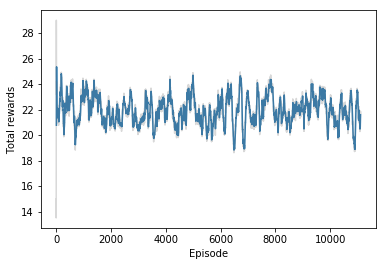

In [33]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

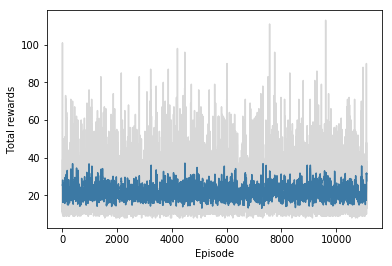

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

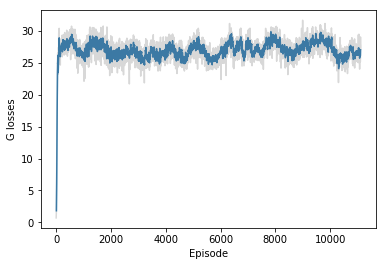

In [35]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

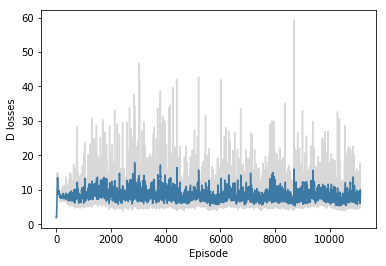

In [36]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.